<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/AUDJPY/AUDJPY_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AUDJPY=X"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  63.942  64.669  62.635  63.888     63.888       0
2009-01-02  63.910  65.494  63.080  65.057     65.057       0
2009-01-05  65.845  67.122  65.090  66.610     66.610       0
2009-01-06  66.530  68.161  65.890  67.200     67.200       0
2009-01-07  67.190  67.880  65.604  65.833     65.833       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  77.803  78.122  77.608  77.780     77.780       0
2018-12-27  78.658  78.658  77.656  78.668     78.668       0
2018-12-28  77.976  78.106  77.658  77.981     77.981       0
2018-12-31  77.710  78.045  77.187  77.726     77.726       0
2019-01-01  77.200  77.486  76.750  77.175     77.175       0

[2607 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2607.000000  2607.000000  2607.000000  2607.000000  2607.000000  2607.0
mean     84.953932    85.408813    84.457627    84.957219    84.957219     0.0
std       7.456303     7.377366     7.542292     7.445840     7.445840     0.0
min      56.320000    57.148000    55.548200    56.300000    56.300000     0.0
25%      80.415000    80.932500    79.911750    80.422500    80.422500     0.0
50%      84.005000    84.455000    83.530000    84.012000    84.012000     0.0
75%      90.131000    90.655000    89.510000    90.125500    90.125500     0.0
max     105.072000   105.372000   104.380000   105.059000   105.059000     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08      SMA_8     TEMA_8    TRIMA_8      WMA_8     MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-12  63.000  64.2015  61.4876  63.600     63.600   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  62.721822  61.045317 -64.757000  63.604162  63.086263  61.679898    63.33000     62.9195  64.757000  63.220113  63.503744  63.170180  63.280375  63.220113  63.510000  61.950046               64.251702                63.220113               62.188523               64.767496                63.220113               61.672729               65.283291                63.220113               61.156934               65.799086                63.220113               60.641139  63.086263  63.396487  62.145170               64.117852                63.086263               62.054673               64.633647                63.086263               61.538879               65.149441                63.086263               61.023084               65.665236                63.086263   
2009-03-13  63.627  64.9310  63.5500  64.474     64.474   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  62.809431  61.089419  61.487600  64.037315  63.394649  61.806527    63.56700     63.2093  61.487600  63.434363  64.056254  63.296830  63.559017  63.434363  64.037000  62.128254               64.683694                63.434363               62.185031               65.308360                63.434363               61.560365               65.933026                63.434363               60.935699               66.557691                63.434363               60.311034  63.394649  64.135547  62.321481               64.643980                63.394649               62.145317               65.268646                63.394649               61.520651               65.893312                63.394649               60.895986               66.517978                63.394649   
2009-03-16  64.376  65.3200  64.2500  64.7

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000    2557.000000   2557.000000     2557.000000      2557.00000        2557.00000  2557.000000  2557.000000  2557.000000  2557.000000   2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000             2557.000000              2557.000000             2557.000000             2557.000000              2557.000000             2557.000000             2557.000000              2557.000000             2557.000000             2557.000000              2557.000000             2557.000000  2557.000000  2557.000000  2557.000000             2557.000000              2557.000000             2557.000000             2557.000000              2557.000000             2557.000000             2557.000000   
mean     85.421080    85.866702    84.935413    85.424124    85.424124    15.756746     1.998827   185.928823      30.468127      0.033242        0.966758         0.01095           0.98905     6.615956     2.537348    27.009386     1.998827      2.000391    27.009386    85.384652    85.321514    -0.976539    85.426215    85.403132    85.444995    85.371785    85.295979    85.156053    85.404129    85.424045    85.404165    85.410883    85.404129    85.421068    85.354795               86.839621                85.404129               83.968638               87.557367                85.404129               83.250892               88.275112                85.404129               82.533147               88.992858                85.404129               81.815401    85.403132    85.420048    85.362903               86.838623                85.403132               83.967641               87.556369                85.403132               83.249895               88.274115   
std       6.720919     6.665351     6.779904     6.710264     6.710264     8.805779     1.414628   104.391150       0.781399      0.179303        0.179303         0.10409           0.10409     3.414096     1.107960    14.928282     1.414628      1.414075    14.928282     6.688976     6.704795    85.575680     6.723589     6.680175     6.775901     6.714378     6.734310     6.931167     6.702421     6.724030     6.713810     6.695720     6.702421     6.707412     6.721562                6.605635                 6.702421                6.906879                6.599305                 6.702421                7.046750                6.621243                 6.702421                7.209855                6.671171                 6.702421                7.394657     6.680175     6.699311     6.716404                6.582644                 6.680175                6.885693                6.576083                 6.680175                7.026181                6.597890   
min      63.000000    64.201500    61.487600    63.600000    63.600000     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.000000  0.000000  0.000000  0.000000   0.000000   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.000000  0.000000  0.196370  0.000000  0.000000  0.000000    0.000000    0.000000  0.074500  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.003893                0.000000                 0.000000                0.011629                0.000000                 0.000000                0.031934                0.000000                 0.000000                0.055636  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000000                0.000000                 0.000000                0.003059                0.000000                 0.000000                0.021382                0.000000                 0.000000   
2009-03-13  0.014903  0.017719  0.048083  0.021081   0.021081   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.002232  0.001101  0.806751  0.010547  0.007769  0.003073    0.006042    0.007324  0.000000  0.005381  0.013148  0.003131  0.006908  0.005381  0.012690  0.004494                0.009940                 0.005381                0.003803                0.011788                 0.005381                0.008766                0.013452                 0.005381                0.026425                0.014956                 0.005381                0.047635  0.007769  0.017822  0.004457                0.011863                 0.007769                0.002332                0.013577                 0.007769                0.002591                0.015122                 0.007769                0.018177                0.016522                 0.007769   
2009-03-16  0.032706  0.027168  0.064403  0.027497   0.027497   16          0         75

138080

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphnq_o9jr
  JVM stdout: /tmp/tmphnq_o9jr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphnq_o9jr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_82rcur
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_102049_mod...  0.630804  0.677365              0.454763  0.492201  0.242262
1  DeepLearning_grid_1_AutoML_20190822_102049_mod...  0.590566  0.899887              0.414832  0.554889  0.307902
2  DeepLearning_grid_1_AutoML_20190822_102049_mod...  0.589585  0.809797              0.446360  0.543920  0.295849
3  DeepLearning_grid_1_AutoML_20190822_102049_mod...  0.579771  0.699575              0.483408  0.503213  0.253224
4              DeepLearning_1_AutoML_20190822_102049  0.577072  0.963522              0.486506  0.577509  0.333517
5  DeepLearning_grid_1_AutoML_20190822_102049_mod...  0.566521  0.714914              0.470803  0.510311  0.260417
6  DeepLearning_grid_1_AutoML_20190822_102049_mod...  0.551862  1.656708              0.461510  0.628862  0.395468
7  DeepLearning_grid_1_AutoML_20190822_102049_mod...  0.525977  0.694261              0.475005  0.500523  0.250524
8  DeepLearning_grid_1_AutoML_20190822_102049_mod...  0.513494  0.694886              0.485954  0.500865  0.250866
9  DeepLearning_grid_1_AutoML_20190822_102049_mod...  0.500000  0.704624              0.500000  0.505685  0.255717

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.004183
1                          SUB             0.889127           0.889127    0.003720
2           CDLEVENINGDOJISTAR             0.819381           0.819381    0.003428
3               CDLEVENINGSTAR             0.807093           0.807093    0.003376
4              CDLADVANCEBLOCK             0.801140           0.801140    0.003352
...                        ...                  ...                ...         ...
1020  BBANDS_middleband_14_5_5             0.180959           0.180959    0.000757
1021  BBANDS_middleband_24_7_3             0.180823           0.180823    0.000756
1022                   KAMA_14             0.179195           0.179195    0.000750
1023  BBANDS_middleband_24_5_3             0.171409           0.171409    0.000717
1024       CDLXSIDEGAP3METHODS             0.163305           0.163305    0.000683

[1025 rows x 4 columns]

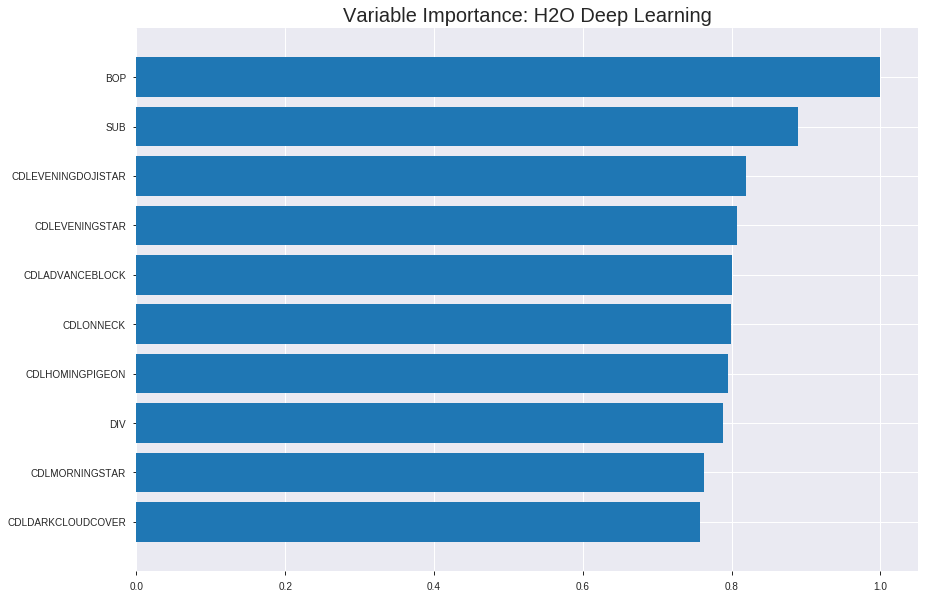

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_102049_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23088406063176353
RMSE: 0.4805039652612281
LogLoss: 0.6615224934064292
Mean Per-Class Error: 0.361479961975284
AUC: 0.6926671086206033
pr_auc: 0.6949587749615498
Gini: 0.38533421724120664
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28602860462246466: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      317  552   0.6352   (552.0/869.0)
1      116  804   0.1261   (116.0/920.0)
Total  433  1356  0.3734   (668.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286029     0.706503  283
max f2                       0.0367508    0.843307  387
max f0point5                 0.379761     0.648148  229
max accuracy                 0.379761     0.64114   229
max precision                0.915407     1         0
max recall                   0.00820773   1         396
max specificity              0.915407     1         0
max absolute_mcc             0.378327     0.282417  230
max min_per_class_accuracy   0.4299       0.625     199
max mean_per_class_accuracy  0.379761     0.63852   229

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 41.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.814634           1.83653   1.83653            0.944444         0.858744   0.944444                    0.858744            0.0184783       0.0184783                  83.6534   83.6534
    2        0.020123                    0.767984           1.62047   1.7285             0.833333         0.796      0.888889                    0.827372            0.0163043       0.0347826                  62.0471   72.8502
    3        0.0301845                   0.747531           1.7285    1.7285             0.888889         0.755298   0.888889                    0.803347            0.0173913       0.0521739                  72.8502   72.8502
    4        0.0402459                   0.728424           1.29638   1.62047            0.666667         0.737105   0.833333                    0.786787            0.0130435       0.0652174                  29.6377   62.0471
    5        0.0503074                   0.713354           1.40441   1.57726            0.722222         0.720541   0.811111                    0.773538            0.0141304       0.0793478                  40.4408   57.7258
    6        0.100056                    0.65162            1.66053   1.61866            0.853933         0.681986   0.832402                    0.728018            0.0826087       0.161957                   66.0528   61.866
    7        0.150363                    0.612845           1.20995   1.48192            0.622222         0.631457   0.762082                    0.695711            0.0608696       0.222826                   20.9952   48.1918
    8        0.200112                    0.584729           1.22355   1.41769            0.629213         0.598462   0.72905                     0.671535            0.0608696       0.283696                   22.3547   41.7686
    9        0.300168                    0.53009            1.29276   1.37604            0.664804         0.55586    0.707635                    0.632976            0.129348        0.413043                   29.2756   37.6042
    10       0.400224                    0.47867            1.15153   1.31991            0.592179         0.504208   0.678771                    0.600784            0.115217        0.528261                   15.153    31.9914
    11       0.500279                    0.430056           0.945124  1.24496            0.486034         0.452553   0.640223                    0.571138            0.0945652       0.622826                   -5.48761  24.4956
    12       0.599776                    0.377798           1.12523   1.22509            0.578652         0.40422    0.630009                    0.543448            0.111957        0.734783                   12.5226   22.5094
    13       0.699832                    0.321335           0.836489  1.16953            0.430168         0.35075    0.601438                    0.515898            0.0836957       0.818478                   -16.3511  16.9535
    14       0.799888                    0.247439           0.814762  1.12516            0.418994         0.289179   0.578616                    0.487538            0.0815217       0.9                        -18.5238  12.5157
    15       0.899944                    0.140492           0.586629  1.06528            0.301676         0.194271   0.547826                    0.454933            0.0586957       0.958696                   -41.3371  6.52836
    16       1                           2.94179e-06        0.412813  1                  0.212291         0.0720269  0.514254                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24585818831529702
RMSE: 0.49584089012030563
LogLoss: 0.6945176401118919
Mean Per-Class Error: 0.40989214175654853
AUC: 0.5952850539291218
pr_auc: 0.6023197144582818
Gini: 0.19057010785824358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16633784964867135: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   221  0.9364   (221.0/236.0)
1      2    273  0.0073   (2.0/275.0)
Total  17   494  0.4364   (223.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.166338     0.710013  382
max f2                       0.166338     0.856336  382
max f0point5                 0.400143     0.63475   304
max accuracy                 0.400143     0.610568  304
max precision                0.838259     1         0
max recall                   0.000744417  1         398
max specificity              0.838259     1         0
max absolute_mcc             0.395332     0.217131  307
max min_per_class_accuracy   0.523383     0.556364  201
max mean_per_class_accuracy  0.400143     0.590108  304

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 51.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.820799           0.929091  0.929091           0.5              0.829514  0.5                         0.829514            0.0109091       0.0109091                  -7.09091  -7.09091
    2        0.0215264                   0.797959           1.11491   1.01355            0.6              0.803159  0.545455                    0.817534            0.0109091       0.0218182                  11.4909   1.35537
    3        0.0313112                   0.777333           1.48655   1.16136            0.8              0.783024  0.625                       0.80675             0.0145455       0.0363636                  48.6545   16.1364
    4        0.0410959                   0.768746           1.11491   1.1503             0.6              0.773441  0.619048                    0.798819            0.0109091       0.0472727                  11.4909   15.0303
    5        0.0508806                   0.7565             1.11491   1.1435             0.6              0.761628  0.615385                    0.791667            0.0109091       0.0581818                  11.4909   14.3497
    6        0.101761                    0.710745           1.21497   1.17923            0.653846         0.730722  0.634615                    0.761195            0.0618182       0.12                       21.4965   17.9231
    7        0.150685                    0.680189           1.41222   1.25488            0.76             0.69317   0.675325                    0.739109            0.0690909       0.189091                   41.2218   25.4876
    8        0.201566                    0.654168           1.07203   1.20872            0.576923         0.664963  0.650485                    0.720392            0.0545455       0.243636                   7.2028    20.872
    9        0.30137                     0.608511           0.947308  1.12215            0.509804         0.631089  0.603896                    0.690818            0.0945455       0.338182                   -5.26916  12.2149
    10       0.401174                    0.564789           1.09305   1.11491            0.588235         0.587575  0.6                         0.665133            0.109091        0.447273                   9.30481   11.4909
    11       0.500978                    0.52376            1.05661   1.1033             0.568627         0.543081  0.59375                     0.640818            0.105455        0.552727                   5.66132   10.3295
    12       0.600783                    0.48401            1.09305   1.10159            0.588235         0.504997  0.592834                    0.618255            0.109091        0.661818                   9.30481   10.1593
    13       0.700587                    0.440681           1.09305   1.10038            0.588235         0.465331  0.592179                    0.59647             0.109091        0.770909                   9.30481   10.0376
    14       0.800391                    0.387385           1.02018   1.09038            0.54902          0.414772  0.586797                    0.573813            0.101818        0.872727                   2.01783   9.03756
    15       0.900196                    0.312844           0.655829  1.0422             0.352941         0.352578  0.56087                     0.549285            0.0654545       0.938182                   -34.4171  4.21976
    16       1                           2.65203e-05        0.619394  1                  0.333333         0.201615  0.53816                     0.514586         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 10:24:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 10:24:22  3 min 27.705 sec  465 obs/sec       0.406372  1             727        0.613203         2.46834             -0.505297      0.569893        0.434146           1.29638          0.470654                         0.635419           2.27894               -0.624493        0.537928          0.52789              1.23879            0.46184
    2019-08-22 10:24:33  3 min 38.545 sec  505 obs/sec       3.22694   8             5773       0.666302         5.93192             -0.777276      0.568798        0.359852           1.43091          0.485746                         0.631916           4.2066                -0.606631        0.541749          0.455874             0.929091           0.432485
    2019-08-22 10:24:43  3 min 48.932 sec  516 obs/sec       6.00279   15            10739      0.645851         3.93752             -0.669851      0.58693         0.39602            1.7285           0.485746                         0.616161           3.25045               -0.527515        0.560632          0.530273             0.929091           0.414873
    2019-08-22 10:24:53  3 min 59.292 sec  500 obs/sec       8.44159   21            15102      0.541107         1.12521             -0.172138      0.673914        0.60651            1.62047          0.404136                         0.564223           1.26728               -0.280853        0.57943           0.565986             1.54848            0.39726
    2019-08-22 10:25:05  4 min 10.595 sec  518 obs/sec       11.7049   29            20940      0.551051         1.07768             -0.215615      0.654475        0.65614            1.7285           0.425936                         0.552568           0.985881              -0.228479        0.577049          0.599572             1.54848            0.450098
    2019-08-22 10:25:16  4 min 21.848 sec  530 obs/sec       15.0129   37            26858      0.565237         1.09269             -0.279011      0.575228        0.557617           1.29638          0.453885                         0.530297           0.818215              -0.131449        0.561988          0.598055             0.929091           0.452055
    2019-08-22 10:25:27  4 min 32.827 sec  539 obs/sec       18.2884   45            32718      0.490035         0.689653            0.0386803      0.656518        0.646099           1.40441          0.413639                         0.498917           0.699716              -0.00150641      0.588128          0.582756             0.929091           0.414873
    2019-08-22 10:25:37  4 min 42.596 sec  543 obs/sec       21.1146   52            37774      0.58485          1.21802             -0.369311      0.59267         0.605995           1.62047          0.446618                         0.534383           0.847497              -0.148952        0.570616          0.579552             1.23879            0.403131
    2019-08-22 10:25:48  

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.004183468823851695
SUB                       0.8891268372535706     0.8891268372535706   0.003719634404100172
CDLEVENINGDOJISTAR        0.819381058216095      0.819381058216095    0.003427855111901644
CDLEVENINGSTAR            0.8070930242538452     0.8070930242538452   0.0033764485049141415
CDLADVANCEBLOCK           0.8011403679847717     0.8011403679847717   0.003351545752993367
---                       ---                    ---                  ---
BBANDS_middleband_14_5_5  0.18095892667770386    0.18095892667770386  0.0007570360281538388
BBANDS_middleband_24_7_3  0.18082334101200104    0.18082334101200104  0.00075646880974841
KAMA_14                   0.17919546365737915    0.17919546365737915  0.0007496586355862951
BBANDS_middleband_24_5_3  0.17140942811965942    0.17140942811965942  0.0007170859986528433
CDLXSIDEGAP3METHODS       0.16330532729625702    0.16330532729625702  0.0006831827455127885


See the whole table with table.as_data_frame()


('accuracy', 0.62890625)

('F1', 0.6497175141242937)

('auc', 0.6308041464761087)

('logloss', 0.6773653851346284)

('mean_per_class_error', 0.38772005152425937)

('rmse', 0.4922010494454534)

('mse', 0.24226187307520566)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


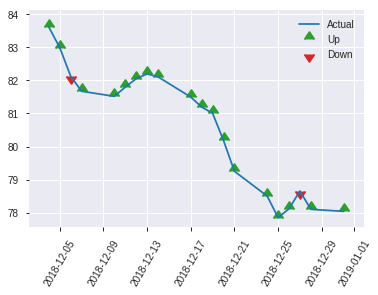


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24226187307520566
RMSE: 0.4922010494454534
LogLoss: 0.6773653851346284
Mean Per-Class Error: 0.38772005152425937
AUC: 0.6308041464761087
pr_auc: 0.5853071623289076
Gini: 0.26160829295221744
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31798904041576115: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   120  0.8759   (120.0/137.0)
1      4    115  0.0336   (4.0/119.0)
Total  21   235  0.4844   (124.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317989     0.649718  234
max f2                       0.217747     0.82069   248
max f0point5                 0.644891     0.585831  61
max accuracy                 0.644891     0.628906  61
max precision                0.915871     1         0
max recall                   0.217747     1         248
max specificity              0.915871     1         0
max absolute_mcc             0.644891     0.259225  61
max min_per_class_accuracy   0.54132      0.579832  120
max mean_per_class_accuracy  0.488671     0.61228   164

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.869368           1.43417   1.43417            0.666667         0.894798  0.666667                    0.894798            0.0168067       0.0168067                  43.4174   43.4174
    2        0.0234375                   0.854697           1.43417   1.43417            0.666667         0.859561  0.666667                    0.877179            0.0168067       0.0336134                  43.4174   43.4174
    3        0.03125                     0.834864           1.07563   1.34454            0.5              0.842463  0.625                       0.8685              0.00840336      0.0420168                  7.56303   34.4538
    4        0.0429688                   0.815853           1.43417   1.36898            0.666667         0.823157  0.636364                    0.856134            0.0168067       0.0588235                  43.4174   36.8984
    5        0.0507812                   0.792083           2.15126   1.48933            1                0.81126   0.692308                    0.84923             0.0168067       0.0756303                  115.126   48.9334
    6        0.101562                    0.756122           1.32385   1.40659            0.615385         0.772433  0.653846                    0.810831            0.0672269       0.142857                   32.3853   40.6593
    7        0.152344                    0.712762           1.48933   1.43417            0.692308         0.735672  0.666667                    0.785778            0.0756303       0.218487                   48.9334   43.4174
    8        0.203125                    0.671434           1.48933   1.44796            0.692308         0.689217  0.673077                    0.761638            0.0756303       0.294118                   48.9334   44.7964
    9        0.300781                    0.612628           1.11866   1.34105            0.52             0.637103  0.623377                    0.721205            0.109244        0.403361                   11.8655   34.1046
    10       0.402344                    0.56377            1.07563   1.27405            0.5              0.587327  0.592233                    0.68741             0.109244        0.512605                   7.56303   27.4047
    11       0.5                         0.535951           0.774454  1.17647            0.36             0.547669  0.546875                    0.660117            0.0756303       0.588235                   -22.5546  17.6471
    12       0.601562                    0.505114           1.07563   1.15945            0.5              0.521152  0.538961                    0.636655            0.109244        0.697479                   7.56303   15.9446
    13       0.699219                    0.465429           0.774454  1.10568            0.36             0.484934  0.513966                    0.615465            0.0756303       0.773109                   -22.5546  10.5676
    14       0.800781                    0.395695           0.579186  1.0389             0.269231         0.433004  0.482927                    0.592324            0.0588235       0.831933                   -42.0814  3.89014
    15       0.898438                    0.330519           1.11866   1.04757            0.52             0.362826  0.486957                    0.567378            0.109244        0.941176                   11.8655   4.75703
    16       1                           0.0105253          0.579186  1                  0.269231         0.233048  0.464844                    0.533423         

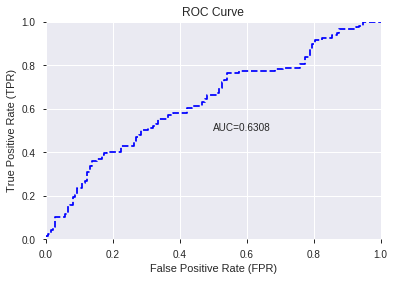

This function is available for GLM models only


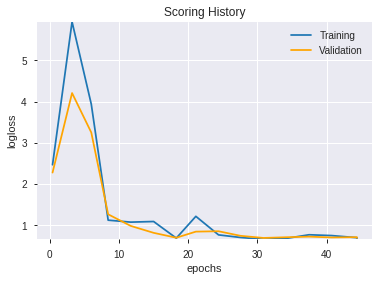

--2019-08-22 10:45:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  47.0MB/s    in 7.9s    

2019-08-22 10:45:54 (44.4 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_102049_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_102049_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_104603_model_6  0.669693  0.689128              0.380421  0.498471  0.248474
1  DeepLearning_grid_1_AutoML_20190822_104603_model_9  0.667975  0.698102              0.419033  0.502683  0.252691
2  DeepLearning_grid_1_AutoML_20190822_104603_model_8  0.666350  0.695794              0.428878  0.501358  0.251360
3  DeepLearning_grid_1_AutoML_20190822_104603_model_5  0.636815  0.705184              0.428326  0.506166  0.256205
4               DeepLearning_1_AutoML_20190822_104603  0.628351  0.689741              0.420475  0.496845  0.246855
5  DeepLearning_grid_1_AutoML_20190822_104603_model_7  0.626878  0.755628              0.449120  0.528252  0.279050
6  DeepLearning_grid_1_AutoML_20190822_104603_model_4  0.599276  0.798526              0.457861  0.530184  0.281095
7  DeepLearning_grid_1_AutoML_20190822_104603_model_3  0.566460  0.723823              0.489051  0.514027  0.264223
8  DeepLearning_grid_1_AutoML_20190822_104603_model_1  0.558977  1.022457              0.492701  0.578978  0.335215
9  DeepLearning_grid_1_AutoML_20190822_104603_model_2  0.517512  0.781720              0.489051  0.533512  0.284635

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.026781
1                  SUB             0.923781           0.923781    0.024740
2                  DIV             0.818426           0.818426    0.021919
3               SAREXT             0.800276           0.800276    0.021432
4    CDLLONGLEGGEDDOJI             0.793102           0.793102    0.021240
5       CDLRICKSHAWMAN             0.786997           0.786997    0.021077
6         STOCHF_fastk             0.779612           0.779612    0.020879
7      CDLADVANCEBLOCK             0.776538           0.776538    0.020797
8            CDLONNECK             0.775017           0.775017    0.020756
9     CDLDRAGONFLYDOJI             0.771707           0.771707    0.020667
10   CDLGRAVESTONEDOJI             0.771642           0.771642    0.020666
11           CORREL_12             0.768972           0.768972    0.020594
12         CDLBELTHOLD             0.765578           0.765578    0.020503
13  CDLMORNINGDOJISTAR             0.762604           0.762604    0.020424
14      CDLMATCHINGLOW             0.762323           0.762323    0.020416
15    CDLABANDONEDBABY             0.759987           0.759987    0.020353
16        HT_TRENDMODE             0.759812           0.759812    0.020349
17        CDLTHRUSTING             0.759521           0.759521    0.020341
18             CDLDOJI             0.757559           0.757559    0.020288
19              ULTOSC             0.757510           0.757510    0.020287
20     CDLUNIQUE3RIVER             0.756858           0.756858    0.020270
21           CDLINNECK             0.753434           0.753434    0.020178
22           dayofweek             0.751397           0.751397    0.020123
23                COSH             0.749030           0.749030    0.020060
24  CDLSEPARATINGLINES             0.746328           0.746328    0.019988
25       days_in_month             0.740330           0.740330    0.019827
26          CDL3INSIDE             0.737187           0.737187    0.019743
27      CDLEVENINGSTAR             0.734806           0.734806    0.019679
28                SINH             0.734036           0.734036    0.019658
29        is_month_end             0.729209           0.729209    0.019529
30      CDLMORNINGSTAR             0.727625           0.727625    0.019487
31                 SIN             0.725590           0.725590    0.019432
32      is_month_start             0.724937           0.724937    0.019415
33  CDLEVENINGDOJISTAR             0.723093           0.723093    0.019365
34     CDLLADDERBOTTOM             0.720757           0.720757    0.019303
35                 EXP             0.714103           0.714103    0.019125
36   CDLDARKCLOUDCOVER             0.708688           0.708688    0.018980
37    is_quarter_start             0.705189           0.705189    0.018886
38           CDLTAKURI             0.704232           0.704232    0.018860
39              TRANGE             0.704203           0.704203    0.018860
40        weekday_name             0.702132           0.702132    0.018804
41             weekday             0.699503           0.699503    0.018734
42     CDLSHOOTINGSTAR             0.698958           0.698958    0.018719
43      is_quarter_end             0.698787           0.698787    0.018714
44   CDLINVERTEDHAMMER             0.697959           0.697959    0.018692
45       CDLHANGINGMAN             0.691168           0.691168    0.018510
46       CDLHIKKAKEMOD             0.688354           0.688354    0.018435
47    CDLCOUNTERATTACK             0.678639           0.678639    0.018175
48     CDLHOMINGPIGEON             0.674270           0.674270    0.018058
49           CDLHAMMER             0.667674           0.667674    0.017881

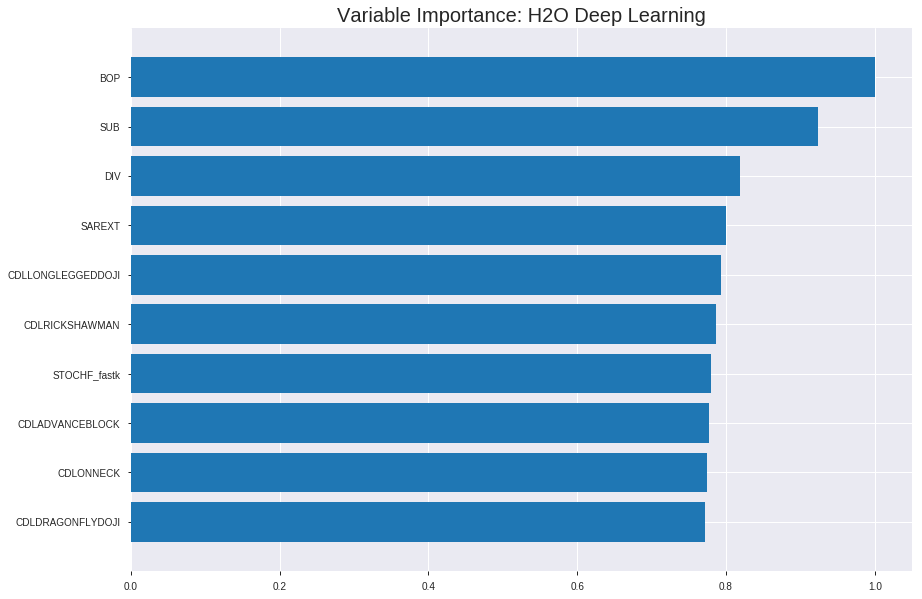

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_104603_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22903224465537964
RMSE: 0.4785731340718779
LogLoss: 0.648439092452134
Mean Per-Class Error: 0.37122817331265323
AUC: 0.6732576174513434
pr_auc: 0.6627327906932248
Gini: 0.34651523490268676
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39003148474650423: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      166  703   0.809    (703.0/869.0)
1      44   876   0.0478   (44.0/920.0)
Total  210  1579  0.4176   (747.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390031     0.70108   284
max f2                       0.146523     0.845615  370
max f0point5                 0.552596     0.639859  174
max accuracy                 0.552596     0.632197  174
max precision                0.822234     1         0
max recall                   0.0820626    1         386
max specificity              0.822234     1         0
max absolute_mcc             0.552596     0.265714  174
max min_per_class_accuracy   0.57266      0.620253  148
max mean_per_class_accuracy  0.552596     0.628772  174

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 53.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.719028           1.62047   1.62047            0.833333         0.747158  0.833333                    0.747158            0.0163043       0.0163043                  62.0471   62.0471
    2        0.020123                    0.699309           1.29638   1.45842            0.666667         0.708433  0.75                        0.727796            0.0130435       0.0293478                  29.6377   45.8424
    3        0.0301845                   0.688105           1.40441   1.44042            0.722222         0.693313  0.740741                    0.716301            0.0141304       0.0434783                  40.4408   44.0419
    4        0.0402459                   0.681469           1.29638   1.40441            0.666667         0.684709  0.722222                    0.708403            0.0130435       0.0565217                  29.6377   40.4408
    5        0.0503074                   0.671587           1.51244   1.42601            0.777778         0.67778   0.733333                    0.702279            0.0152174       0.0717391                  51.244    42.6014
    6        0.100056                    0.641035           1.46389   1.44484            0.752809         0.653404  0.743017                    0.677978            0.0728261       0.144565                   46.3886   44.4845
    7        0.150363                    0.627189           1.44762   1.44577            0.744444         0.634181  0.743494                    0.663325            0.0728261       0.217391                   44.7621   44.5773
    8        0.200112                    0.618853           1.22355   1.39053            0.629213         0.622744  0.715084                    0.653236            0.0608696       0.278261                   22.3547   39.0527
    9        0.300168                    0.601988           1.14067   1.30724            0.586592         0.610802  0.672253                    0.639091            0.11413         0.392391                   14.0667   30.724
    10       0.400224                    0.588346           1.16239   1.27103            0.597765         0.59521   0.653631                    0.628121            0.116304        0.508696                   16.2394   27.1029
    11       0.500279                    0.573069           1.07549   1.23192            0.553073         0.580539  0.63352                     0.618605            0.107609        0.616304                   7.54858   23.192
    12       0.599776                    0.556627           1.0706    1.20516            0.550562         0.564843  0.619758                    0.609686            0.106522        0.722826                   7.06033   20.5159
    13       0.699832                    0.531712           0.923397  1.16488            0.47486          0.544767  0.599042                    0.600405            0.0923913       0.815217                   -7.66031  16.4875
    14       0.799888                    0.482107           0.727854  1.11021            0.374302         0.509482  0.570929                    0.589031            0.0728261       0.888043                   -27.2146  11.0209
    15       0.899944                    0.363267           0.749581  1.07011            0.385475         0.426595  0.550311                    0.570972            0.075           0.963043                   -25.0419  7.01148
    16       1                           0.0264377          0.369359  1                  0.189944         0.226849  0.514254                    0.53654            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23552611434661908
RMSE: 0.48531032787961464
LogLoss: 0.6641860799735737
Mean Per-Class Error: 0.39007704160246526
AUC: 0.6364175654853621
pr_auc: 0.6454804583787083
Gini: 0.2728351309707242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5170357205642225: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      65   171  0.7246   (171.0/236.0)
1      24   251  0.0873   (24.0/275.0)
Total  89   422  0.3816   (195.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.517036     0.72023   315
max f2                       0.217884     0.856785  387
max f0point5                 0.567782     0.639871  229
max accuracy                 0.517036     0.618395  315
max precision                0.724938     1         0
max recall                   0.0561083    1         397
max specificity              0.724938     1         0
max absolute_mcc             0.517036     0.24733   315
max min_per_class_accuracy   0.584835     0.603636  184
max mean_per_class_accuracy  0.586284     0.609923  181

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 55.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.689569           1.54848   1.54848            0.833333         0.708145  0.833333                    0.708145            0.0181818       0.0181818                  54.8485   54.8485
    2        0.0215264                   0.672369           1.48655   1.52033            0.8              0.679959  0.818182                    0.695333            0.0145455       0.0327273                  48.6545   52.0331
    3        0.0313112                   0.66543            1.48655   1.50977            0.8              0.669982  0.8125                      0.687411            0.0145455       0.0472727                  48.6545   50.9773
    4        0.0410959                   0.652202           1.11491   1.41576            0.6              0.655914  0.761905                    0.679912            0.0109091       0.0581818                  11.4909   41.5758
    5        0.0508806                   0.648563           1.11491   1.3579             0.6              0.649381  0.730769                    0.67404             0.0109091       0.0690909                  11.4909   35.7902
    6        0.101761                    0.639309           1.1435    1.2507             0.615385         0.643061  0.673077                    0.658551            0.0581818       0.127273                   14.3497   25.0699
    7        0.150685                    0.632891           1.18924   1.23074            0.64             0.636202  0.662338                    0.651295            0.0581818       0.185455                   18.9236   23.0744
    8        0.201566                    0.626072           1.3579    1.26284            0.730769         0.629698  0.679612                    0.645843            0.0690909       0.254545                   35.7902   26.2842
    9        0.30137                     0.611746           1.16592   1.23074            0.627451         0.617348  0.662338                    0.636407            0.116364        0.370909                   16.5918   23.0744
    10       0.401174                    0.599946           1.09305   1.19649            0.588235         0.605209  0.643902                    0.628645            0.109091        0.48                       9.30481   19.6488
    11       0.500978                    0.584868           1.23879   1.20491            0.666667         0.591702  0.648438                    0.621285            0.123636        0.603636                   23.8788   20.4915
    12       0.600783                    0.570362           0.874439  1.15001            0.470588         0.578706  0.618893                    0.614212            0.0872727       0.690909                   -12.5561  15.0015
    13       0.700587                    0.555339           0.874439  1.11076            0.470588         0.563423  0.597765                    0.606977            0.0872727       0.778182                   -12.5561  11.0757
    14       0.800391                    0.52934            1.05661   1.10401            0.568627         0.543686  0.594132                    0.599085            0.105455        0.883636                   5.66132   10.4005
    15       0.900196                    0.438324           0.692264  1.05836            0.372549         0.494087  0.569565                    0.587444            0.0690909       0.952727                   -30.7736  5.83557
    16       1                           0.0335229          0.473654  1                  0.254902         0.298154  0.53816                     0.558571         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 10:49:21  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 10:49:23  1 min 32.811 sec  893 obs/sec       0.740078  1             1324       0.519833         0.792143            -0.0817844     0.62612         0.619157           1.51244          0.447736                         0.517879           0.753464              -0.0790792       0.583837          0.610986             1.54848            0.448141
    2019-08-22 10:49:29  1 min 39.124 sec  1837 obs/sec      7.38904   10            13219      0.478573         0.648439            0.0831259      0.673258        0.662733           1.62047          0.417552                         0.48531            0.664186              0.0523757        0.636418          0.64548              1.54848            0.381605
    2019-08-22 10:49:35  1 min 45.424 sec  2448 obs/sec      17.7121   24            31687      0.473142         0.637657            0.103817       0.697864        0.685096           1.7285           0.355506                         0.487616           0.668743              0.0433513        0.632072          0.647629             1.54848            0.393346
    2019-08-22 10:49:41  1 min 51.226 sec  2684 obs/sec      27.289    37            48820      0.468784         0.6275              0.120252       0.707803        0.702106           1.83653          0.346562                         0.488157           0.672178              0.0412269        0.633398          0.651448             1.54848            0.391389
    2019-08-22 10:49:47  1 min 56.936 sec  2829 obs/sec      36.9111   50            66034      0.461398         0.611501            0.147753       0.722863        0.719584           1.94457          0.351034                         0.490175           0.679485              0.0332846        0.615663          0.629213             1.54848            0.395303
    2019-08-22 10:49:53  2 min  2.809 sec  2951 obs/sec      47.2348   64            84503      0.459097         0.606328            0.156234       0.73819         0.733263           1.94457          0.337619                         0.490944           0.682374              0.0302483        0.632219          0.645385             1.23879            0.39726
    2019-08-22 10:49:59  2 min  8.724 sec  3027 obs/sec      57.5215   78            102906     0.450768         0.589323            0.186572       0.748938        0.750407           1.94457          0.326998                         0.490023           0.681449              0.0338804        0.616703          0.63273              1.23879            0.426614
    2019-08-22 10:49:59  2 min  9.334 sec  3025 obs/sec      57.5215   78            102906     0.478573         0.648439            0.0831259      0.673258        0.662733           1.62047          0.417552                         0.48531            0.664186              0.0523757        0.636418          0.64548              1.54848            0.381605

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
BOP                1.0                    1.0                  0.026781333590472543
SUB                0.923780620098114      0.923780620098114    0.024740076951261174
DIV                0.818426251411438      0.818426251411438    0.02191854645824967
SAREXT             0.8002762794494629     0.8002762794494629   0.02143246600447829
CDLLONGLEGGEDDOJI  0.7931023836135864     0.7931023836135864   0.02124033950695438
---                ---                    ---                  ---
CDLHANGINGMAN      0.6911677122116089     0.6911677122116089   0.01851039306770282
CDLHIKKAKEMOD      0.6883535385131836     0.6883535385131836   0.01843502574310376
CDLCOUNTERATTACK   0.6786393523216248     0.6786393523216248   0.01817486688214766
CDLHOMINGPIGEON    0.6742697954177856     0.6742697954177856   0.01805784432106339
CDLHAMMER          0.66767418384552       0.66767418384552     0.017881205047313366


See the whole table with table.as_data_frame()


('accuracy', 0.66015625)

('F1', 0.6453900709219859)

('auc', 0.6696926945960866)

('logloss', 0.689127699833252)

('mean_per_class_error', 0.3396000736060848)

('rmse', 0.49847147675460163)

('mse', 0.24847381313791334)

deeplearning prediction progress: |███████████████████████████████████████| 100%


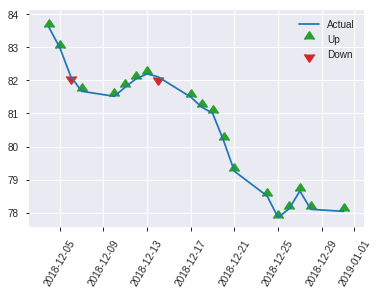


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24847381313791334
RMSE: 0.49847147675460163
LogLoss: 0.689127699833252
Mean Per-Class Error: 0.3396000736060848
AUC: 0.6696926945960866
pr_auc: 0.6572398674892923
Gini: 0.3393853891921732
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5700544955861994: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      65   72   0.5255   (72.0/137.0)
1      28   91   0.2353   (28.0/119.0)
Total  93   163  0.3906   (100.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.570054     0.64539   162
max f2                       0.358334     0.819559  249
max f0point5                 0.588116     0.634146  123
max accuracy                 0.588116     0.660156  123
max precision                0.766952     1         0
max recall                   0.358334     1         249
max specificity              0.766952     1         0
max absolute_mcc             0.58786      0.320045  125
max min_per_class_accuracy   0.58786      0.656934  125
max mean_per_class_accuracy  0.58786      0.6604    125

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 57.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.688564           2.15126   2.15126            1                0.72169   1                           0.72169             0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.677462           2.15126   2.15126            1                0.682707  1                           0.702199            0.0252101       0.0504202                  115.126   115.126
    3        0.03125                     0.676129           2.15126   2.15126            1                0.677409  1                           0.696001            0.0168067       0.0672269                  115.126   115.126
    4        0.0429688                   0.669061           1.43417   1.95569            0.666667         0.672183  0.909091                    0.689505            0.0168067       0.0840336                  43.4174   95.5691
    5        0.0507812                   0.666956           2.15126   1.98578            1                0.667272  0.923077                    0.686085            0.0168067       0.10084                    115.126   98.5779
    6        0.101562                    0.647255           1.65482   1.8203             0.769231         0.65936   0.846154                    0.672723            0.0840336       0.184874                   65.4816   82.0297
    7        0.152344                    0.632939           1.48933   1.70998            0.692308         0.639508  0.794872                    0.661651            0.0756303       0.260504                   48.9334   70.9976
    8        0.203125                    0.625323           0.827408  1.48933            0.384615         0.629479  0.692308                    0.653608            0.0420168       0.302521                   -17.2592  48.9334
    9        0.300781                    0.610324           1.11866   1.36898            0.52             0.617525  0.636364                    0.641893            0.109244        0.411765                   11.8655   36.8984
    10       0.402344                    0.600833           1.15837   1.31582            0.538462         0.605262  0.61165                     0.632646            0.117647        0.529412                   15.8371   31.582
    11       0.5                         0.586436           1.37681   1.32773            0.64             0.594403  0.617188                    0.625177            0.134454        0.663866                   37.6807   32.7731
    12       0.601562                    0.575629           0.579186  1.20135            0.269231         0.581314  0.558442                    0.617771            0.0588235       0.722689                   -42.0814  20.1353
    13       0.699219                    0.562242           0.774454  1.14173            0.36             0.569426  0.530726                    0.611019            0.0756303       0.798319                   -22.5546  14.173
    14       0.800781                    0.543875           0.661926  1.08088            0.307692         0.550595  0.502439                    0.603356            0.0672269       0.865546                   -33.8074  8.08772
    15       0.898438                    0.491078           0.602353  1.02886            0.28             0.521474  0.478261                    0.594456            0.0588235       0.92437                    -39.7647  2.88637
    16       1                           0.228637           0.744667  1                  0.346154         0.389985  0.464844                    0.573689           

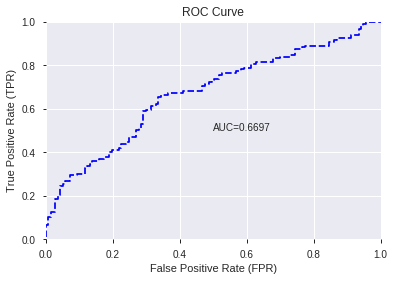

This function is available for GLM models only


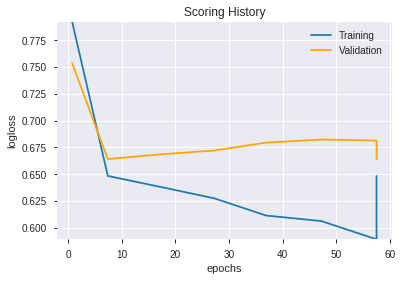

--2019-08-22 10:53:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_104603_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_104603_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'DIV',
 'SAREXT',
 'CDLLONGLEGGEDDOJI',
 'CDLRICKSHAWMAN',
 'STOCHF_fastk',
 'CDLADVANCEBLOCK',
 'CDLONNECK',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CORREL_12',
 'CDLBELTHOLD',
 'CDLMORNINGDOJISTAR',
 'CDLMATCHINGLOW',
 'CDLABANDONEDBABY',
 'HT_TRENDMODE',
 'CDLTHRUSTING',
 'CDLDOJI',
 'ULTOSC',
 'CDLUNIQUE3RIVER',
 'CDLINNECK',
 'dayofweek',
 'COSH',
 'CDLSEPARATINGLINES',
 'days_in_month',
 'CDL3INSIDE',
 'CDLEVENINGSTAR',
 'SINH',
 'is_month_end',
 'CDLMORNINGSTAR',
 'SIN',
 'is_month_start',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'EXP',
 'CDLDARKCLOUDCOVER',
 'is_quarter_start',
 'CDLTAKURI',
 'TRANGE',
 'weekday_name',
 'weekday',
 'CDLSHOOTINGSTAR',
 'is_quarter_end',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLHIKKAKEMOD',
 'CDLCOUNTERATTACK',
 'CDLHOMINGPIGEON',
 'CDLHAMMER']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_105329_model_1  0.646077  0.67201              0.439612  0.490983  0.241064

variable  relative_importance  scaled_importance  percentage
0                  SUB             1.881282           1.000000    0.228779
1                  DIV             1.432612           0.761509    0.174217
2    CDLLONGLEGGEDDOJI             0.524266           0.278675    0.063755
3                  BOP             0.480075           0.255185    0.058381
4              CDLDOJI             0.455646           0.242200    0.055410
5    CDLGRAVESTONEDOJI             0.313260           0.166514    0.038095
6     CDLDRAGONFLYDOJI             0.190867           0.101456    0.023211
7               TRANGE             0.184727           0.098192    0.022464
8      CDLSHOOTINGSTAR             0.171727           0.091282    0.020883
9         STOCHF_fastk             0.162022           0.086123    0.019703
10    CDLABANDONEDBABY             0.150847           0.080183    0.018344
11     CDLUNIQUE3RIVER             0.144011           0.076549    0.017513
12     CDLLADDERBOTTOM             0.140825           0.074856    0.017126
13   CDLINVERTEDHAMMER             0.137579           0.073130    0.016731
14           CDLINNECK             0.122462           0.065095    0.014892
15              ULTOSC             0.107372           0.057074    0.013057
16      CDLRICKSHAWMAN             0.098828           0.052532    0.012018
17              SAREXT             0.091089           0.048418    0.011077
18        is_month_end             0.078862           0.041919    0.009590
19           dayofweek             0.077236           0.041055    0.009393
20           CORREL_12             0.077122           0.040994    0.009379
21       CDLHANGINGMAN             0.076536           0.040683    0.009307
22             weekday             0.075239           0.039994    0.009150
23       days_in_month             0.070253           0.037343    0.008543
24  CDLEVENINGDOJISTAR             0.063639           0.033827    0.007739
25     CDLADVANCEBLOCK             0.062543           0.033245    0.007606
26      CDLMATCHINGLOW             0.061416           0.032646    0.007469
27      CDLEVENINGSTAR             0.061412           0.032644    0.007468
28      is_month_start             0.054746           0.029101    0.006658
29           CDLTAKURI             0.054148           0.028783    0.006585
30    is_quarter_start             0.053616           0.028500    0.006520
31       CDLHIKKAKEMOD             0.050898           0.027055    0.006190
32          CDL3INSIDE             0.050749           0.026976    0.006172
33     CDLHOMINGPIGEON             0.049138           0.026119    0.005976
34           CDLONNECK             0.048676           0.025874    0.005919
35  CDLMORNINGDOJISTAR             0.047916           0.025470    0.005827
36      is_quarter_end             0.041082           0.021837    0.004996
37        HT_TRENDMODE             0.038226           0.020319    0.004649
38           CDLHAMMER             0.037721           0.020050    0.004587
39    CDLCOUNTERATTACK             0.037046           0.019692    0.004505
40      CDLMORNINGSTAR             0.030558           0.016243    0.003716
41         CDLBELTHOLD             0.029848           0.015866    0.003630
42        CDLTHRUSTING             0.026659           0.014171    0.003242
43                SINH             0.018685           0.009932    0.002272
44                 EXP             0.016731           0.008894    0.002035
45                 SIN             0.015611           0.008298    0.001898
46                COSH             0.009645           0.005127    0.001173
47        weekday_name             0.008224           0.004372    0.001000
48  CDLSEPARATINGLINES             0.006165           0.003277    0.000750
49   CDLDARKCLOUDCOVER             0.003291           0.001750    0.000400

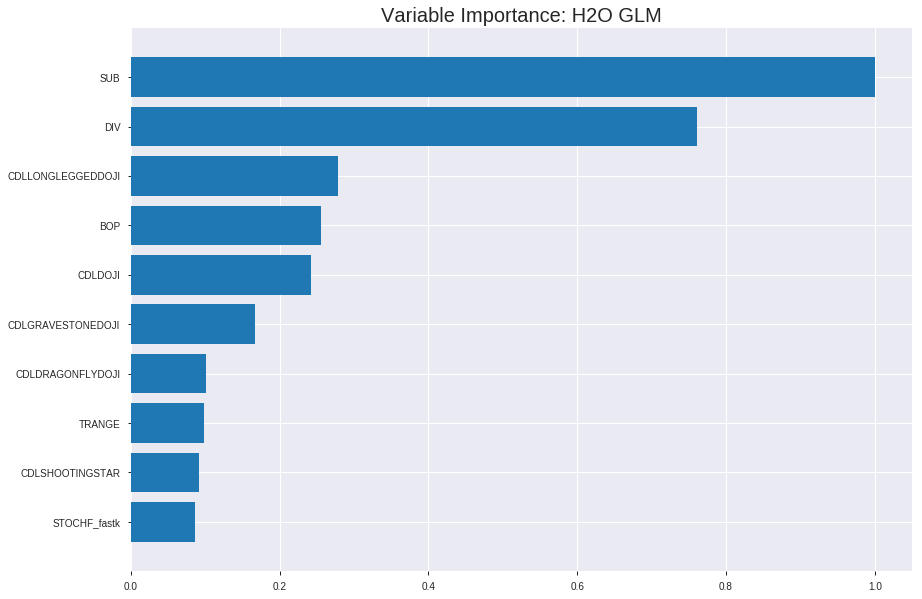

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_105329_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2218760742528386
RMSE: 0.4710372323424536
LogLoss: 0.6333315185345076
Null degrees of freedom: 1788
Residual degrees of freedom: 1738
Null deviance: 2478.6265302036704
Residual deviance: 2266.0601733164685
AIC: 2368.0601733164685
AUC: 0.6894300045029269
pr_auc: 0.6739403946092234
Gini: 0.3788600090058538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3697451901137808: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      259  610   0.702    (610.0/869.0)
1      75   845   0.0815   (75.0/920.0)
Total  334  1455  0.3829   (685.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369745     0.711579  287
max f2                       0.229954     0.845711  352
max f0point5                 0.530277     0.656741  183
max accuracy                 0.530277     0.645053  183
max precision                0.998706     1         0
max recall                   0.0768509    1         393
max specificity              0.998706     1         0
max absolute_mcc             0.530277     0.291862  183
max min_per_class_accuracy   0.521063     0.638665  189
max mean_per_class_accuracy  0.530277     0.645833  183

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.870954           1.7285    1.7285             0.888889         0.93154   0.888889                    0.93154             0.0173913       0.0173913                  72.8502   72.8502
    2        0.020123                    0.84081            1.7285    1.7285             0.888889         0.858815  0.888889                    0.895178            0.0173913       0.0347826                  72.8502   72.8502
    3        0.0301845                   0.816986           1.40441   1.62047            0.722222         0.82732   0.833333                    0.872559            0.0141304       0.048913                   40.4408   62.0471
    4        0.0402459                   0.795024           1.29638   1.53945            0.666667         0.806799  0.791667                    0.856119            0.0130435       0.0619565                  29.6377   53.9447
    5        0.0503074                   0.777466           1.40441   1.51244            0.722222         0.784232  0.777778                    0.841742            0.0141304       0.076087                   40.4408   51.244
    6        0.100056                    0.72292            1.33279   1.42312            0.685393         0.745349  0.731844                    0.793814            0.0663043       0.142391                   33.2792   42.3118
    7        0.150363                    0.677994           1.3828    1.40963            0.711111         0.698916  0.724907                    0.762064            0.0695652       0.211957                   38.2802   40.9629
    8        0.200112                    0.650005           1.31094   1.3851             0.674157         0.662931  0.712291                    0.737419            0.0652174       0.277174                   31.0943   38.5095
    9        0.300168                    0.599284           1.21671   1.32897            0.625698         0.623799  0.683426                    0.699546            0.121739        0.398913                   21.6711   32.8967
    10       0.400224                    0.556797           1.2493    1.30905            0.642458         0.57924   0.673184                    0.669469            0.125           0.523913                   24.9302   30.9051
    11       0.500279                    0.521266           1.11894   1.27103            0.575419         0.538557  0.653631                    0.643287            0.111957        0.63587                    11.894    27.1029
    12       0.599776                    0.485196           0.950434  1.21785            0.488764         0.503847  0.626281                    0.620155            0.0945652       0.730435                   -4.95664  21.7845
    13       0.699832                    0.435202           0.912533  1.17419            0.469274         0.461653  0.603834                    0.597494            0.0913043       0.821739                   -8.74666  17.4194
    14       0.799888                    0.376538           0.836489  1.13195            0.430168         0.40639   0.58211                     0.573589            0.0836957       0.905435                   -16.3511  13.1952
    15       0.899944                    0.299289           0.640946  1.07736            0.329609         0.340112  0.554037                    0.547631            0.0641304       0.969565                   -35.9054  7.73616
    16       1                           0.00162693         0.304178  1                  0.156425         0.214057  0.514254                    0.514255          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2328438751265927
RMSE: 0.48253898819327823
LogLoss: 0.6611395753337407
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 706.5876756969492
Residual deviance: 675.684645991083
AIC: 777.684645991083
AUC: 0.6482896764252697
pr_auc: 0.6520292820998261
Gini: 0.2965793528505394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4562431814616156: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      73   163  0.6907   (163.0/236.0)
1      25   250  0.0909   (25.0/275.0)
Total  98   413  0.3679   (188.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456243     0.726744  313
max f2                       0.0419604    0.853507  399
max f0point5                 0.473868     0.654078  293
max accuracy                 0.473868     0.637965  293
max precision                0.832988     0.8       4
max recall                   0.0419604    1         399
max specificity              0.928637     0.995763  0
max absolute_mcc             0.473868     0.277234  293
max min_per_class_accuracy   0.568768     0.580508  198
max mean_per_class_accuracy  0.473868     0.618867  293

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 55.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.827183           1.23879   1.23879            0.666667         0.86309   0.666667                    0.86309             0.0145455       0.0145455                  23.8788   23.8788
    2        0.0215264                   0.80283            1.48655   1.3514             0.8              0.811493  0.727273                    0.839637            0.0145455       0.0290909                  48.6545   35.1405
    3        0.0313112                   0.786398           1.48655   1.39364            0.8              0.791922  0.75                        0.824726            0.0145455       0.0436364                  48.6545   39.3636
    4        0.0410959                   0.768287           1.11491   1.32727            0.6              0.778372  0.714286                    0.813689            0.0109091       0.0545455                  11.4909   32.7273
    5        0.0508806                   0.759529           0.743273  1.21497            0.4              0.765224  0.653846                    0.804369            0.00727273      0.0618182                  -25.6727  21.4965
    6        0.101761                    0.720338           1.42937   1.32217            0.769231         0.734821  0.711538                    0.769595            0.0727273       0.134545                   42.9371   32.2168
    7        0.150685                    0.690744           1.48655   1.37554            0.8              0.704225  0.74026                     0.748371            0.0727273       0.207273                   48.6545   37.5537
    8        0.201566                    0.663726           1.1435    1.31696            0.615385         0.67558   0.708738                    0.729997            0.0581818       0.265455                   14.3497   31.6964
    9        0.30137                     0.625892           1.20235   1.27901            0.647059         0.644392  0.688312                    0.701647            0.12            0.385455                   20.2353   27.9008
    10       0.401174                    0.596704           1.05661   1.22368            0.568627         0.610276  0.658537                    0.678916            0.105455        0.490909                   5.66132   22.3681
    11       0.500978                    0.569033           0.874439  1.15411            0.470588         0.582808  0.621094                    0.659769            0.0872727       0.578182                   -12.5561  15.4105
    12       0.600783                    0.536332           0.947308  1.11975            0.509804         0.554359  0.602606                    0.642258            0.0945455       0.672727                   -5.26916  11.9751
    13       0.700587                    0.499859           1.27522   1.1419             0.686275         0.520126  0.614525                    0.624859            0.127273        0.8                        27.5223   14.1899
    14       0.800391                    0.460028           0.983743  1.12218            0.529412         0.479278  0.603912                    0.606706            0.0981818       0.898182                   -1.62567  12.2178
    15       0.900196                    0.400887           0.510089  1.05432            0.27451          0.431784  0.567391                    0.587313            0.0509091       0.949091                   -48.9911  5.43162
    16       1                           0.0419604          0.510089  1                  0.27451          0.303651  0.53816                     0.559002         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 10:53:30  0.000 sec   2            .89E1     51            1.3772996090935656  1.3756144960235313
     2019-08-22 10:53:30  0.048 sec   4            .55E1     51            1.373005021045817   1.3719422880317913
     2019-08-22 10:53:30  0.089 sec   6            .34E1     51            1.3669728469160174  1.3668889312957695
     2019-08-22 10:53:30  0.126 sec   8            .21E1     51            1.3590041724764745  1.3604414634540793
     2019-08-22 10:53:30  0.154 sec   10           .13E1     51            1.3492554836308313  1.3529653704446296
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 10:53:30  0.648 sec   45           .15E-3    51            1.2665481438528312  1.3222827990011972
     2019-08-22 10:53:30  0.657 sec   46           .96E-4    51            1.2664960774604284  1.322300872292574
     2019-08-22 10:53:30  0.670 sec   47           .6E-4     51            1.266473351640058   1.3223234310375014
     2019-08-22 10:53:30  0.683 sec   48           .37E-4    51            1.266463015705531   1.3223350274186514
     2019-08-22 10:53:31  0.695 sec   49           .23E-4    51            1.2664583647601713  1.3223417986106683


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.62890625)

('F1', 0.6590909090909091)

('auc', 0.6460774090658161)

('logloss', 0.6720095618846356)

('mean_per_class_error', 0.3864626142427774)

('rmse', 0.49098256631888815)

('mse', 0.2410638804290814)

glm prediction progress: |████████████████████████████████████████████████| 100%


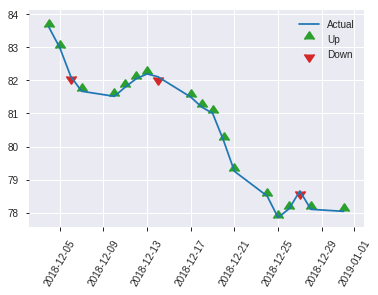


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2410638804290814
RMSE: 0.49098256631888815
LogLoss: 0.6720095618846356
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 356.1260369634925
Residual deviance: 344.0688956849334
AIC: 446.0688956849334
AUC: 0.6460774090658161
pr_auc: 0.6299226466223338
Gini: 0.29215481813163224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40079274342289056: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   117  0.854    (117.0/137.0)
1      3    116  0.0252   (3.0/119.0)
Total  23   233  0.4688   (120.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400793     0.659091  232
max f2                       0.342719     0.82296   246
max f0point5                 0.650691     0.588972  69
max accuracy                 0.650691     0.628906  69
max precision                0.883337     1         0
max recall                   0.342719     1         246
max specificity              0.883337     1         0
max absolute_mcc             0.650691     0.254096  69
max min_per_class_accuracy   0.584345     0.605839  126
max mean_per_class_accuracy  0.650691     0.613537  69

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 56.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.818758           2.15126   2.15126            1                0.864086  1                           0.864086            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.782755           2.15126   2.15126            1                0.791718  1                           0.827902            0.0252101       0.0504202                  115.126   115.126
    3        0.03125                     0.774181           2.15126   2.15126            1                0.775531  1                           0.814809            0.0168067       0.0672269                  115.126   115.126
    4        0.0429688                   0.762458           2.15126   2.15126            1                0.767123  1                           0.801804            0.0252101       0.092437                   115.126   115.126
    5        0.0507812                   0.75525            0         1.8203             0                0.758509  0.846154                    0.795143            0               0.092437                   -100      82.0297
    6        0.101562                    0.714794           1.32385   1.57207            0.615385         0.733591  0.730769                    0.764367            0.0672269       0.159664                   32.3853   57.2075
    7        0.152344                    0.690424           1.65482   1.59966            0.769231         0.699297  0.74359                     0.742677            0.0840336       0.243697                   65.4816   59.9655
    8        0.203125                    0.669735           0.827408  1.40659            0.384615         0.679004  0.653846                    0.726759            0.0420168       0.285714                   -17.2592  40.6593
    9        0.300781                    0.643816           1.37681   1.39692            0.64             0.657231  0.649351                    0.704185            0.134454        0.420168                   37.6807   39.6922
    10       0.402344                    0.611001           0.744667  1.23228            0.346154         0.627564  0.572816                    0.684844            0.0756303       0.495798                   -25.5333  23.2275
    11       0.5                         0.583785           1.20471   1.22689            0.56             0.595377  0.570312                    0.66737             0.117647        0.613445                   20.4706   22.6891
    12       0.601562                    0.550488           0.579186  1.11754            0.269231         0.566004  0.519481                    0.650256            0.0588235       0.672269                   -42.0814  11.7538
    13       0.699219                    0.515302           0.946555  1.09366            0.44             0.531895  0.50838                     0.633725            0.092437        0.764706                   -5.34454  9.36576
    14       0.800781                    0.461987           1.07563   1.09137            0.5              0.493326  0.507317                    0.615918            0.109244        0.87395                    7.56303   9.13712
    15       0.898438                    0.406956           0.860504  1.06628            0.4              0.440866  0.495652                    0.596891            0.0840336       0.957983                   -13.9496  6.62769
    16       1                           0.00226171         0.413704  1                  0.192308         0.323721  0.464844                    0.569147         

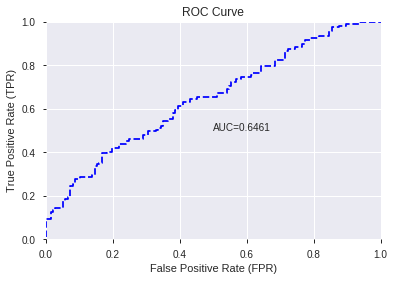

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


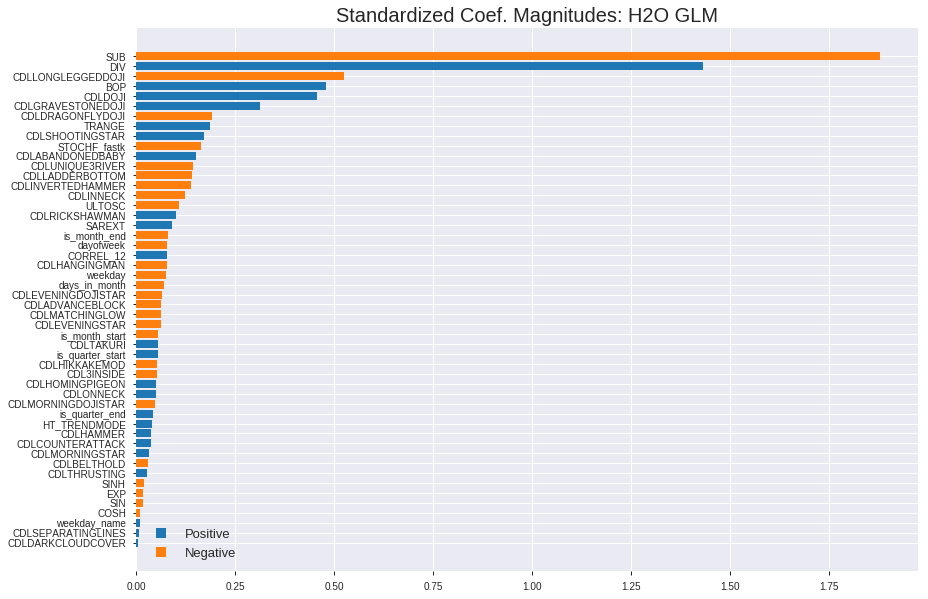

'log_likelihood'
--2019-08-22 10:53:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_105329_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_105329_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['SUB',
 'DIV',
 'CDLLONGLEGGEDDOJI',
 'BOP',
 'CDLDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'TRANGE',
 'CDLSHOOTINGSTAR',
 'STOCHF_fastk',
 'CDLABANDONEDBABY',
 'CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'CDLINVERTEDHAMMER',
 'CDLINNECK',
 'ULTOSC',
 'CDLRICKSHAWMAN',
 'SAREXT',
 'is_month_end',
 'dayofweek',
 'CORREL_12',
 'CDLHANGINGMAN',
 'weekday',
 'days_in_month',
 'CDLEVENINGDOJISTAR',
 'CDLADVANCEBLOCK',
 'CDLMATCHINGLOW',
 'CDLEVENINGSTAR',
 'is_month_start',
 'CDLTAKURI',
 'is_quarter_start',
 'CDLHIKKAKEMOD',
 'CDL3INSIDE',
 'CDLHOMINGPIGEON',
 'CDLONNECK',
 'CDLMORNINGDOJISTAR',
 'is_quarter_end',
 'HT_TRENDMODE',
 'CDLHAMMER',
 'CDLCOUNTERATTACK',
 'CDLMORNINGSTAR',
 'CDLBELTHOLD',
 'CDLTHRUSTING',
 'SINH',
 'EXP',
 'SIN',
 'COSH',
 'weekday_name',
 'CDLSEPARATINGLINES',
 'CDLDARKCLOUDCOVER']

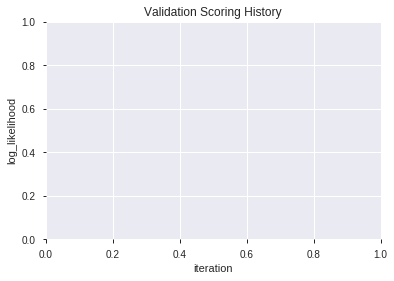

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_105342_model_4  0.644237  0.684433              0.474453  0.495919  0.245935
1  XGBoost_grid_1_AutoML_20190822_105342_model_6  0.617555  0.694647              0.449672  0.500676  0.250676
2  XGBoost_grid_1_AutoML_20190822_105342_model_2  0.616696  0.692134              0.461510  0.499434  0.249434
3  XGBoost_grid_1_AutoML_20190822_105342_model_1  0.616696  0.693412              0.465712  0.500146  0.250146
4               XGBoost_3_AutoML_20190822_105342  0.609152  0.693693              0.485401  0.500140  0.250140
5  XGBoost_grid_1_AutoML_20190822_105342_model_3  0.604735  0.693951              0.468257  0.500405  0.250405
6  XGBoost_grid_1_AutoML_20190822_105342_model_7  0.604551  0.698484              0.460406  0.502265  0.252270
7               XGBoost_1_AutoML_20190822_105342  0.602588  0.694409              0.460958  0.500443  0.250443
8               XGBoost_2_AutoML_20190822_105342  0.598847  0.699866              0.462062  0.503262  0.253272
9  XGBoost_grid_1_AutoML_20190822_105342_model_5  0.577317  0.709438              0.453107  0.507496  0.257552

variable  relative_importance  scaled_importance  percentage
0                 BOP           509.870392           1.000000    0.178059
1                 SUB           477.129059           0.935785    0.166625
2           CORREL_12           255.585373           0.501275    0.089256
3                COSH           249.391647           0.489128    0.087093
4        STOCHF_fastk           226.869873           0.444956    0.079228
5              ULTOSC           206.768692           0.405532    0.072209
6                 DIV           205.793823           0.403620    0.071868
7           dayofweek           144.040619           0.282504    0.050302
8              TRANGE           134.510712           0.263814    0.046974
9                 SIN           118.440216           0.232295    0.041362
10             SAREXT           111.906204           0.219480    0.039080
11  CDLGRAVESTONEDOJI            47.432350           0.093028    0.016564
12  CDLLONGLEGGEDDOJI            39.080967           0.076649    0.013648
13   CDLDRAGONFLYDOJI            38.118477           0.074761    0.013312
14      days_in_month            28.942249           0.056764    0.010107
15       HT_TRENDMODE            25.667072           0.050340    0.008964
16          CDLTAKURI            15.596218           0.030589    0.005447
17            CDLDOJI            13.086958           0.025667    0.004570
18       weekday_name            10.404232           0.020406    0.003633
19     CDLRICKSHAWMAN             4.859129           0.009530    0.001697

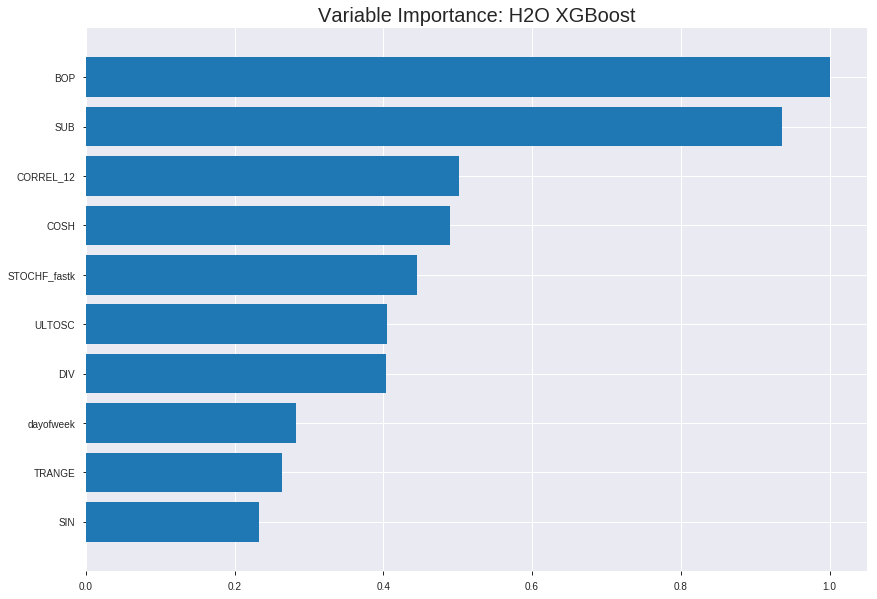

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_105342_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21165046998987105
RMSE: 0.4600548554138637
LogLoss: 0.6136815125587708
Mean Per-Class Error: 0.30192687747035574
AUC: 0.7530038274878671
pr_auc: 0.7454052891625165
Gini: 0.5060076549757342
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.428957536816597: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      355  514   0.5915   (514.0/869.0)
1      92   828   0.1      (92.0/920.0)
Total  447  1342  0.3387   (606.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428958     0.732095  266
max f2                       0.336938     0.854119  335
max f0point5                 0.514906     0.702411  191
max accuracy                 0.506556     0.699832  199
max precision                0.754135     1         0
max recall                   0.246532     1         387
max specificity              0.754135     1         0
max absolute_mcc             0.506556     0.399628  199
max min_per_class_accuracy   0.528948     0.682394  179
max mean_per_class_accuracy  0.506556     0.698073  199

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 51.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.705933           1.94457   1.94457            1                0.72451   1                           0.72451             0.0195652       0.0195652                  94.4565   94.4565
    2        0.020123                    0.695647           1.62047   1.78252            0.833333         0.700183  0.916667                    0.712346            0.0163043       0.0358696                  62.0471   78.2518
    3        0.0301845                   0.684804           1.7285    1.76451            0.888889         0.690183  0.907407                    0.704959            0.0173913       0.0532609                  72.8502   76.4513
    4        0.0402459                   0.676266           1.62047   1.7285             0.833333         0.680316  0.888889                    0.698798            0.0163043       0.0695652                  62.0471   72.8502
    5        0.0503074                   0.672829           1.51244   1.68529            0.777778         0.674467  0.866667                    0.693932            0.0152174       0.0847826                  51.244    68.529
    6        0.100056                    0.652494           1.57313   1.62952            0.808989         0.662163  0.837989                    0.678136            0.0782609       0.163043                   57.3131   62.9524
    7        0.150363                    0.637433           1.53405   1.59758            0.788889         0.644843  0.821561                    0.666997            0.0771739       0.240217                   53.4046   59.758
    8        0.200112                    0.623586           1.31094   1.52632            0.674157         0.630379  0.784916                    0.657894            0.0652174       0.305435                   31.0943   52.6321
    9        0.300168                    0.594571           1.39053   1.48106            0.715084         0.610403  0.761639                    0.642064            0.13913         0.444565                   39.0527   48.1056
    10       0.400224                    0.560314           1.28189   1.43127            0.659218         0.577575  0.736034                    0.625941            0.128261        0.572826                   28.1892   43.1265
    11       0.500279                    0.530234           1.02117   1.34925            0.52514          0.544635  0.693855                    0.60968             0.102174        0.675                      2.11683   34.9246
    12       0.599776                    0.494268           1.04875   1.2994             0.539326         0.512184  0.66822                     0.593507            0.104348        0.779348                   4.87543   29.9397
    13       0.699832                    0.455663           0.814762  1.23011            0.418994         0.475406  0.632588                    0.576622            0.0815217       0.86087                    -18.5238  23.0108
    14       0.799888                    0.402941           0.6844    1.16185            0.351955         0.429851  0.597484                    0.558262            0.0684783       0.929348                   -31.56    16.1847
    15       0.899944                    0.337225           0.521448  1.09065            0.268156         0.369808  0.56087                     0.53731             0.0521739       0.981522                   -47.8552  9.06474
    16       1                           0.216491           0.184679  1                  0.0949721        0.289326  0.514254                    0.512498           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23450373114044393
RMSE: 0.4842558529748958
LogLoss: 0.6612803009355278
Mean Per-Class Error: 0.39513867488443755
AUC: 0.6396995377503852
pr_auc: 0.6576399706071275
Gini: 0.2793990755007705
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39935486018657684: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   199  0.8432   (199.0/236.0)
1      10   265  0.0364   (10.0/275.0)
Total  47   464  0.409    (209.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399355     0.717185  354
max f2                       0.246404     0.854568  397
max f0point5                 0.512883     0.641173  268
max accuracy                 0.512883     0.618395  268
max precision                0.72365      1         0
max recall                   0.246404     1         397
max specificity              0.72365      1         0
max absolute_mcc             0.512883     0.226675  268
max min_per_class_accuracy   0.57855      0.589091  185
max mean_per_class_accuracy  0.546051     0.604861  234

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 55.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.707054           1.23879   1.23879            0.666667         0.715065  0.666667                    0.715065            0.0145455       0.0145455                  23.8788   23.8788
    2        0.0215264                   0.696518           1.85818   1.52033            1                0.699917  0.818182                    0.708179            0.0181818       0.0327273                  85.8182   52.0331
    3        0.0313112                   0.689387           1.11491   1.39364            0.6              0.691897  0.75                        0.703091            0.0109091       0.0436364                  11.4909   39.3636
    4        0.0410959                   0.687949           1.11491   1.32727            0.6              0.688881  0.714286                    0.699708            0.0109091       0.0545455                  11.4909   32.7273
    5        0.0508806                   0.685513           1.85818   1.42937            1                0.686988  0.769231                    0.697262            0.0181818       0.0727273                  85.8182   42.9371
    6        0.101761                    0.671847           1.28643   1.3579             0.692308         0.678174  0.730769                    0.687718            0.0654545       0.138182                   28.6434   35.7902
    7        0.150685                    0.660438           1.48655   1.39967            0.8              0.665687  0.753247                    0.680565            0.0727273       0.210909                   48.6545   39.9669
    8        0.201566                    0.646134           1.3579    1.38913            0.730769         0.654157  0.747573                    0.673899            0.0690909       0.28                       35.7902   38.9126
    9        0.30137                     0.621362           1.02018   1.26694            0.54902          0.633697  0.681818                    0.660585            0.101818        0.381818                   2.01783   26.6942
    10       0.401174                    0.600017           0.983743  1.19649            0.529412         0.612425  0.643902                    0.648604            0.0981818       0.48                       -1.62567  19.6488
    11       0.500978                    0.579548           1.02018   1.16136            0.54902          0.590258  0.625                       0.63698             0.101818        0.581818                   2.01783   16.1364
    12       0.600783                    0.553515           1.09305   1.15001            0.588235         0.565396  0.618893                    0.625088            0.109091        0.690909                   9.30481   15.0015
    13       0.700587                    0.51773            0.947308  1.12114            0.509804         0.537522  0.603352                    0.612614            0.0945455       0.785455                   -5.26916  12.1138
    14       0.800391                    0.465068           0.765134  1.07675            0.411765         0.493966  0.579462                    0.597819            0.0763636       0.861818                   -23.4866  7.67459
    15       0.900196                    0.405849           0.910873  1.05836            0.490196         0.434741  0.569565                    0.579739            0.0909091       0.952727                   -8.91266  5.83557
    16       1                           0.227108           0.473654  1                  0.254902         0.344274  0.53816                     0.556238         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 10:53:53  3.870 sec   0                  0.5              0.693147            0.5             0                  1                0.485746                         0.5                0.693147              0.5               0                    1                  0.46184
    2019-08-22 10:53:53  4.018 sec   5                  0.491034         0.675333            0.68852         0.64739            1.41901          0.386808                         0.49459            0.682366              0.622874          0.633023             1.32727            0.446184
    2019-08-22 10:53:53  4.103 sec   10                 0.484278         0.661968            0.699121        0.681489           1.51919          0.396311                         0.49204            0.677257              0.611302          0.635746             1.62591            0.446184
    2019-08-22 10:53:53  4.188 sec   15                 0.479513         0.652532            0.707449        0.684424           1.47519          0.399665                         0.489551           0.67226               0.625655          0.647929             1.23879            0.446184
    2019-08-22 10:53:53  4.273 sec   20                 0.475089         0.643719            0.715766        0.697921           1.62047          0.379542                         0.488007           0.669122              0.63104           0.656622             1.54848            0.446184
    2019-08-22 10:53:53  4.377 sec   25                 0.472093         0.637741            0.721793        0.704861           1.65288          0.367803                         0.487538           0.668132              0.630123          0.65308              1.23879            0.430528
    2019-08-22 10:53:53  4.464 sec   30                 0.469329         0.632245            0.730457        0.722055           1.94457          0.34768                          0.486706           0.666418              0.62953           0.646767             0.929091           0.41683
    2019-08-22 10:53:53  4.566 sec   35                 0.466718         0.62698             0.736527        0.728021           1.83653          0.34265                          0.486336           0.665581              0.631025          0.651136             1.23879            0.418787
    2019-08-22 10:53:54  4.667 sec   40                 0.464212         0.622004            0.743756        0.735162           1.83653          0.34265                          0.486314           0.665499              0.6297            0.648879             1.23879            0.424658
    2019-08-22 10:53:54  4.762 sec   45                 0.462113         0.617826            0.748659        0.739025           1.94457          0.332588                         0.485239           0.663326              0.635478          0.653808             1.23879            0.409002
    2019-08-22 10:53:54  4.862 sec   50                 0.460055         0.613682            0.753004        0.745405           1.94457          0.338737                         0.484256           0.66128               0.6397            0.65764              1.23879            0.409002

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
BOP                509.87                 1                    0.178059
SUB                477.129                0.935785             0.166625
CORREL_12          255.585                0.501275             0.0892565
COSH               249.392                0.489128             0.0870935
STOCHF_fastk       226.87                 0.444956             0.0792283
ULTOSC             206.769                0.405532             0.0722085
DIV                205.794                0.40362              0.0718681
dayofweek          144.041                0.282504             0.0503024
TRANGE             134.511                0.263814             0.0469743
SIN                118.44                 0.232295             0.0413621
SAREXT             111.906                0.21948              0.0390803
CDLGRAVESTONEDOJI  47.4324                0.0930282            0.0165645
CDLLONGLEGGEDDOJI  39.081                 0.0766488            0.013648
CDLDRAGONFLYDOJI   38.1185                0.0747611            0.0133119
days_in_month      28.9422                0.0567639            0.0101073
HT_TRENDMODE       25.6671                0.0503404            0.00896355
CDLTAKURI          15.5962                0.0305886            0.00544657
CDLDOJI            13.087                 0.0256672            0.00457028
weekday_name       10.4042                0.0204056            0.0036334
CDLRICKSHAWMAN     4.85913                0.00953013           0.00169692

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.62890625)

('F1', 0.6467391304347826)

('auc', 0.6442372569465743)

('logloss', 0.6844326206684973)

('mean_per_class_error', 0.37486965589155374)

('rmse', 0.4959187275958527)

('mse', 0.24593538438028956)

xgboost prediction progress: |████████████████████████████████████████████| 100%


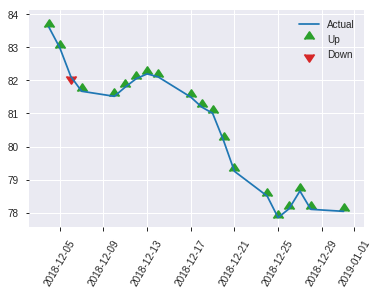


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24593538438028956
RMSE: 0.4959187275958527
LogLoss: 0.6844326206684973
Mean Per-Class Error: 0.37486965589155374
AUC: 0.6442372569465743
pr_auc: 0.6219386385407946
Gini: 0.2884745138931486
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.362064003944397: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    130  0.9489   (130.0/137.0)
1      0    119  0        (0.0/119.0)
Total  7    249  0.5078   (130.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362064     0.646739  248
max f2                       0.362064     0.82069   248
max f0point5                 0.60203      0.599647  111
max accuracy                 0.60203      0.628906  111
max precision                0.746214     1         0
max recall                   0.362064     1         248
max specificity              0.746214     1         0
max absolute_mcc             0.60203      0.251615  111
max min_per_class_accuracy   0.591103     0.605839  126
max mean_per_class_accuracy  0.60203      0.62513   111

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 56.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.720259           2.15126   2.15126            1                0.739985  1                           0.739985            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.699819           1.43417   1.79272            0.666667         0.703653  0.833333                    0.721819            0.0168067       0.0420168                  43.4174   79.2717
    3        0.03125                     0.68758            2.15126   1.88235            1                0.693255  0.875                       0.714678            0.0168067       0.0588235                  115.126   88.2353
    4        0.0429688                   0.684889           2.15126   1.95569            1                0.685785  0.909091                    0.706798            0.0252101       0.0840336                  115.126   95.5691
    5        0.0507812                   0.682537           1.07563   1.8203             0.5              0.684263  0.846154                    0.703331            0.00840336      0.092437                   7.56303   82.0297
    6        0.101562                    0.669132           1.48933   1.65482            0.692308         0.675862  0.769231                    0.689597            0.0756303       0.168067                   48.9334   65.4816
    7        0.152344                    0.657944           1.32385   1.54449            0.615385         0.662786  0.717949                    0.68066             0.0672269       0.235294                   32.3853   54.4495
    8        0.203125                    0.647464           1.15837   1.44796            0.538462         0.652373  0.673077                    0.673588            0.0588235       0.294118                   15.8371   44.7964
    9        0.300781                    0.626961           1.03261   1.31311            0.48             0.638883  0.61039                     0.66232             0.10084         0.394958                   3.2605    31.3107
    10       0.402344                    0.606021           1.24111   1.29493            0.576923         0.617191  0.601942                    0.650928            0.12605         0.521008                   24.1112   29.4934
    11       0.5                         0.590487           1.03261   1.2437             0.48             0.5998    0.578125                    0.640942            0.10084         0.621849                   3.2605    24.3697
    12       0.601562                    0.559536           0.827408  1.17341            0.384615         0.575836  0.545455                    0.62995             0.0840336       0.705882                   -17.2592  17.3415
    13       0.699219                    0.530136           0.860504  1.12971            0.4              0.542532  0.52514                     0.617741            0.0840336       0.789916                   -13.9496  12.9712
    14       0.800781                    0.492303           0.579186  1.05989            0.269231         0.512394  0.492683                    0.60438             0.0588235       0.848739                   -42.0814  5.98893
    15       0.898438                    0.452341           0.774454  1.02886            0.36             0.470379  0.478261                    0.589815            0.0756303       0.92437                    -22.5546  2.88637
    16       1                           0.28779            0.744667  1                  0.346154         0.391306  0.464844                    0.569654         

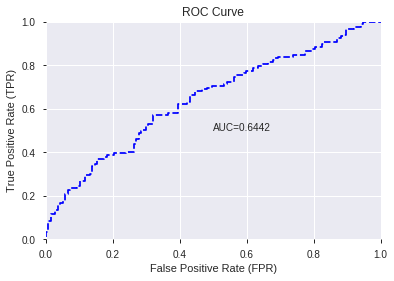

This function is available for GLM models only


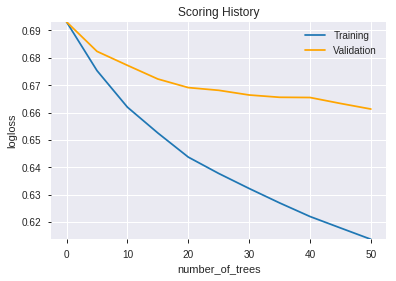

--2019-08-22 10:54:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_105342_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_105342_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'CORREL_12',
 'COSH',
 'STOCHF_fastk',
 'ULTOSC',
 'DIV',
 'dayofweek',
 'TRANGE',
 'SIN',
 'SAREXT',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLDRAGONFLYDOJI',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'CDLDOJI',
 'weekday_name',
 'CDLRICKSHAWMAN']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_105414_model_1  0.678832  0.684504               0.41704  0.496018  0.246034

variable  relative_importance  scaled_importance    percentage
0                         BOP         1.209993e-01           1.000000  3.136150e-02
1                         SUB         9.224459e-02           0.762356  2.390864e-02
2                         DIV         7.635775e-02           0.631059  1.979097e-02
3                 CDLBELTHOLD         5.508111e-02           0.455218  1.427633e-02
4           CDLGRAVESTONEDOJI         5.180698e-02           0.428159  1.342772e-02
...                       ...                  ...                ...           ...
1020                 MAVP_8_6         4.678390e-06           0.000039  1.212580e-06
1021  BBANDS_lowerband_24_3_2         4.444608e-06           0.000037  1.151986e-06
1022  BBANDS_upperband_14_2_2         3.545289e-06           0.000029  9.188943e-07
1023  BBANDS_lowerband_20_3_3         2.649977e-06           0.000022  6.868408e-07
1024                   WMA_20         8.456417e-07           0.000007  2.191797e-07

[1025 rows x 4 columns]

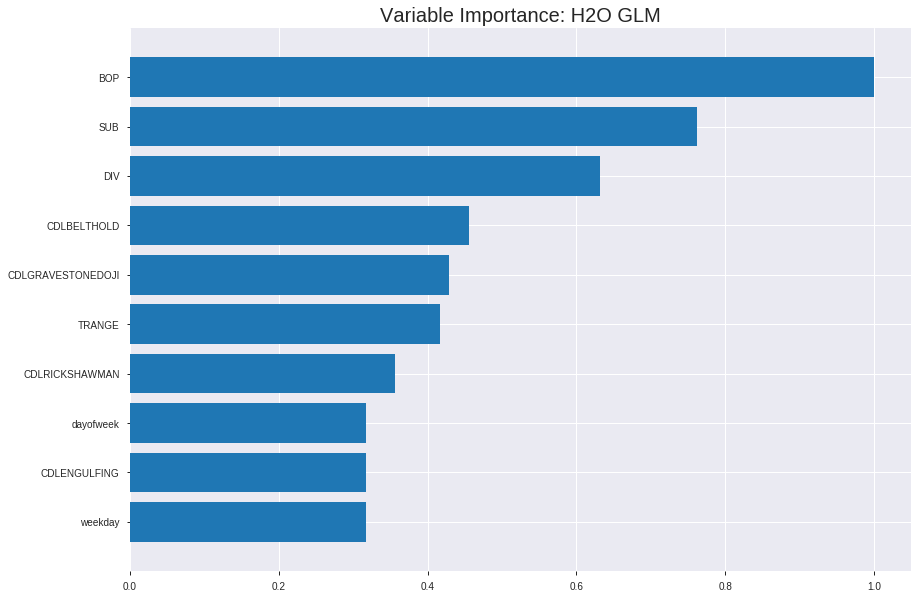

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_105414_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2264777476877845
RMSE: 0.47589678259868967
LogLoss: 0.6443165740653385
Null degrees of freedom: 1788
Residual degrees of freedom: 763
Null deviance: 2478.6265302036704
Residual deviance: 2305.3647020057806
AIC: 4357.364702005781
AUC: 0.6886620053034472
pr_auc: 0.6772822569481229
Gini: 0.37732401060689447
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.423976654152708: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      233  636   0.7319   (636.0/869.0)
1      59   861   0.0641   (59.0/920.0)
Total  292  1497  0.3885   (695.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423977     0.712453  291
max f2                       0.347661     0.846984  348
max f0point5                 0.500027     0.649038  208
max accuracy                 0.500027     0.642258  208
max precision                0.816079     1         0
max recall                   0.26587      1         382
max specificity              0.816079     1         0
max absolute_mcc             0.466669     0.286102  247
max min_per_class_accuracy   0.520454     0.627158  183
max mean_per_class_accuracy  0.500027     0.639575  208

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.719199           1.7285    1.7285             0.888889         0.754099  0.888889                    0.754099            0.0173913       0.0173913                  72.8502   72.8502
    2        0.020123                    0.696596           1.62047   1.67449            0.833333         0.707478  0.861111                    0.730788            0.0163043       0.0336957                  62.0471   67.4487
    3        0.0301845                   0.683861           1.62047   1.65648            0.833333         0.690371  0.851852                    0.717316            0.0163043       0.05                       62.0471   65.6481
    4        0.0402459                   0.671813           1.08031   1.51244            0.555556         0.679037  0.777778                    0.707746            0.0108696       0.0608696                  8.0314    51.244
    5        0.0503074                   0.659341           1.51244   1.51244            0.777778         0.665105  0.777778                    0.699218            0.0152174       0.076087                   51.244    51.244
    6        0.100056                    0.628125           1.33279   1.42312            0.685393         0.643152  0.731844                    0.671341            0.0663043       0.142391                   33.2792   42.3118
    7        0.150363                    0.607718           1.46923   1.43854            0.755556         0.617421  0.739777                    0.653301            0.073913        0.216304                   46.9227   43.8545
    8        0.200112                    0.595054           1.26724   1.39596            0.651685         0.601151  0.717877                    0.640336            0.0630435       0.279348                   26.7245   39.5959
    9        0.300168                    0.566649           1.28189   1.35794            0.659218         0.580417  0.698324                    0.620363            0.128261        0.407609                   28.1892   35.7937
    10       0.400224                    0.54153            1.1298    1.3009             0.581006         0.554218  0.668994                    0.603827            0.113043        0.520652                   12.9803   30.0903
    11       0.500279                    0.520757           1.05376   1.25147            0.541899         0.530552  0.643575                    0.589172            0.105435        0.626087                   5.37588   25.1474
    12       0.599776                    0.499362           1.08153   1.22328            0.55618          0.510136  0.629077                    0.576061            0.107609        0.733696                   8.15278   22.3282
    13       0.699832                    0.474117           0.879943  1.17419            0.452514         0.4873    0.603834                    0.563371            0.0880435       0.821739                   -12.0057  17.4194
    14       0.799888                    0.43759            0.858216  1.13467            0.441341         0.456851  0.583508                    0.550046            0.0858696       0.907609                   -14.1784  13.4669
    15       0.899944                    0.387804           0.597492  1.07495            0.307263         0.416351  0.552795                    0.535182            0.0597826       0.967391                   -40.2508  7.4946
    16       1                           0.0311652          0.325905  1                  0.167598         0.326017  0.514254                    0.514254            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23911364267246846
RMSE: 0.4889924771123462
LogLoss: 0.671242265114581
Null degrees of freedom: 510
Residual degrees of freedom: -515
Null deviance: 706.5876756969492
Residual deviance: 686.0095949471017
AIC: 2738.0095949471015
AUC: 0.6072573189522342
pr_auc: 0.6207537701879191
Gini: 0.21451463790446845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4567730780444474: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      47   189  0.8008   (189.0/236.0)
1      13   262  0.0473   (13.0/275.0)
Total  60   451  0.3953   (202.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456773     0.721763  342
max f2                       0.327987     0.855181  390
max f0point5                 0.456773     0.630111  342
max accuracy                 0.456773     0.604697  342
max precision                0.724921     1         0
max recall                   0.114961     1         398
max specificity              0.724921     1         0
max absolute_mcc             0.456773     0.235211  342
max min_per_class_accuracy   0.558613     0.574545  188
max mean_per_class_accuracy  0.55392      0.580578  200

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 55.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.699901           1.54848   1.54848            0.833333         0.712954  0.833333                    0.712954            0.0181818       0.0181818                  54.8485   54.8485
    2        0.0215264                   0.691141           0.371636  1.01355            0.2              0.694001  0.545455                    0.704339            0.00363636      0.0218182                  -62.8364  1.35537
    3        0.0313112                   0.684116           1.11491   1.04523            0.6              0.687458  0.5625                      0.699064            0.0109091       0.0327273                  11.4909   4.52273
    4        0.0410959                   0.674524           1.48655   1.1503             0.8              0.677872  0.619048                    0.694018            0.0145455       0.0472727                  48.6545   15.0303
    5        0.0508806                   0.662848           1.48655   1.21497            0.8              0.667456  0.653846                    0.68891             0.0145455       0.0618182                  48.6545   21.4965
    6        0.101761                    0.638148           1.57231   1.39364            0.846154         0.647882  0.75                        0.668396            0.08            0.141818                   57.2308   39.3636
    7        0.150685                    0.627006           1.11491   1.30314            0.6              0.632981  0.701299                    0.656898            0.0545455       0.196364                   11.4909   30.314
    8        0.201566                    0.618713           1.07203   1.2448             0.576923         0.62331   0.669903                    0.648419            0.0545455       0.250909                   7.2028    24.4801
    9        0.30137                     0.59818            0.983743  1.15835            0.529412         0.608584  0.623377                    0.635227            0.0981818       0.349091                   -1.62567  15.8347
    10       0.401174                    0.581497           1.16592   1.16023            0.627451         0.590269  0.62439                     0.624042            0.116364        0.465455                   16.5918   16.0231
    11       0.500978                    0.559353           1.05661   1.13959            0.568627         0.570486  0.613281                    0.613373            0.105455        0.570909                   5.66132   13.9588
    12       0.600783                    0.543729           0.910873  1.10159            0.490196         0.551272  0.592834                    0.603057            0.0909091       0.661818                   -8.91266  10.1593
    13       0.700587                    0.518287           0.983743  1.0848             0.529412         0.531948  0.583799                    0.592927            0.0981818       0.76                       -1.62567  8.48045
    14       0.800391                    0.488468           0.910873  1.06312            0.490196         0.503845  0.572127                    0.581819            0.0909091       0.850909                   -8.91266  6.31162
    15       0.900196                    0.452358           1.09305   1.06643            0.588235         0.469738  0.573913                    0.569392            0.109091        0.96                       9.30481   6.64348
    16       1                           0.0463528          0.400784  1                  0.215686         0.374804  0.53816                     0.549971          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 10:54:18  0.000 sec   2            8.9       1026          1.36808           1.37205
    2019-08-22 10:54:20  2.541 sec   4            6.4       1026          1.36398           1.36943
    2019-08-22 10:54:23  4.780 sec   6            4.7       1026          1.35896           1.36638
    2019-08-22 10:54:25  7.097 sec   8            3.4       1026          1.35294           1.36293
    2019-08-22 10:54:27  9.352 sec   10           2.5       1026          1.3459            1.35919
    2019-08-22 10:54:30  11.703 sec  12           1.8       1026          1.33788           1.35531
    2019-08-22 10:54:32  14.154 sec  14           1.3       1026          1.329             1.35154
    2019-08-22 10:54:34  16.405 sec  16           0.96      1026          1.31944           1.34812
    2019-08-22 10:54:37  18.690 sec  18           0.7       1026          1.30939           1.34533
    2019-08-22 10:54:39  20.959 sec  20           0.51      1026          1.29905           1.34338
    2019-08-22 10:54:41  23.209 sec  22           0.37      1026          1.28863           1.34248
    2019-08-22 10:54:43  25.431 sec  24           0.27      1026          1.27832           1.3428
    2019-08-22 10:54:46  27.661 sec  26           0.2       1026          1.26821           1.34429
    2019-08-22 10:54:48  30.049 sec  28           0.14      1026          1.25841           1.34689
    2019-08-22 10:54:50  32.353 sec  30           0.1       1026          1.24902           1.35044
    2019-08-22 10:54:53  34.596 sec  32           0.076     1026          1.24012           1.35482

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6640625)

('F1', 0.65)

('auc', 0.6788321167883211)

('logloss', 0.6845036810009327)

('mean_per_class_error', 0.35008894068576335)

('rmse', 0.496018302310636)

('mse', 0.24603415622712546)

glm prediction progress: |████████████████████████████████████████████████| 100%


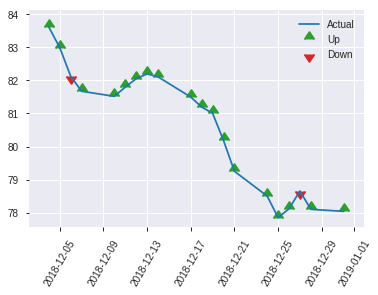


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24603415622712546
RMSE: 0.496018302310636
LogLoss: 0.6845036810009327
Null degrees of freedom: 255
Residual degrees of freedom: -770
Null deviance: 356.1260369634925
Residual deviance: 350.46588467247756
AIC: 2402.4658846724774
AUC: 0.6788321167883211
pr_auc: 0.654769715924893
Gini: 0.35766423357664223
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5307334458908411: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      40   97   0.708    (97.0/137.0)
1      15   104  0.1261   (15.0/119.0)
Total  55   201  0.4375   (112.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.530733     0.65      200
max f2                       0.391585     0.817308  251
max f0point5                 0.621529     0.644769  72
max accuracy                 0.621529     0.664062  72
max precision                0.762615     1         0
max recall                   0.391585     1         251
max specificity              0.762615     1         0
max absolute_mcc             0.621529     0.330741  72
max min_per_class_accuracy   0.590184     0.635036  125
max mean_per_class_accuracy  0.612585     0.649911  87

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 57.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.710421           2.15126   2.15126            1                0.737541  1                           0.737541            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.692454           2.15126   2.15126            1                0.698789  1                           0.718165            0.0252101       0.0504202                  115.126   115.126
    3        0.03125                     0.68542            2.15126   2.15126            1                0.688163  1                           0.710664            0.0168067       0.0672269                  115.126   115.126
    4        0.0429688                   0.680438           0.717087  1.76012            0.333333         0.68327   0.818182                    0.703193            0.00840336      0.0756303                  -28.2913  76.0122
    5        0.0507812                   0.67528            2.15126   1.8203             1                0.676612  0.846154                    0.699104            0.0168067       0.092437                   115.126   82.0297
    6        0.101562                    0.660894           1.32385   1.57207            0.615385         0.665755  0.730769                    0.682429            0.0672269       0.159664                   32.3853   57.2075
    7        0.152344                    0.646525           1.48933   1.54449            0.692308         0.652611  0.717949                    0.67249             0.0756303       0.235294                   48.9334   54.4495
    8        0.203125                    0.635073           1.8203    1.61345            0.846154         0.640996  0.75                        0.664616            0.092437        0.327731                   82.0297   61.3445
    9        0.300781                    0.617462           1.20471   1.48074            0.56             0.626679  0.688312                    0.652299            0.117647        0.445378                   20.4706   48.0738
    10       0.402344                    0.603198           1.07563   1.37848            0.5              0.611109  0.640777                    0.641901            0.109244        0.554622                   7.56303   37.8478
    11       0.5                         0.587848           0.946555  1.29412            0.44             0.595577  0.601562                    0.632854            0.092437        0.647059                   -5.34454  29.4118
    12       0.601562                    0.568683           0.910149  1.22929            0.423077         0.577299  0.571429                    0.623474            0.092437        0.739496                   -8.98513  22.9292
    13       0.699219                    0.549959           0.430252  1.11769            0.2              0.55952   0.519553                    0.614542            0.0420168       0.781513                   -56.9748  11.7694
    14       0.800781                    0.525618           0.910149  1.09137            0.423077         0.539288  0.507317                    0.604998            0.092437        0.87395                    -8.98513  9.13712
    15       0.898438                    0.484989           0.516303  1.02886            0.24             0.50728   0.478261                    0.594376            0.0504202       0.92437                    -48.3697  2.88637
    16       1                           0.328011           0.744667  1                  0.346154         0.434691  0.464844                    0.578158         

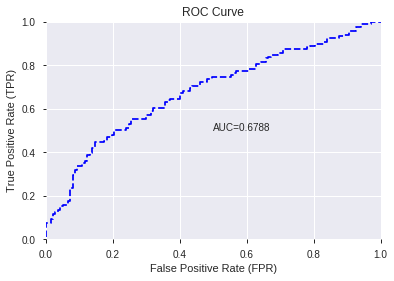

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


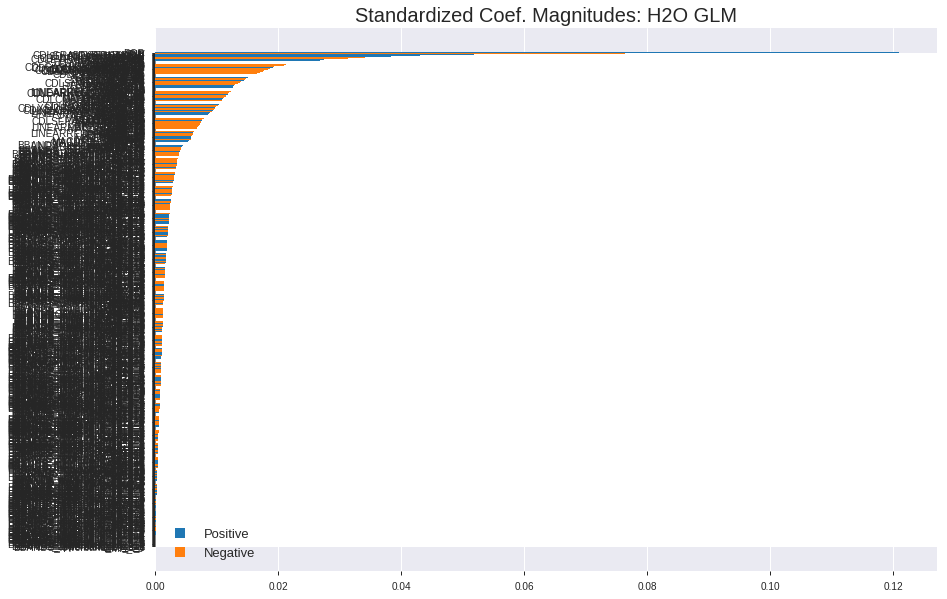

'log_likelihood'
--2019-08-22 10:55:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_105414_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_105414_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

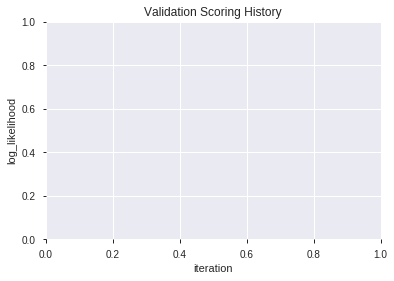

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_105528_model_4  0.629025  0.681942              0.455867  0.494536  0.244566
1  XGBoost_grid_1_AutoML_20190822_105528_model_3  0.626265  0.696972              0.426885  0.501721  0.251724
2               XGBoost_2_AutoML_20190822_105528  0.625222  0.693626              0.425228  0.500076  0.250076
3  XGBoost_grid_1_AutoML_20190822_105528_model_2  0.623137  0.686782              0.443262  0.496701  0.246712
4  XGBoost_grid_1_AutoML_20190822_105528_model_1  0.611360  0.691817              0.449457  0.499024  0.249025
5               XGBoost_3_AutoML_20190822_105528  0.609152  0.694661              0.453659  0.500302  0.250302
6  XGBoost_grid_1_AutoML_20190822_105528_model_6  0.601730  0.696511              0.482304  0.501507  0.251509
7  XGBoost_grid_1_AutoML_20190822_105528_model_5  0.594246  0.730715              0.471355  0.514908  0.265130
8               XGBoost_1_AutoML_20190822_105528  0.583942  0.706614              0.489603  0.505792  0.255826
9  XGBoost_grid_1_AutoML_20190822_105528_model_7  0.577317  0.715959              0.455315  0.509903  0.260001

variable  relative_importance  scaled_importance  percentage
0                        SUB           503.876221           1.000000    0.127102
1                        BOP           411.945526           0.817553    0.103913
2               STOCHF_fastk           143.455460           0.284704    0.036187
3                        DIV           129.622284           0.257250    0.032697
4                     ULTOSC           101.276749           0.200995    0.025547
..                       ...                  ...                ...         ...
149  BBANDS_lowerband_14_6_5             5.574457           0.011063    0.001406
150             weekday_name             5.551924           0.011018    0.001400
151              MINUS_DM_24             5.218675           0.010357    0.001316
152  BBANDS_upperband_24_0_3             5.003844           0.009931    0.001262
153              AROONOSC_12             4.426386           0.008785    0.001117

[154 rows x 4 columns]

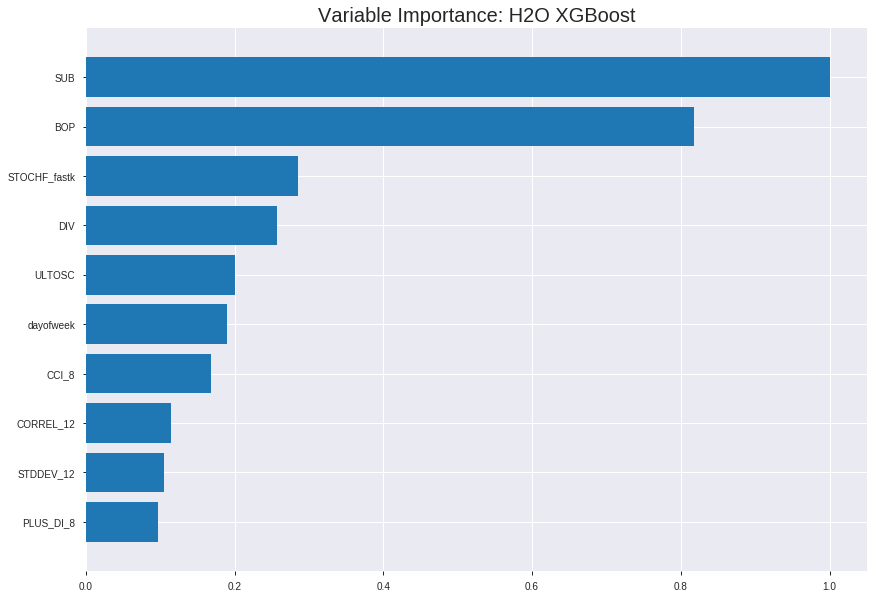

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_105528_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19950840851845328
RMSE: 0.4466636413661328
LogLoss: 0.5882874706056356
Mean Per-Class Error: 0.2552909391104218
AUC: 0.8183062740781508
pr_auc: 0.8225534082323275
Gini: 0.6366125481563016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4687466621398926: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      480  389   0.4476   (389.0/869.0)
1      108  812   0.1174   (108.0/920.0)
Total  588  1201  0.2778   (497.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468747     0.765677  243
max f2                       0.367936     0.865697  319
max f0point5                 0.552521     0.761658  163
max accuracy                 0.525871     0.74455   187
max precision                0.790962     1         0
max recall                   0.235463     1         390
max specificity              0.790962     1         0
max absolute_mcc             0.525871     0.489221  187
max min_per_class_accuracy   0.523461     0.742232  189
max mean_per_class_accuracy  0.525871     0.744709  187

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 51.25 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.729089           1.94457    1.94457            1                0.746833  1                           0.746833            0.0195652       0.0195652                  94.4565   94.4565
    2        0.020123                    0.712544           1.94457    1.94457            1                0.721306  1                           0.73407             0.0195652       0.0391304                  94.4565   94.4565
    3        0.0301845                   0.702491           1.94457    1.94457            1                0.707011  1                           0.72505             0.0195652       0.0586957                  94.4565   94.4565
    4        0.0402459                   0.694503           1.94457    1.94457            1                0.698806  1                           0.718489            0.0195652       0.0782609                  94.4565   94.4565
    5        0.0503074                   0.685033           1.94457    1.94457            1                0.689085  1                           0.712608            0.0195652       0.0978261                  94.4565   94.4565
    6        0.100056                    0.657248           1.68238    1.8142             0.865169         0.670205  0.932961                    0.691525            0.0836957       0.181522                   68.2377   81.4203
    7        0.150363                    0.634074           1.66368    1.76384            0.855556         0.646222  0.907063                    0.676368            0.0836957       0.265217                   66.3684   76.3844
    8        0.200112                    0.615028           1.46389    1.68927            0.752809         0.624462  0.868715                    0.663464            0.0728261       0.338043                   46.3886   68.9273
    9        0.300168                    0.583227           1.49916    1.6259             0.77095          0.600554  0.836127                    0.642494            0.15            0.488043                   49.9162   62.5903
    10       0.400224                    0.555868           1.34707    1.5562             0.692737         0.569165  0.800279                    0.624162            0.134783        0.622826                   34.7073   55.6195
    11       0.500279                    0.525679           1.14067    1.47309            0.586592         0.540308  0.757542                    0.607391            0.11413         0.736957                   14.0667   47.309
    12       0.599776                    0.493406           0.863037   1.37189            0.44382          0.509557  0.705499                    0.591161            0.0858696       0.822826                   -13.6963  37.1888
    13       0.699832                    0.456927           0.760444   1.28447            0.391061         0.476815  0.660543                    0.574813            0.076087        0.898913                   -23.9556  28.4469
    14       0.799888                    0.408025           0.586629   1.19718            0.301676         0.433701  0.615653                    0.557162            0.0586957       0.957609                   -41.3371  19.7178
    15       0.899944                    0.344736           0.336768   1.10152            0.173184         0.377925  0.56646                     0.537234            0.0336957       0.991304                   -66.3232  10.1518
    16       1                           0.175161           0.0869079  1                  0.0446927        0.289821  0.514254                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23484621180227983
RMSE: 0.48460933936757744
LogLoss: 0.6620316940508484
Mean Per-Class Error: 0.3956471494607088
AUC: 0.622904468412943
pr_auc: 0.6282025679194051
Gini: 0.245808936825886
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4540488123893738: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      64   172  0.7288   (172.0/236.0)
1      23   252  0.0836   (23.0/275.0)
Total  87   424  0.3816   (195.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454049     0.72103   318
max f2                       0.38272      0.862287  371
max f0point5                 0.475601     0.645076  305
max accuracy                 0.475601     0.626223  305
max precision                0.747801     1         0
max recall                   0.28567      1         393
max specificity              0.747801     1         0
max absolute_mcc             0.473968     0.258616  306
max min_per_class_accuracy   0.557709     0.588983  191
max mean_per_class_accuracy  0.475601     0.604353  305

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 54.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.736861           1.54848   1.54848            0.833333         0.741023  0.833333                    0.741023            0.0181818       0.0181818                  54.8485   54.8485
    2        0.0215264                   0.716042           0.371636  1.01355            0.2              0.723649  0.545455                    0.733126            0.00363636      0.0218182                  -62.8364  1.35537
    3        0.0313112                   0.700861           1.85818   1.2775             1                0.705034  0.6875                      0.724347            0.0181818       0.04                       85.8182   27.75
    4        0.0410959                   0.689847           1.11491   1.23879            0.6              0.694175  0.666667                    0.717163            0.0109091       0.0509091                  11.4909   23.8788
    5        0.0508806                   0.677776           1.48655   1.28643            0.8              0.683403  0.692308                    0.710671            0.0145455       0.0654545                  48.6545   28.6434
    6        0.101761                    0.659383           1.07203   1.17923            0.576923         0.668025  0.634615                    0.689348            0.0545455       0.12                       7.2028    17.9231
    7        0.150685                    0.644566           1.18924   1.18248            0.64             0.651809  0.636364                    0.67716             0.0581818       0.178182                   18.9236   18.2479
    8        0.201566                    0.630886           1.42937   1.2448             0.769231         0.63772   0.669903                    0.667204            0.0727273       0.250909                   42.9371   24.4801
    9        0.30137                     0.60465            1.12948   1.20661            0.607843         0.617683  0.649351                    0.650804            0.112727        0.363636                   12.9483   20.6612
    10       0.401174                    0.581938           1.09305   1.17836            0.588235         0.592291  0.634146                    0.636247            0.109091        0.472727                   9.30481   17.8359
    11       0.500978                    0.558006           1.09305   1.16136            0.588235         0.568973  0.625                       0.622845            0.109091        0.581818                   9.30481   16.1364
    12       0.600783                    0.532603           0.874439  1.1137             0.470588         0.545852  0.599349                    0.610055            0.0872727       0.669091                   -12.5561  11.3699
    13       0.700587                    0.501798           0.947308  1.08999            0.509804         0.517964  0.586592                    0.596936            0.0945455       0.763636                   -5.26916  8.99949
    14       0.800391                    0.472149           1.31166   1.11764            0.705882         0.488702  0.601467                    0.583439            0.130909        0.894545                   31.1658   11.7635
    15       0.900196                    0.412596           0.582959  1.05836            0.313725         0.44262   0.569565                    0.567827            0.0581818       0.952727                   -41.7041  5.83557
    16       1                           0.208761           0.473654  1                  0.254902         0.355931  0.53816                     0.546679           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 10:56:01  13.618 sec  0                  0.5              0.693147            0.5             0                  1                0.485746                         0.5                0.693147              0.5               0                    1                  0.46184
    2019-08-22 10:56:02  14.892 sec  5                  0.490143         0.67358             0.711627        0.705803           1.80052          0.363331                         0.494213           0.681614              0.632404          0.648696             0.796364           0.420744
    2019-08-22 10:56:03  15.278 sec  10                 0.481941         0.657436            0.737564        0.73067            1.83653          0.346003                         0.492253           0.677667              0.612165          0.644476             1.54848            0.428571
    2019-08-22 10:56:03  15.682 sec  15                 0.475284         0.644379            0.756974        0.747647           1.94457          0.347121                         0.490407           0.673928              0.609422          0.637746             1.85818            0.414873
    2019-08-22 10:56:04  16.067 sec  20                 0.46992          0.633836            0.767713        0.761092           1.94457          0.323086                         0.488493           0.670062              0.616163          0.643209             1.85818            0.405088
    2019-08-22 10:56:04  16.458 sec  25                 0.465119         0.624417            0.777562        0.773918           1.83653          0.326439                         0.48686            0.666784              0.624091          0.633589             1.85818            0.39726
    2019-08-22 10:56:04  16.845 sec  30                 0.461612         0.617503            0.783821        0.782068           1.94457          0.290665                         0.485537           0.664071              0.629753          0.640353             1.54848            0.405088
    2019-08-22 10:56:05  17.277 sec  35                 0.456976         0.608426            0.795273        0.795872           1.94457          0.272219                         0.486265           0.665407              0.618937          0.630537             1.54848            0.414873
    2019-08-22 10:56:05  17.689 sec  40                 0.453327         0.601212            0.801358        0.804134           1.94457          0.281722                         0.485195           0.663193              0.623367          0.635093             1.85818            0.405088
    2019-08-22 10:56:06  18.084 sec  45                 0.449873         0.594533            0.81104         0.815914           1.94457          0.280604                         0.48499            0.662735              0.623436          0.635218             1.85818            0.412916
    2019-08-22 10:56:06  18.500 sec  50                 0.446664         0.588287            0.818306        0.822553           1.94457          0.277809                         0.484609           0.662032              0.622904          0.628203             1.54848            0.381605

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
SUB                      503.876220703125       1.0                   0.12710230664608455
BOP                      411.9455261230469      0.8175530203592559    0.10391287469313475
STOCHF_fastk             143.45545959472656     0.2847037698952021    0.03618650586451627
DIV                      129.62228393554688     0.2572502503782929    0.03269710020836381
ULTOSC                   101.27674865722656     0.20099529308190361   0.025546965375715748
---                      ---                    ---                   ---
BBANDS_lowerband_14_6_5  5.574456691741943      0.011063146984716143  0.0014061515005220969
weekday_name             5.551924228668213      0.011018428734185709  0.0014004677077305012
MINUS_DM_24              5.218674659729004      0.010357056843140361  0.0013164058148277546
BBANDS_upperband_24_0_3  5.003843784332275      0.009930700395723678  0.0012622149269076641
AROONOSC_12              4.42638635635376       0.008784670072695708  0.0011165518293644516


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.60546875)

('F1', 0.6457142857142857)

('auc', 0.6290253327608415)

('logloss', 0.681941678247296)

('mean_per_class_error', 0.39124700975280624)

('rmse', 0.49453645775137633)

('mse', 0.24456630804527885)

xgboost prediction progress: |████████████████████████████████████████████| 100%


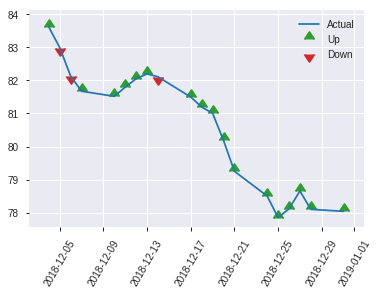


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24456630804527885
RMSE: 0.49453645775137633
LogLoss: 0.681941678247296
Mean Per-Class Error: 0.39124700975280624
AUC: 0.6290253327608415
pr_auc: 0.5910902647309574
Gini: 0.258050665521683
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4343093931674957: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   118  0.8613   (118.0/137.0)
1      6    113  0.0504   (6.0/119.0)
Total  25   231  0.4844   (124.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434309     0.645714  230
max f2                       0.304864     0.815068  253
max f0point5                 0.556936     0.581222  137
max accuracy                 0.556936     0.605469  137
max precision                0.745374     1         0
max recall                   0.304864     1         253
max specificity              0.745374     1         0
max absolute_mcc             0.556936     0.217633  137
max min_per_class_accuracy   0.565743     0.591241  126
max mean_per_class_accuracy  0.556936     0.608753  137

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 55.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.711868           2.15126   2.15126            1                0.729703  1                           0.729703            0.0252101       0.0252101                  115.126    115.126
    2        0.0234375                   0.699554           2.15126   2.15126            1                0.701487  1                           0.715595            0.0252101       0.0504202                  115.126    115.126
    3        0.03125                     0.693602           1.07563   1.88235            0.5              0.696284  0.875                       0.710767            0.00840336      0.0588235                  7.56303    88.2353
    4        0.0429688                   0.685368           1.43417   1.76012            0.666667         0.689503  0.818182                    0.704968            0.0168067       0.0756303                  43.4174    76.0122
    5        0.0507812                   0.682534           0         1.48933            0                0.683953  0.692308                    0.701735            0               0.0756303                  -100       48.9334
    6        0.101562                    0.665809           1.48933   1.48933            0.692308         0.675889  0.692308                    0.688812            0.0756303       0.151261                   48.9334    48.9334
    7        0.152344                    0.650647           0.992889  1.32385            0.461538         0.656084  0.615385                    0.677903            0.0504202       0.201681                   -0.711054  32.3853
    8        0.203125                    0.632396           1.48933   1.36522            0.692308         0.643258  0.634615                    0.669241            0.0756303       0.277311                   48.9334    36.5223
    9        0.300781                    0.607835           1.11866   1.28517            0.52             0.619564  0.597403                    0.653112            0.109244        0.386555                   11.8655    28.5169
    10       0.402344                    0.585535           0.910149  1.1905             0.423077         0.597746  0.553398                    0.639136            0.092437        0.478992                   -8.98513   19.0503
    11       0.5                         0.565632           1.29076   1.21008            0.6              0.574525  0.5625                      0.626517            0.12605         0.605042                   29.0756    21.0084
    12       0.601562                    0.539516           0.827408  1.14548            0.384615         0.552322  0.532468                    0.613991            0.0840336       0.689076                   -17.2592   14.5476
    13       0.699219                    0.516057           1.03261   1.12971            0.48             0.527346  0.52514                     0.601889            0.10084         0.789916                   3.2605     12.9712
    14       0.800781                    0.482421           0.744667  1.08088            0.346154         0.499269  0.502439                    0.588874            0.0756303       0.865546                   -25.5333   8.08772
    15       0.898438                    0.434354           0.774454  1.04757            0.36             0.460852  0.486957                    0.574959            0.0756303       0.941176                   -22.5546   4.75703
    16       1                           0.252248           0.579186  1                  0.269231         0.371441  0.464844                    

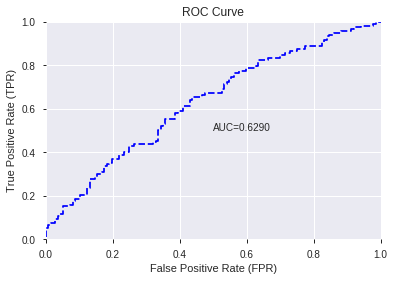

This function is available for GLM models only


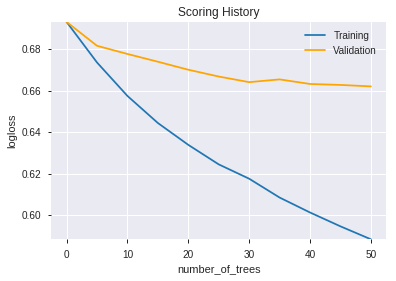

--2019-08-22 10:56:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_105528_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_105528_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_105636_model_6  0.668405  0.688443              0.431976  0.497840  0.247844
1  DeepLearning_grid_1_AutoML_20190822_105636_model_8  0.663068  0.685490              0.407747  0.496672  0.246683
2  DeepLearning_grid_1_AutoML_20190822_105636_model_9  0.656934  0.686257              0.433080  0.496792  0.246802
3               DeepLearning_1_AutoML_20190822_105636  0.602772  0.712195              0.437619  0.506437  0.256479
4  DeepLearning_grid_1_AutoML_20190822_105636_model_4  0.594001  0.756421              0.457308  0.517813  0.268130
5  DeepLearning_grid_1_AutoML_20190822_105636_model_2  0.557382  0.803501              0.489051  0.538388  0.289862
6  DeepLearning_grid_1_AutoML_20190822_105636_model_3  0.542784  0.783312              0.500000  0.534224  0.285395
7  DeepLearning_grid_1_AutoML_20190822_105636_model_5  0.518187  0.712425              0.489051  0.509375  0.259463
8  DeepLearning_grid_1_AutoML_20190822_105636_model_7  0.497332  0.826310              0.481752  0.552174  0.304896
9  DeepLearning_grid_1_AutoML_20190822_105636_model_1  0.437404  1.079047              0.496350  0.594907  0.353915

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.027694
1                  SUB             0.896441           0.896441    0.024826
2                  DIV             0.820279           0.820279    0.022717
3    CDLGRAVESTONEDOJI             0.789620           0.789620    0.021868
4               ULTOSC             0.776316           0.776316    0.021499
5       CDLRICKSHAWMAN             0.776145           0.776145    0.021495
6                 COSH             0.768886           0.768886    0.021293
7   CDLMORNINGDOJISTAR             0.768398           0.768398    0.021280
8              CDLDOJI             0.753274           0.753274    0.020861
9            CDLINNECK             0.751779           0.751779    0.020820
10  CDLSEPARATINGLINES             0.750142           0.750142    0.020774
11    CDLABANDONEDBABY             0.749296           0.749296    0.020751
12        HT_TRENDMODE             0.741589           0.741589    0.020538
13        STOCHF_fastk             0.736837           0.736837    0.020406
14  CDLEVENINGDOJISTAR             0.736836           0.736836    0.020406
15         CDLBELTHOLD             0.734960           0.734960    0.020354
16              SAREXT             0.732943           0.732943    0.020298
17     CDLADVANCEBLOCK             0.732507           0.732507    0.020286
18   CDLLONGLEGGEDDOJI             0.731483           0.731483    0.020258
19           dayofweek             0.723600           0.723600    0.020039
20        CDLTHRUSTING             0.718817           0.718817    0.019907
21                SINH             0.717217           0.717217    0.019863
22              TRANGE             0.717046           0.717046    0.019858
23           CORREL_12             0.714093           0.714093    0.019776
24       days_in_month             0.712124           0.712124    0.019722
25      CDLMORNINGSTAR             0.710114           0.710114    0.019666
26             weekday             0.707904           0.707904    0.019605
27     CDLHOMINGPIGEON             0.707134           0.707134    0.019583
28   CDLDARKCLOUDCOVER             0.704152           0.704152    0.019501
29     CDLUNIQUE3RIVER             0.701952           0.701952    0.019440
30                 EXP             0.699977           0.699977    0.019385
31    CDLDRAGONFLYDOJI             0.699410           0.699410    0.019369
32      is_month_start             0.694782           0.694782    0.019241
33          CDL3INSIDE             0.693746           0.693746    0.019213
34     CDLLADDERBOTTOM             0.690648           0.690648    0.019127
35           CDLONNECK             0.688741           0.688741    0.019074
36      CDLMATCHINGLOW             0.685297           0.685297    0.018979
37                 SIN             0.684387           0.684387    0.018953
38           CDLTAKURI             0.681777           0.681777    0.018881
39        is_month_end             0.681664           0.681664    0.018878
40      CDLEVENINGSTAR             0.678832           0.678832    0.018800
41    is_quarter_start             0.677377           0.677377    0.018759
42           CDLHAMMER             0.671605           0.671605    0.018599
43   CDLINVERTEDHAMMER             0.666951           0.666951    0.018470
44       CDLHANGINGMAN             0.664845           0.664845    0.018412
45      is_quarter_end             0.663857           0.663857    0.018385
46     CDLSHOOTINGSTAR             0.654670           0.654670    0.018130
47       CDLHIKKAKEMOD             0.654547           0.654547    0.018127
48        weekday_name             0.647387           0.647387    0.017929
49    CDLCOUNTERATTACK             0.646595           0.646595    0.017907

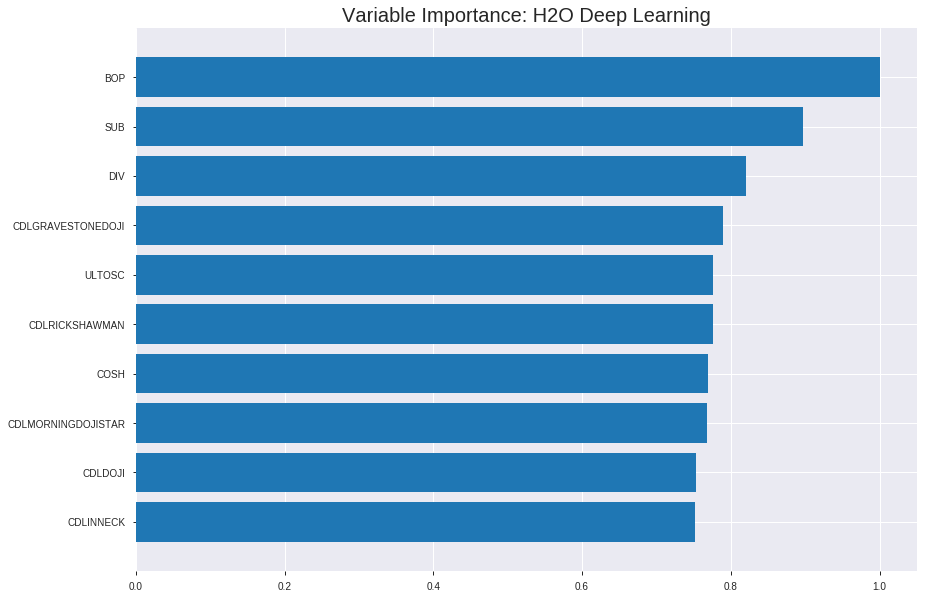

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_105636_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23167344484178423
RMSE: 0.48132467715855193
LogLoss: 0.6548307708116782
Mean Per-Class Error: 0.37976809926452193
AUC: 0.6626488467503877
pr_auc: 0.6565039016747952
Gini: 0.3252976935007754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4323213447159201: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      163  706   0.8124   (706.0/869.0)
1      42   878   0.0457   (42.0/920.0)
Total  205  1584  0.4181   (748.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432321     0.701278  279
max f2                       0.269201     0.844719  356
max f0point5                 0.548845     0.631687  160
max accuracy                 0.548845     0.621576  160
max precision                0.760297     1         0
max recall                   0.13473      1         393
max specificity              0.760297     1         0
max absolute_mcc             0.511974     0.247403  214
max min_per_class_accuracy   0.554993     0.606522  150
max mean_per_class_accuracy  0.548845     0.620232  160

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 53.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.695536           1.62047   1.62047            0.833333         0.721993  0.833333                    0.721993            0.0163043       0.0163043                  62.0471   62.0471
    2        0.020123                    0.67733            1.51244   1.56646            0.777778         0.685797  0.805556                    0.703895            0.0152174       0.0315217                  51.244    56.6455
    3        0.0301845                   0.666241           1.62047   1.58446            0.833333         0.671321  0.814815                    0.693037            0.0163043       0.0478261                  62.0471   58.4461
    4        0.0402459                   0.653162           1.62047   1.59346            0.833333         0.658549  0.819444                    0.684415            0.0163043       0.0641304                  62.0471   59.3463
    5        0.0503074                   0.643233           1.40441   1.55565            0.722222         0.648936  0.8                         0.677319            0.0141304       0.0782609                  40.4408   55.5652
    6        0.100056                    0.612762           1.35464   1.45571            0.696629         0.624362  0.748603                    0.650989            0.0673913       0.145652                   35.4641   45.5708
    7        0.150363                    0.599705           1.3612    1.42409            0.7              0.604943  0.732342                    0.635583            0.0684783       0.21413                    36.1196   42.4087
    8        0.200112                    0.589734           1.2017    1.3688             0.617978         0.594058  0.703911                    0.62526             0.0597826       0.273913                   20.1698   36.88
    9        0.300168                    0.575779           1.09721   1.27827            0.564246         0.582332  0.657356                    0.61095             0.109783        0.383696                   9.72128   27.8271
    10       0.400224                    0.564839           1.1298    1.24115            0.581006         0.570351  0.638268                    0.600801            0.113043        0.496739                   12.9803   24.1154
    11       0.500279                    0.554569           1.09721   1.21237            0.564246         0.559896  0.623464                    0.59262             0.109783        0.606522                   9.72128   21.2366
    12       0.599776                    0.541332           1.00506   1.17798            0.516854         0.548542  0.605778                    0.585308            0.1             0.706522                   0.505618  17.7975
    13       0.699832                    0.521663           1.0103    1.154              0.519553         0.531848  0.59345                     0.577665            0.101087        0.807609                   1.03048   15.4003
    14       0.799888                    0.490062           0.814762  1.11157            0.418994         0.507835  0.571628                    0.56893             0.0815217       0.88913                    -18.5238  11.1568
    15       0.899944                    0.417804           0.716991  1.0677             0.368715         0.459401  0.549068                    0.556752            0.0717391       0.96087                    -28.3009  6.76992
    16       1                           0.0775078          0.391086  1                  0.201117         0.301155  0.514254                    0.531178           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23777726635845803
RMSE: 0.48762410354540314
LogLoss: 0.6682308181325612
Mean Per-Class Error: 0.3929892141756548
AUC: 0.6379738058551618
pr_auc: 0.6525786879934647
Gini: 0.27594761171032367
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5260027952307118: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      70   166  0.7034   (166.0/236.0)
1      28   247  0.1018   (28.0/275.0)
Total  98   413  0.3796   (194.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.526003     0.718023  309
max f2                       0.341912     0.856785  387
max f0point5                 0.54675      0.643327  262
max accuracy                 0.530715     0.622309  300
max precision                0.730009     1         0
max recall                   0.134133     1         398
max specificity              0.730009     1         0
max absolute_mcc             0.526003     0.246664  309
max min_per_class_accuracy   0.563525     0.589091  201
max mean_per_class_accuracy  0.54675      0.607011  262

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 55.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.680232           1.85818   1.85818            1                0.705739  1                           0.705739            0.0218182       0.0218182                  85.8182   85.8182
    2        0.0215264                   0.658555           1.48655   1.68926            0.8              0.66749   0.909091                    0.688353            0.0145455       0.0363636                  48.6545   68.9256
    3        0.0313112                   0.65125            0.743273  1.39364            0.4              0.654021  0.75                        0.677624            0.00727273      0.0436364                  -25.6727  39.3636
    4        0.0410959                   0.640955           1.48655   1.41576            0.8              0.644064  0.761905                    0.669634            0.0145455       0.0581818                  48.6545   41.5758
    5        0.0508806                   0.630338           1.11491   1.3579             0.6              0.63532   0.730769                    0.663035            0.0109091       0.0690909                  11.4909   35.7902
    6        0.101761                    0.611721           1.21497   1.28643            0.653846         0.619141  0.692308                    0.641088            0.0618182       0.130909                   21.4965   28.6434
    7        0.150685                    0.601639           1.33789   1.30314            0.72             0.606206  0.701299                    0.629763            0.0654545       0.196364                   33.7891   30.314
    8        0.201566                    0.594083           1.07203   1.2448             0.576923         0.598166  0.669903                    0.621787            0.0545455       0.250909                   7.2028    24.4801
    9        0.30137                     0.580549           1.23879   1.24281            0.666667         0.587113  0.668831                    0.610304            0.123636        0.374545                   23.8788   24.281
    10       0.401174                    0.571277           1.09305   1.20555            0.588235         0.575468  0.64878                     0.601637            0.109091        0.483636                   9.30481   20.5552
    11       0.500978                    0.563626           1.02018   1.16862            0.54902          0.567323  0.628906                    0.594801            0.101818        0.585455                   2.01783   16.8622
    12       0.600783                    0.555861           0.983743  1.13791            0.529412         0.559473  0.612378                    0.588932            0.0981818       0.683636                   -1.62567  13.7909
    13       0.700587                    0.544676           1.09305   1.13152            0.588235         0.550247  0.608939                    0.583421            0.109091        0.792727                   9.30481   13.1519
    14       0.800391                    0.527937           0.983743  1.11309            0.529412         0.536978  0.599022                    0.57763             0.0981818       0.890909                   -1.62567  11.3092
    15       0.900196                    0.491432           0.619394  1.05836            0.333333         0.513439  0.569565                    0.570513            0.0618182       0.952727                   -38.0606  5.83557
    16       1                           0.125893           0.473654  1                  0.254902         0.391532  0.53816                     0.55265            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:00:32  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 11:00:34  2 min 14.892 sec  923 obs/sec       1         1             1789       0.573261         1.04273             -0.315583      0.600208        0.5872             1.62047          0.453885                         0.584861           1.09752               -0.376267        0.576664          0.599936             1.54848            0.455969
    2019-08-22 11:00:40  2 min 21.031 sec  1904 obs/sec      8         8             14312      0.481325         0.654831            0.0725525      0.662649        0.656504           1.62047          0.418111                         0.487624           0.668231              0.0433184        0.637974          0.652579             1.85818            0.379648
    2019-08-22 11:00:46  2 min 26.700 sec  2407 obs/sec      17        17            30413      0.473328         0.637601            0.103113       0.687025        0.683183           1.7285           0.366126                         0.487746           0.668689              0.0428389        0.625424          0.646901             1.85818            0.410959
    2019-08-22 11:00:52  2 min 32.705 sec  2672 obs/sec      27        27            48303      0.468609         0.627015            0.120908       0.703522        0.702503           1.83653          0.372834                         0.487887           0.668724              0.0422879        0.628197          0.647958             1.85818            0.401174
    2019-08-22 11:00:57  2 min 38.503 sec  2838 obs/sec      37        37            66193      0.460735         0.610116            0.150203       0.721247        0.720988           1.94457          0.34265                          0.488267           0.672931              0.0407929        0.623667          0.6413               1.54848            0.395303
    2019-08-22 11:01:03  2 min 44.198 sec  2954 obs/sec      47        47            84083      0.456569         0.601337            0.165499       0.733652        0.736794           1.83653          0.349916                         0.490708           0.680889              0.031179         0.620439          0.635951             1.54848            0.385519
    2019-08-22 11:01:09  2 min 49.830 sec  3040 obs/sec      57        57            101973     0.450948         0.589774            0.185921       0.750086        0.755727           1.83653          0.333706                         0.491078           0.684535              0.0297169        0.623413          0.634881             1.23879            0.424658
    2019-08-22 11:01:09  2 min 51.190 sec  3039 obs/sec      57        57            101973     0.481325         0.654831            0.0725525      0.662649        0.656504           1.62047          0.418111                         0.487624           0.668231              0.0433184        0.637974          0.652579             1.85818            0.379648

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
BOP                1.0                    1.0                  0.027693943980925378
SUB                0.8964411020278931     0.8964411020278931   0.024825989661759484
DIV                0.8202789425849915     0.8202789425849915   0.02271675908468146
CDLGRAVESTONEDOJI  0.7896198630332947     0.7896198630332947   0.021867688253070033
ULTOSC             0.7763158082962036     0.7763158082962036   0.02149924650646187
---                ---                    ---                  ---
is_quarter_end     0.6638568043708801     0.6638568043708801   0.018384813151603292
CDLSHOOTINGSTAR    0.6546701192855835     0.6546701192855835   0.018130397609480684
CDLHIKKAKEMOD      0.6545467972755432     0.6545467972755432   0.018126982336643015
weekday_name       0.6473867893218994     0.6473867893218994   0.01792869347747182
CDLCOUNTERATTACK   0.6465950608253479     0.6465950608253479   0.017906767392840223


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.65625)

('F1', 0.6528189910979227)

('auc', 0.6684045881126173)

('logloss', 0.6884433536670901)

('mean_per_class_error', 0.35539471262957734)

('rmse', 0.4978396580080328)

('mse', 0.2478443250855551)

deeplearning prediction progress: |███████████████████████████████████████| 100%


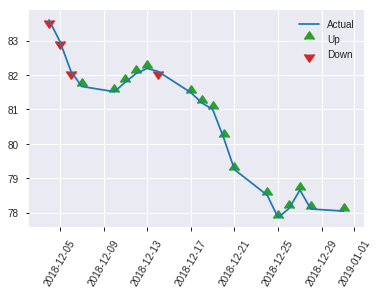


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2478443250855551
RMSE: 0.4978396580080328
LogLoss: 0.6884433536670901
Mean Per-Class Error: 0.35539471262957734
AUC: 0.6684045881126173
pr_auc: 0.6551595176155007
Gini: 0.33680917622523454
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5260190990319511: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      29   108  0.7883   (108.0/137.0)
1      9    110  0.0756   (9.0/119.0)
Total  38   218  0.457    (117.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.526019     0.652819  217
max f2                       0.446479     0.816187  252
max f0point5                 0.58408      0.632054  80
max accuracy                 0.58408      0.65625   80
max precision                0.705759     1         0
max recall                   0.446479     1         252
max specificity              0.705759     1         0
max absolute_mcc             0.58408      0.308976  80
max min_per_class_accuracy   0.565857     0.605839  126
max mean_per_class_accuracy  0.583796     0.644605  82

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 56.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.670617           2.15126   2.15126            1                0.694379  1                           0.694379            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.654219           1.43417   1.79272            0.666667         0.656547  0.833333                    0.675463            0.0168067       0.0420168                  43.4174   79.2717
    3        0.03125                     0.646086           2.15126   1.88235            1                0.651309  0.875                       0.669425            0.0168067       0.0588235                  115.126   88.2353
    4        0.0429688                   0.633976           2.15126   1.95569            1                0.638804  0.909091                    0.661074            0.0252101       0.0840336                  115.126   95.5691
    5        0.0507812                   0.631942           1.07563   1.8203             0.5              0.632575  0.846154                    0.656689            0.00840336      0.092437                   7.56303   82.0297
    6        0.101562                    0.615889           1.65482   1.73756            0.769231         0.622289  0.807692                    0.639489            0.0840336       0.176471                   65.4816   73.7557
    7        0.152344                    0.605167           1.65482   1.70998            0.769231         0.610624  0.794872                    0.629868            0.0840336       0.260504                   65.4816   70.9976
    8        0.203125                    0.597681           1.15837   1.57207            0.538462         0.601121  0.730769                    0.622681            0.0588235       0.319328                   15.8371   57.2075
    9        0.300781                    0.585421           1.29076   1.48074            0.6              0.590437  0.688312                    0.612212            0.12605         0.445378                   29.0756   48.0738
    10       0.402344                    0.575337           0.910149  1.33671            0.423077         0.580355  0.621359                    0.604171            0.092437        0.537815                   -8.98513  33.6706
    11       0.5                         0.565592           0.860504  1.2437             0.4              0.570992  0.578125                    0.597691            0.0840336       0.621849                   -13.9496  24.3697
    12       0.601562                    0.559458           0.910149  1.18738            0.423077         0.562777  0.551948                    0.591796            0.092437        0.714286                   -8.98513  18.7384
    13       0.699219                    0.548553           0.688403  1.11769            0.32             0.555415  0.519553                    0.586715            0.0672269       0.781513                   -31.1597  11.7694
    14       0.800781                    0.533238           0.910149  1.09137            0.423077         0.542355  0.507317                    0.581089            0.092437        0.87395                    -8.98513  9.13712
    15       0.898438                    0.513269           0.688403  1.04757            0.32             0.525482  0.486957                    0.575045            0.0672269       0.941176                   -31.1597  4.75703
    16       1                           0.38235            0.579186  1                  0.269231         0.478417  0.464844                    0.565231         

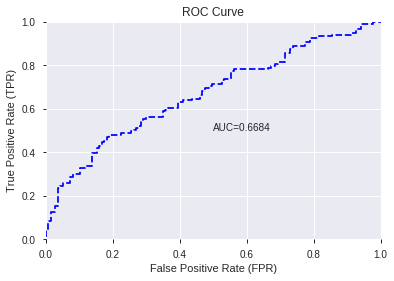

This function is available for GLM models only


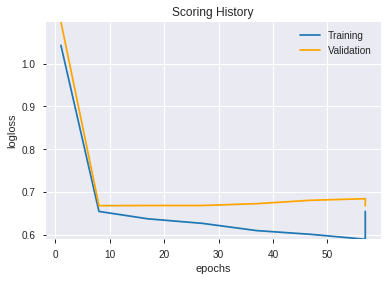

--2019-08-22 11:04:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.230.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.230.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_105636_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_105636_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'DIV',
 'CDLGRAVESTONEDOJI',
 'ULTOSC',
 'CDLRICKSHAWMAN',
 'COSH',
 'CDLMORNINGDOJISTAR',
 'CDLDOJI',
 'CDLINNECK',
 'CDLSEPARATINGLINES',
 'CDLABANDONEDBABY',
 'HT_TRENDMODE',
 'STOCHF_fastk',
 'CDLEVENINGDOJISTAR',
 'CDLBELTHOLD',
 'SAREXT',
 'CDLADVANCEBLOCK',
 'CDLLONGLEGGEDDOJI',
 'dayofweek',
 'CDLTHRUSTING',
 'SINH',
 'TRANGE',
 'CORREL_12',
 'days_in_month',
 'CDLMORNINGSTAR',
 'weekday',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLUNIQUE3RIVER',
 'EXP',
 'CDLDRAGONFLYDOJI',
 'is_month_start',
 'CDL3INSIDE',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'CDLMATCHINGLOW',
 'SIN',
 'CDLTAKURI',
 'is_month_end',
 'CDLEVENINGSTAR',
 'is_quarter_start',
 'CDLHAMMER',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'is_quarter_end',
 'CDLSHOOTINGSTAR',
 'CDLHIKKAKEMOD',
 'weekday_name',
 'CDLCOUNTERATTACK']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_110438_model_1  0.646077  0.67201              0.439612  0.490983  0.241064

variable  relative_importance  scaled_importance  percentage
0                  SUB             1.881282           1.000000    0.228779
1                  DIV             1.432612           0.761509    0.174217
2    CDLLONGLEGGEDDOJI             0.524266           0.278675    0.063755
3                  BOP             0.480075           0.255185    0.058381
4              CDLDOJI             0.455646           0.242200    0.055410
5    CDLGRAVESTONEDOJI             0.313260           0.166514    0.038095
6     CDLDRAGONFLYDOJI             0.190867           0.101456    0.023211
7               TRANGE             0.184727           0.098192    0.022464
8      CDLSHOOTINGSTAR             0.171727           0.091282    0.020883
9         STOCHF_fastk             0.162022           0.086123    0.019703
10    CDLABANDONEDBABY             0.150847           0.080183    0.018344
11     CDLUNIQUE3RIVER             0.144011           0.076549    0.017513
12     CDLLADDERBOTTOM             0.140825           0.074856    0.017126
13   CDLINVERTEDHAMMER             0.137579           0.073130    0.016731
14           CDLINNECK             0.122462           0.065095    0.014892
15              ULTOSC             0.107372           0.057074    0.013057
16      CDLRICKSHAWMAN             0.098828           0.052532    0.012018
17              SAREXT             0.091089           0.048418    0.011077
18        is_month_end             0.078862           0.041919    0.009590
19           dayofweek             0.077236           0.041055    0.009393
20           CORREL_12             0.077122           0.040994    0.009379
21       CDLHANGINGMAN             0.076536           0.040683    0.009307
22             weekday             0.075239           0.039994    0.009150
23       days_in_month             0.070253           0.037343    0.008543
24  CDLEVENINGDOJISTAR             0.063639           0.033827    0.007739
25     CDLADVANCEBLOCK             0.062543           0.033245    0.007606
26      CDLMATCHINGLOW             0.061416           0.032646    0.007469
27      CDLEVENINGSTAR             0.061412           0.032644    0.007468
28      is_month_start             0.054746           0.029101    0.006658
29           CDLTAKURI             0.054148           0.028783    0.006585
30    is_quarter_start             0.053616           0.028500    0.006520
31       CDLHIKKAKEMOD             0.050898           0.027055    0.006190
32          CDL3INSIDE             0.050749           0.026976    0.006172
33     CDLHOMINGPIGEON             0.049138           0.026119    0.005976
34           CDLONNECK             0.048676           0.025874    0.005919
35  CDLMORNINGDOJISTAR             0.047916           0.025470    0.005827
36      is_quarter_end             0.041082           0.021837    0.004996
37        HT_TRENDMODE             0.038226           0.020319    0.004649
38           CDLHAMMER             0.037721           0.020050    0.004587
39    CDLCOUNTERATTACK             0.037046           0.019692    0.004505
40      CDLMORNINGSTAR             0.030558           0.016243    0.003716
41         CDLBELTHOLD             0.029848           0.015866    0.003630
42        CDLTHRUSTING             0.026659           0.014171    0.003242
43                SINH             0.018685           0.009932    0.002272
44                 EXP             0.016731           0.008894    0.002035
45                 SIN             0.015611           0.008298    0.001898
46                COSH             0.009645           0.005127    0.001173
47        weekday_name             0.008224           0.004372    0.001000
48  CDLSEPARATINGLINES             0.006165           0.003277    0.000750
49   CDLDARKCLOUDCOVER             0.003291           0.001750    0.000400

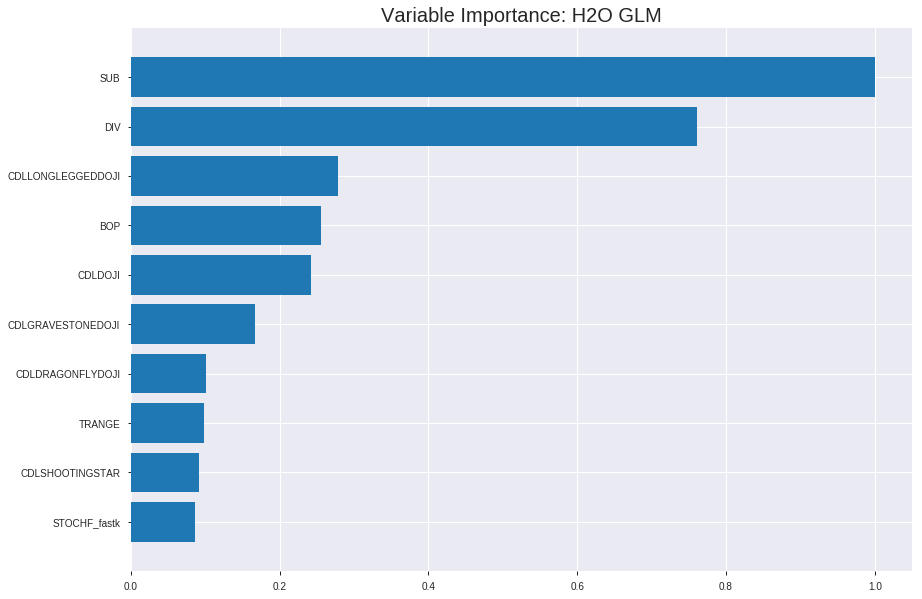

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_110438_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2218760742528386
RMSE: 0.4710372323424536
LogLoss: 0.6333315185345076
Null degrees of freedom: 1788
Residual degrees of freedom: 1738
Null deviance: 2478.6265302036704
Residual deviance: 2266.0601733164685
AIC: 2368.0601733164685
AUC: 0.6894300045029269
pr_auc: 0.6739403946092234
Gini: 0.3788600090058538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3697451901137808: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      259  610   0.702    (610.0/869.0)
1      75   845   0.0815   (75.0/920.0)
Total  334  1455  0.3829   (685.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369745     0.711579  287
max f2                       0.229954     0.845711  352
max f0point5                 0.530277     0.656741  183
max accuracy                 0.530277     0.645053  183
max precision                0.998706     1         0
max recall                   0.0768509    1         393
max specificity              0.998706     1         0
max absolute_mcc             0.530277     0.291862  183
max min_per_class_accuracy   0.521063     0.638665  189
max mean_per_class_accuracy  0.530277     0.645833  183

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.870954           1.7285    1.7285             0.888889         0.93154   0.888889                    0.93154             0.0173913       0.0173913                  72.8502   72.8502
    2        0.020123                    0.84081            1.7285    1.7285             0.888889         0.858815  0.888889                    0.895178            0.0173913       0.0347826                  72.8502   72.8502
    3        0.0301845                   0.816986           1.40441   1.62047            0.722222         0.82732   0.833333                    0.872559            0.0141304       0.048913                   40.4408   62.0471
    4        0.0402459                   0.795024           1.29638   1.53945            0.666667         0.806799  0.791667                    0.856119            0.0130435       0.0619565                  29.6377   53.9447
    5        0.0503074                   0.777466           1.40441   1.51244            0.722222         0.784232  0.777778                    0.841742            0.0141304       0.076087                   40.4408   51.244
    6        0.100056                    0.72292            1.33279   1.42312            0.685393         0.745349  0.731844                    0.793814            0.0663043       0.142391                   33.2792   42.3118
    7        0.150363                    0.677994           1.3828    1.40963            0.711111         0.698916  0.724907                    0.762064            0.0695652       0.211957                   38.2802   40.9629
    8        0.200112                    0.650005           1.31094   1.3851             0.674157         0.662931  0.712291                    0.737419            0.0652174       0.277174                   31.0943   38.5095
    9        0.300168                    0.599284           1.21671   1.32897            0.625698         0.623799  0.683426                    0.699546            0.121739        0.398913                   21.6711   32.8967
    10       0.400224                    0.556797           1.2493    1.30905            0.642458         0.57924   0.673184                    0.669469            0.125           0.523913                   24.9302   30.9051
    11       0.500279                    0.521266           1.11894   1.27103            0.575419         0.538557  0.653631                    0.643287            0.111957        0.63587                    11.894    27.1029
    12       0.599776                    0.485196           0.950434  1.21785            0.488764         0.503847  0.626281                    0.620155            0.0945652       0.730435                   -4.95664  21.7845
    13       0.699832                    0.435202           0.912533  1.17419            0.469274         0.461653  0.603834                    0.597494            0.0913043       0.821739                   -8.74666  17.4194
    14       0.799888                    0.376538           0.836489  1.13195            0.430168         0.40639   0.58211                     0.573589            0.0836957       0.905435                   -16.3511  13.1952
    15       0.899944                    0.299289           0.640946  1.07736            0.329609         0.340112  0.554037                    0.547631            0.0641304       0.969565                   -35.9054  7.73616
    16       1                           0.00162693         0.304178  1                  0.156425         0.214057  0.514254                    0.514255          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2328438751265927
RMSE: 0.48253898819327823
LogLoss: 0.6611395753337407
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 706.5876756969492
Residual deviance: 675.684645991083
AIC: 777.684645991083
AUC: 0.6482896764252697
pr_auc: 0.6520292820998261
Gini: 0.2965793528505394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4562431814616156: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      73   163  0.6907   (163.0/236.0)
1      25   250  0.0909   (25.0/275.0)
Total  98   413  0.3679   (188.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456243     0.726744  313
max f2                       0.0419604    0.853507  399
max f0point5                 0.473868     0.654078  293
max accuracy                 0.473868     0.637965  293
max precision                0.832988     0.8       4
max recall                   0.0419604    1         399
max specificity              0.928637     0.995763  0
max absolute_mcc             0.473868     0.277234  293
max min_per_class_accuracy   0.568768     0.580508  198
max mean_per_class_accuracy  0.473868     0.618867  293

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 55.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.827183           1.23879   1.23879            0.666667         0.86309   0.666667                    0.86309             0.0145455       0.0145455                  23.8788   23.8788
    2        0.0215264                   0.80283            1.48655   1.3514             0.8              0.811493  0.727273                    0.839637            0.0145455       0.0290909                  48.6545   35.1405
    3        0.0313112                   0.786398           1.48655   1.39364            0.8              0.791922  0.75                        0.824726            0.0145455       0.0436364                  48.6545   39.3636
    4        0.0410959                   0.768287           1.11491   1.32727            0.6              0.778372  0.714286                    0.813689            0.0109091       0.0545455                  11.4909   32.7273
    5        0.0508806                   0.759529           0.743273  1.21497            0.4              0.765224  0.653846                    0.804369            0.00727273      0.0618182                  -25.6727  21.4965
    6        0.101761                    0.720338           1.42937   1.32217            0.769231         0.734821  0.711538                    0.769595            0.0727273       0.134545                   42.9371   32.2168
    7        0.150685                    0.690744           1.48655   1.37554            0.8              0.704225  0.74026                     0.748371            0.0727273       0.207273                   48.6545   37.5537
    8        0.201566                    0.663726           1.1435    1.31696            0.615385         0.67558   0.708738                    0.729997            0.0581818       0.265455                   14.3497   31.6964
    9        0.30137                     0.625892           1.20235   1.27901            0.647059         0.644392  0.688312                    0.701647            0.12            0.385455                   20.2353   27.9008
    10       0.401174                    0.596704           1.05661   1.22368            0.568627         0.610276  0.658537                    0.678916            0.105455        0.490909                   5.66132   22.3681
    11       0.500978                    0.569033           0.874439  1.15411            0.470588         0.582808  0.621094                    0.659769            0.0872727       0.578182                   -12.5561  15.4105
    12       0.600783                    0.536332           0.947308  1.11975            0.509804         0.554359  0.602606                    0.642258            0.0945455       0.672727                   -5.26916  11.9751
    13       0.700587                    0.499859           1.27522   1.1419             0.686275         0.520126  0.614525                    0.624859            0.127273        0.8                        27.5223   14.1899
    14       0.800391                    0.460028           0.983743  1.12218            0.529412         0.479278  0.603912                    0.606706            0.0981818       0.898182                   -1.62567  12.2178
    15       0.900196                    0.400887           0.510089  1.05432            0.27451          0.431784  0.567391                    0.587313            0.0509091       0.949091                   -48.9911  5.43162
    16       1                           0.0419604          0.510089  1                  0.27451          0.303651  0.53816                     0.559002         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 11:04:38  0.000 sec   2            .89E1     51            1.3772996090935656  1.3756144960235313
     2019-08-22 11:04:38  0.018 sec   4            .55E1     51            1.373005021045817   1.3719422880317913
     2019-08-22 11:04:38  0.038 sec   6            .34E1     51            1.3669728469160174  1.3668889312957695
     2019-08-22 11:04:38  0.052 sec   8            .21E1     51            1.3590041724764745  1.3604414634540793
     2019-08-22 11:04:38  0.069 sec   10           .13E1     51            1.3492554836308313  1.3529653704446296
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 11:04:38  0.389 sec   45           .15E-3    51            1.2665481438528312  1.3222827990011972
     2019-08-22 11:04:38  0.406 sec   46           .96E-4    51            1.2664960774604284  1.322300872292574
     2019-08-22 11:04:38  0.413 sec   47           .6E-4     51            1.266473351640058   1.3223234310375014
     2019-08-22 11:04:38  0.418 sec   48           .37E-4    51            1.266463015705531   1.3223350274186514
     2019-08-22 11:04:38  0.424 sec   49           .23E-4    51            1.2664583647601713  1.3223417986106683


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.62890625)

('F1', 0.6590909090909091)

('auc', 0.6460774090658161)

('logloss', 0.6720095618846356)

('mean_per_class_error', 0.3864626142427774)

('rmse', 0.49098256631888815)

('mse', 0.2410638804290814)

glm prediction progress: |████████████████████████████████████████████████| 100%


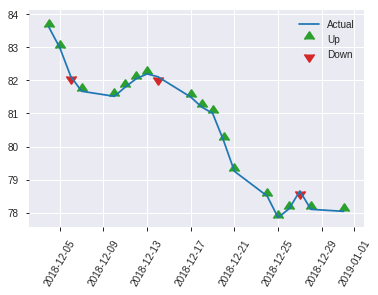


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2410638804290814
RMSE: 0.49098256631888815
LogLoss: 0.6720095618846356
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 356.1260369634925
Residual deviance: 344.0688956849334
AIC: 446.0688956849334
AUC: 0.6460774090658161
pr_auc: 0.6299226466223338
Gini: 0.29215481813163224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40079274342289056: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   117  0.854    (117.0/137.0)
1      3    116  0.0252   (3.0/119.0)
Total  23   233  0.4688   (120.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400793     0.659091  232
max f2                       0.342719     0.82296   246
max f0point5                 0.650691     0.588972  69
max accuracy                 0.650691     0.628906  69
max precision                0.883337     1         0
max recall                   0.342719     1         246
max specificity              0.883337     1         0
max absolute_mcc             0.650691     0.254096  69
max min_per_class_accuracy   0.584345     0.605839  126
max mean_per_class_accuracy  0.650691     0.613537  69

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 56.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.818758           2.15126   2.15126            1                0.864086  1                           0.864086            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.782755           2.15126   2.15126            1                0.791718  1                           0.827902            0.0252101       0.0504202                  115.126   115.126
    3        0.03125                     0.774181           2.15126   2.15126            1                0.775531  1                           0.814809            0.0168067       0.0672269                  115.126   115.126
    4        0.0429688                   0.762458           2.15126   2.15126            1                0.767123  1                           0.801804            0.0252101       0.092437                   115.126   115.126
    5        0.0507812                   0.75525            0         1.8203             0                0.758509  0.846154                    0.795143            0               0.092437                   -100      82.0297
    6        0.101562                    0.714794           1.32385   1.57207            0.615385         0.733591  0.730769                    0.764367            0.0672269       0.159664                   32.3853   57.2075
    7        0.152344                    0.690424           1.65482   1.59966            0.769231         0.699297  0.74359                     0.742677            0.0840336       0.243697                   65.4816   59.9655
    8        0.203125                    0.669735           0.827408  1.40659            0.384615         0.679004  0.653846                    0.726759            0.0420168       0.285714                   -17.2592  40.6593
    9        0.300781                    0.643816           1.37681   1.39692            0.64             0.657231  0.649351                    0.704185            0.134454        0.420168                   37.6807   39.6922
    10       0.402344                    0.611001           0.744667  1.23228            0.346154         0.627564  0.572816                    0.684844            0.0756303       0.495798                   -25.5333  23.2275
    11       0.5                         0.583785           1.20471   1.22689            0.56             0.595377  0.570312                    0.66737             0.117647        0.613445                   20.4706   22.6891
    12       0.601562                    0.550488           0.579186  1.11754            0.269231         0.566004  0.519481                    0.650256            0.0588235       0.672269                   -42.0814  11.7538
    13       0.699219                    0.515302           0.946555  1.09366            0.44             0.531895  0.50838                     0.633725            0.092437        0.764706                   -5.34454  9.36576
    14       0.800781                    0.461987           1.07563   1.09137            0.5              0.493326  0.507317                    0.615918            0.109244        0.87395                    7.56303   9.13712
    15       0.898438                    0.406956           0.860504  1.06628            0.4              0.440866  0.495652                    0.596891            0.0840336       0.957983                   -13.9496  6.62769
    16       1                           0.00226171         0.413704  1                  0.192308         0.323721  0.464844                    0.569147         

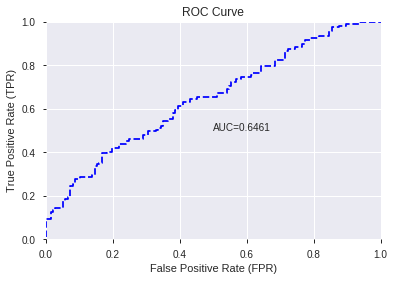

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


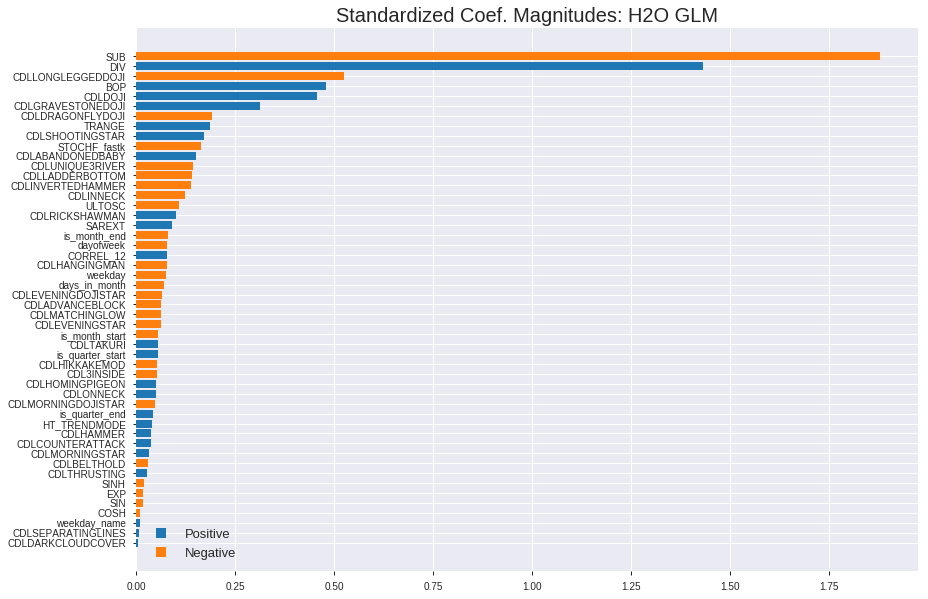

'log_likelihood'
--2019-08-22 11:04:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_110438_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_110438_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['SUB',
 'DIV',
 'CDLLONGLEGGEDDOJI',
 'BOP',
 'CDLDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'TRANGE',
 'CDLSHOOTINGSTAR',
 'STOCHF_fastk',
 'CDLABANDONEDBABY',
 'CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'CDLINVERTEDHAMMER',
 'CDLINNECK',
 'ULTOSC',
 'CDLRICKSHAWMAN',
 'SAREXT',
 'is_month_end',
 'dayofweek',
 'CORREL_12',
 'CDLHANGINGMAN',
 'weekday',
 'days_in_month',
 'CDLEVENINGDOJISTAR',
 'CDLADVANCEBLOCK',
 'CDLMATCHINGLOW',
 'CDLEVENINGSTAR',
 'is_month_start',
 'CDLTAKURI',
 'is_quarter_start',
 'CDLHIKKAKEMOD',
 'CDL3INSIDE',
 'CDLHOMINGPIGEON',
 'CDLONNECK',
 'CDLMORNINGDOJISTAR',
 'is_quarter_end',
 'HT_TRENDMODE',
 'CDLHAMMER',
 'CDLCOUNTERATTACK',
 'CDLMORNINGSTAR',
 'CDLBELTHOLD',
 'CDLTHRUSTING',
 'SINH',
 'EXP',
 'SIN',
 'COSH',
 'weekday_name',
 'CDLSEPARATINGLINES',
 'CDLDARKCLOUDCOVER']

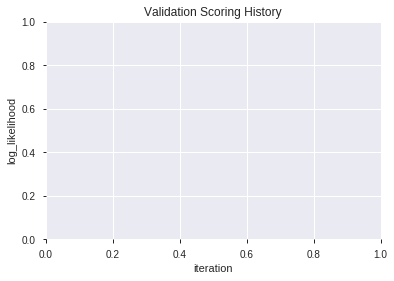

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_110450_model_4  0.644237  0.684433              0.474453  0.495919  0.245935
1  XGBoost_grid_1_AutoML_20190822_110450_model_6  0.617555  0.694647              0.449672  0.500676  0.250676
2  XGBoost_grid_1_AutoML_20190822_110450_model_2  0.616696  0.692134              0.461510  0.499434  0.249434
3  XGBoost_grid_1_AutoML_20190822_110450_model_1  0.616696  0.693412              0.465712  0.500146  0.250146
4               XGBoost_3_AutoML_20190822_110450  0.609152  0.693693              0.485401  0.500140  0.250140
5  XGBoost_grid_1_AutoML_20190822_110450_model_3  0.604735  0.693951              0.468257  0.500405  0.250405
6  XGBoost_grid_1_AutoML_20190822_110450_model_7  0.604551  0.698484              0.460406  0.502265  0.252270
7               XGBoost_1_AutoML_20190822_110450  0.602588  0.694409              0.460958  0.500443  0.250443
8               XGBoost_2_AutoML_20190822_110450  0.598847  0.699866              0.462062  0.503262  0.253272
9  XGBoost_grid_1_AutoML_20190822_110450_model_5  0.577317  0.709438              0.453107  0.507496  0.257552

variable  relative_importance  scaled_importance  percentage
0                 BOP           509.870392           1.000000    0.178059
1                 SUB           477.129059           0.935785    0.166625
2           CORREL_12           255.585373           0.501275    0.089256
3                COSH           249.391647           0.489128    0.087093
4        STOCHF_fastk           226.869873           0.444956    0.079228
5              ULTOSC           206.768692           0.405532    0.072209
6                 DIV           205.793823           0.403620    0.071868
7           dayofweek           144.040619           0.282504    0.050302
8              TRANGE           134.510712           0.263814    0.046974
9                 SIN           118.440216           0.232295    0.041362
10             SAREXT           111.906204           0.219480    0.039080
11  CDLGRAVESTONEDOJI            47.432350           0.093028    0.016564
12  CDLLONGLEGGEDDOJI            39.080967           0.076649    0.013648
13   CDLDRAGONFLYDOJI            38.118477           0.074761    0.013312
14      days_in_month            28.942249           0.056764    0.010107
15       HT_TRENDMODE            25.667072           0.050340    0.008964
16          CDLTAKURI            15.596218           0.030589    0.005447
17            CDLDOJI            13.086958           0.025667    0.004570
18       weekday_name            10.404232           0.020406    0.003633
19     CDLRICKSHAWMAN             4.859129           0.009530    0.001697

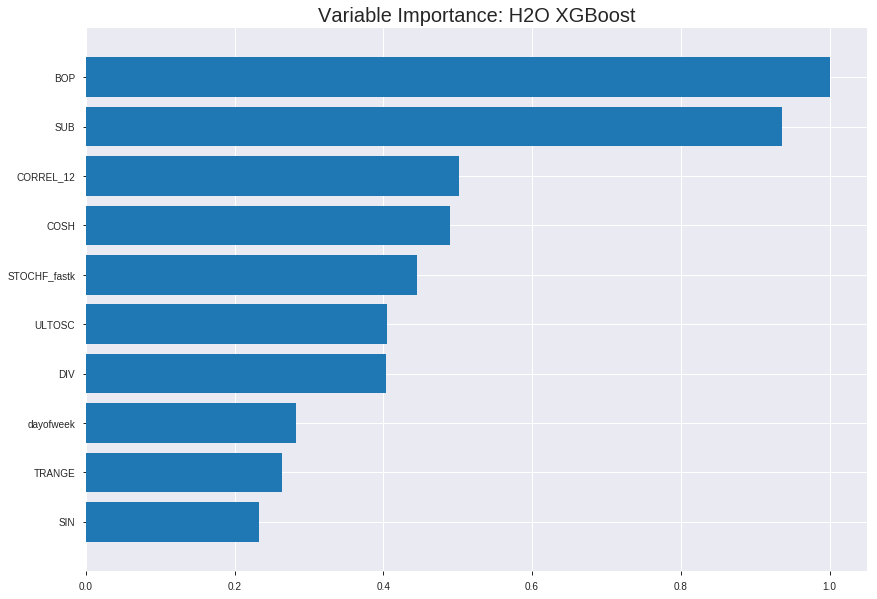

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_110450_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21165046998987105
RMSE: 0.4600548554138637
LogLoss: 0.6136815125587708
Mean Per-Class Error: 0.30192687747035574
AUC: 0.7530038274878671
pr_auc: 0.7454052891625165
Gini: 0.5060076549757342
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.428957536816597: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      355  514   0.5915   (514.0/869.0)
1      92   828   0.1      (92.0/920.0)
Total  447  1342  0.3387   (606.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428958     0.732095  266
max f2                       0.336938     0.854119  335
max f0point5                 0.514906     0.702411  191
max accuracy                 0.506556     0.699832  199
max precision                0.754135     1         0
max recall                   0.246532     1         387
max specificity              0.754135     1         0
max absolute_mcc             0.506556     0.399628  199
max min_per_class_accuracy   0.528948     0.682394  179
max mean_per_class_accuracy  0.506556     0.698073  199

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 51.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.705933           1.94457   1.94457            1                0.72451   1                           0.72451             0.0195652       0.0195652                  94.4565   94.4565
    2        0.020123                    0.695647           1.62047   1.78252            0.833333         0.700183  0.916667                    0.712346            0.0163043       0.0358696                  62.0471   78.2518
    3        0.0301845                   0.684804           1.7285    1.76451            0.888889         0.690183  0.907407                    0.704959            0.0173913       0.0532609                  72.8502   76.4513
    4        0.0402459                   0.676266           1.62047   1.7285             0.833333         0.680316  0.888889                    0.698798            0.0163043       0.0695652                  62.0471   72.8502
    5        0.0503074                   0.672829           1.51244   1.68529            0.777778         0.674467  0.866667                    0.693932            0.0152174       0.0847826                  51.244    68.529
    6        0.100056                    0.652494           1.57313   1.62952            0.808989         0.662163  0.837989                    0.678136            0.0782609       0.163043                   57.3131   62.9524
    7        0.150363                    0.637433           1.53405   1.59758            0.788889         0.644843  0.821561                    0.666997            0.0771739       0.240217                   53.4046   59.758
    8        0.200112                    0.623586           1.31094   1.52632            0.674157         0.630379  0.784916                    0.657894            0.0652174       0.305435                   31.0943   52.6321
    9        0.300168                    0.594571           1.39053   1.48106            0.715084         0.610403  0.761639                    0.642064            0.13913         0.444565                   39.0527   48.1056
    10       0.400224                    0.560314           1.28189   1.43127            0.659218         0.577575  0.736034                    0.625941            0.128261        0.572826                   28.1892   43.1265
    11       0.500279                    0.530234           1.02117   1.34925            0.52514          0.544635  0.693855                    0.60968             0.102174        0.675                      2.11683   34.9246
    12       0.599776                    0.494268           1.04875   1.2994             0.539326         0.512184  0.66822                     0.593507            0.104348        0.779348                   4.87543   29.9397
    13       0.699832                    0.455663           0.814762  1.23011            0.418994         0.475406  0.632588                    0.576622            0.0815217       0.86087                    -18.5238  23.0108
    14       0.799888                    0.402941           0.6844    1.16185            0.351955         0.429851  0.597484                    0.558262            0.0684783       0.929348                   -31.56    16.1847
    15       0.899944                    0.337225           0.521448  1.09065            0.268156         0.369808  0.56087                     0.53731             0.0521739       0.981522                   -47.8552  9.06474
    16       1                           0.216491           0.184679  1                  0.0949721        0.289326  0.514254                    0.512498           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23450373114044393
RMSE: 0.4842558529748958
LogLoss: 0.6612803009355278
Mean Per-Class Error: 0.39513867488443755
AUC: 0.6396995377503852
pr_auc: 0.6576399706071275
Gini: 0.2793990755007705
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39935486018657684: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   199  0.8432   (199.0/236.0)
1      10   265  0.0364   (10.0/275.0)
Total  47   464  0.409    (209.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399355     0.717185  354
max f2                       0.246404     0.854568  397
max f0point5                 0.512883     0.641173  268
max accuracy                 0.512883     0.618395  268
max precision                0.72365      1         0
max recall                   0.246404     1         397
max specificity              0.72365      1         0
max absolute_mcc             0.512883     0.226675  268
max min_per_class_accuracy   0.57855      0.589091  185
max mean_per_class_accuracy  0.546051     0.604861  234

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 55.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.707054           1.23879   1.23879            0.666667         0.715065  0.666667                    0.715065            0.0145455       0.0145455                  23.8788   23.8788
    2        0.0215264                   0.696518           1.85818   1.52033            1                0.699917  0.818182                    0.708179            0.0181818       0.0327273                  85.8182   52.0331
    3        0.0313112                   0.689387           1.11491   1.39364            0.6              0.691897  0.75                        0.703091            0.0109091       0.0436364                  11.4909   39.3636
    4        0.0410959                   0.687949           1.11491   1.32727            0.6              0.688881  0.714286                    0.699708            0.0109091       0.0545455                  11.4909   32.7273
    5        0.0508806                   0.685513           1.85818   1.42937            1                0.686988  0.769231                    0.697262            0.0181818       0.0727273                  85.8182   42.9371
    6        0.101761                    0.671847           1.28643   1.3579             0.692308         0.678174  0.730769                    0.687718            0.0654545       0.138182                   28.6434   35.7902
    7        0.150685                    0.660438           1.48655   1.39967            0.8              0.665687  0.753247                    0.680565            0.0727273       0.210909                   48.6545   39.9669
    8        0.201566                    0.646134           1.3579    1.38913            0.730769         0.654157  0.747573                    0.673899            0.0690909       0.28                       35.7902   38.9126
    9        0.30137                     0.621362           1.02018   1.26694            0.54902          0.633697  0.681818                    0.660585            0.101818        0.381818                   2.01783   26.6942
    10       0.401174                    0.600017           0.983743  1.19649            0.529412         0.612425  0.643902                    0.648604            0.0981818       0.48                       -1.62567  19.6488
    11       0.500978                    0.579548           1.02018   1.16136            0.54902          0.590258  0.625                       0.63698             0.101818        0.581818                   2.01783   16.1364
    12       0.600783                    0.553515           1.09305   1.15001            0.588235         0.565396  0.618893                    0.625088            0.109091        0.690909                   9.30481   15.0015
    13       0.700587                    0.51773            0.947308  1.12114            0.509804         0.537522  0.603352                    0.612614            0.0945455       0.785455                   -5.26916  12.1138
    14       0.800391                    0.465068           0.765134  1.07675            0.411765         0.493966  0.579462                    0.597819            0.0763636       0.861818                   -23.4866  7.67459
    15       0.900196                    0.405849           0.910873  1.05836            0.490196         0.434741  0.569565                    0.579739            0.0909091       0.952727                   -8.91266  5.83557
    16       1                           0.227108           0.473654  1                  0.254902         0.344274  0.53816                     0.556238         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:04:57  3.260 sec   0                  0.5              0.693147            0.5             0                  1                0.485746                         0.5                0.693147              0.5               0                    1                  0.46184
    2019-08-22 11:04:57  3.407 sec   5                  0.491034         0.675333            0.68852         0.64739            1.41901          0.386808                         0.49459            0.682366              0.622874          0.633023             1.32727            0.446184
    2019-08-22 11:04:57  3.487 sec   10                 0.484278         0.661968            0.699121        0.681489           1.51919          0.396311                         0.49204            0.677257              0.611302          0.635746             1.62591            0.446184
    2019-08-22 11:04:57  3.550 sec   15                 0.479513         0.652532            0.707449        0.684424           1.47519          0.399665                         0.489551           0.67226               0.625655          0.647929             1.23879            0.446184
    2019-08-22 11:04:58  3.619 sec   20                 0.475089         0.643719            0.715766        0.697921           1.62047          0.379542                         0.488007           0.669122              0.63104           0.656622             1.54848            0.446184
    2019-08-22 11:04:58  3.692 sec   25                 0.472093         0.637741            0.721793        0.704861           1.65288          0.367803                         0.487538           0.668132              0.630123          0.65308              1.23879            0.430528
    2019-08-22 11:04:58  3.766 sec   30                 0.469329         0.632245            0.730457        0.722055           1.94457          0.34768                          0.486706           0.666418              0.62953           0.646767             0.929091           0.41683
    2019-08-22 11:04:58  3.847 sec   35                 0.466718         0.62698             0.736527        0.728021           1.83653          0.34265                          0.486336           0.665581              0.631025          0.651136             1.23879            0.418787
    2019-08-22 11:04:58  3.924 sec   40                 0.464212         0.622004            0.743756        0.735162           1.83653          0.34265                          0.486314           0.665499              0.6297            0.648879             1.23879            0.424658
    2019-08-22 11:04:58  4.014 sec   45                 0.462113         0.617826            0.748659        0.739025           1.94457          0.332588                         0.485239           0.663326              0.635478          0.653808             1.23879            0.409002
    2019-08-22 11:04:58  4.100 sec   50                 0.460055         0.613682            0.753004        0.745405           1.94457          0.338737                         0.484256           0.66128               0.6397            0.65764              1.23879            0.409002

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
BOP                509.87                 1                    0.178059
SUB                477.129                0.935785             0.166625
CORREL_12          255.585                0.501275             0.0892565
COSH               249.392                0.489128             0.0870935
STOCHF_fastk       226.87                 0.444956             0.0792283
ULTOSC             206.769                0.405532             0.0722085
DIV                205.794                0.40362              0.0718681
dayofweek          144.041                0.282504             0.0503024
TRANGE             134.511                0.263814             0.0469743
SIN                118.44                 0.232295             0.0413621
SAREXT             111.906                0.21948              0.0390803
CDLGRAVESTONEDOJI  47.4324                0.0930282            0.0165645
CDLLONGLEGGEDDOJI  39.081                 0.0766488            0.013648
CDLDRAGONFLYDOJI   38.1185                0.0747611            0.0133119
days_in_month      28.9422                0.0567639            0.0101073
HT_TRENDMODE       25.6671                0.0503404            0.00896355
CDLTAKURI          15.5962                0.0305886            0.00544657
CDLDOJI            13.087                 0.0256672            0.00457028
weekday_name       10.4042                0.0204056            0.0036334
CDLRICKSHAWMAN     4.85913                0.00953013           0.00169692

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.62890625)

('F1', 0.6467391304347826)

('auc', 0.6442372569465743)

('logloss', 0.6844326206684973)

('mean_per_class_error', 0.37486965589155374)

('rmse', 0.4959187275958527)

('mse', 0.24593538438028956)

xgboost prediction progress: |████████████████████████████████████████████| 100%


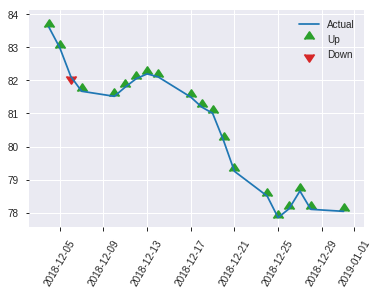


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24593538438028956
RMSE: 0.4959187275958527
LogLoss: 0.6844326206684973
Mean Per-Class Error: 0.37486965589155374
AUC: 0.6442372569465743
pr_auc: 0.6219386385407946
Gini: 0.2884745138931486
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.362064003944397: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    130  0.9489   (130.0/137.0)
1      0    119  0        (0.0/119.0)
Total  7    249  0.5078   (130.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362064     0.646739  248
max f2                       0.362064     0.82069   248
max f0point5                 0.60203      0.599647  111
max accuracy                 0.60203      0.628906  111
max precision                0.746214     1         0
max recall                   0.362064     1         248
max specificity              0.746214     1         0
max absolute_mcc             0.60203      0.251615  111
max min_per_class_accuracy   0.591103     0.605839  126
max mean_per_class_accuracy  0.60203      0.62513   111

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 56.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.720259           2.15126   2.15126            1                0.739985  1                           0.739985            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.699819           1.43417   1.79272            0.666667         0.703653  0.833333                    0.721819            0.0168067       0.0420168                  43.4174   79.2717
    3        0.03125                     0.68758            2.15126   1.88235            1                0.693255  0.875                       0.714678            0.0168067       0.0588235                  115.126   88.2353
    4        0.0429688                   0.684889           2.15126   1.95569            1                0.685785  0.909091                    0.706798            0.0252101       0.0840336                  115.126   95.5691
    5        0.0507812                   0.682537           1.07563   1.8203             0.5              0.684263  0.846154                    0.703331            0.00840336      0.092437                   7.56303   82.0297
    6        0.101562                    0.669132           1.48933   1.65482            0.692308         0.675862  0.769231                    0.689597            0.0756303       0.168067                   48.9334   65.4816
    7        0.152344                    0.657944           1.32385   1.54449            0.615385         0.662786  0.717949                    0.68066             0.0672269       0.235294                   32.3853   54.4495
    8        0.203125                    0.647464           1.15837   1.44796            0.538462         0.652373  0.673077                    0.673588            0.0588235       0.294118                   15.8371   44.7964
    9        0.300781                    0.626961           1.03261   1.31311            0.48             0.638883  0.61039                     0.66232             0.10084         0.394958                   3.2605    31.3107
    10       0.402344                    0.606021           1.24111   1.29493            0.576923         0.617191  0.601942                    0.650928            0.12605         0.521008                   24.1112   29.4934
    11       0.5                         0.590487           1.03261   1.2437             0.48             0.5998    0.578125                    0.640942            0.10084         0.621849                   3.2605    24.3697
    12       0.601562                    0.559536           0.827408  1.17341            0.384615         0.575836  0.545455                    0.62995             0.0840336       0.705882                   -17.2592  17.3415
    13       0.699219                    0.530136           0.860504  1.12971            0.4              0.542532  0.52514                     0.617741            0.0840336       0.789916                   -13.9496  12.9712
    14       0.800781                    0.492303           0.579186  1.05989            0.269231         0.512394  0.492683                    0.60438             0.0588235       0.848739                   -42.0814  5.98893
    15       0.898438                    0.452341           0.774454  1.02886            0.36             0.470379  0.478261                    0.589815            0.0756303       0.92437                    -22.5546  2.88637
    16       1                           0.28779            0.744667  1                  0.346154         0.391306  0.464844                    0.569654         

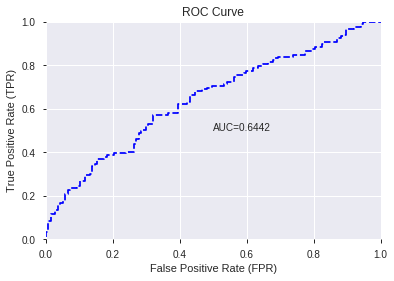

This function is available for GLM models only


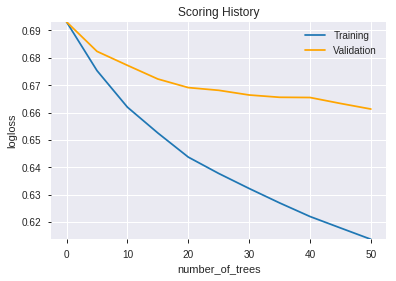

--2019-08-22 11:05:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.a

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_110450_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_110450_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'CORREL_12',
 'COSH',
 'STOCHF_fastk',
 'ULTOSC',
 'DIV',
 'dayofweek',
 'TRANGE',
 'SIN',
 'SAREXT',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLDRAGONFLYDOJI',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'CDLDOJI',
 'weekday_name',
 'CDLRICKSHAWMAN']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [922] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


5

['BOP', 'TRANGE', 'CDLBELTHOLD', 'DIV', 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190822_110518  0.616574  0.743738              0.442925  0.523698  0.274260
1  DeepLearning_grid_1_AutoML_20190822_110518_model_7  0.612219  0.676416              0.436729  0.491647  0.241717
2  DeepLearning_grid_1_AutoML_20190822_110518_model_4  0.603018  0.773369              0.463718  0.528820  0.279650
3  DeepLearning_grid_1_AutoML_20190822_110518_model_1  0.600135  0.714017              0.489603  0.509558  0.259649
4  DeepLearning_grid_1_AutoML_20190822_110518_model_2  0.597743  0.718687              0.442373  0.512081  0.262227
5  DeepLearning_grid_1_AutoML_20190822_110518_model_6  0.595473  0.703923              0.477765  0.505349  0.255377
6  DeepLearning_grid_1_AutoML_20190822_110518_model_5  0.589953  0.701013              0.439827  0.503881  0.253896
7  DeepLearning_grid_1_AutoML_20190822_110518_model_3  0.588542  0.713627              0.469914  0.510004  0.260104

variable  relative_importance  scaled_importance  percentage
0  CDLBELTHOLD             1.000000           1.000000    0.230382
1          DIV             0.938966           0.938966    0.216321
2          SUB             0.912931           0.912931    0.210323
3       TRANGE             0.817104           0.817104    0.188246
4          BOP             0.671608           0.671608    0.154727

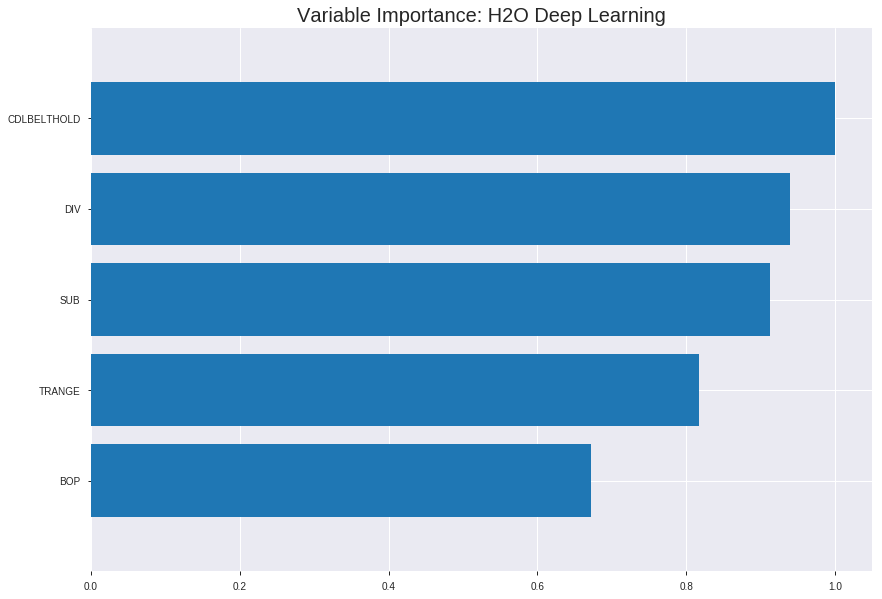

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190822_110518


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2384310821070875
RMSE: 0.48829405290980915
LogLoss: 0.6692230082881571
Mean Per-Class Error: 0.3845637164156701
AUC: 0.6515816530744984
pr_auc: 0.6384233936390036
Gini: 0.3031633061489969
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5045959750027307: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      212  657   0.756    (657.0/869.0)
1      75   845   0.0815   (75.0/920.0)
Total  287  1502  0.4092   (732.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504596     0.69777   266
max f2                       0.113643     0.844037  385
max f0point5                 0.573403     0.627702  210
max accuracy                 0.573403     0.617663  210
max precision                0.926635     1         0
max recall                   0.113643     1         385
max specificity              0.926635     1         0
max absolute_mcc             0.573403     0.237563  210
max min_per_class_accuracy   0.605941     0.611957  175
max mean_per_class_accuracy  0.597738     0.615436  184

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 59.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100615                   0.854939           1.51244   1.51244            0.777778         0.883253  0.777778                    0.883253            0.0152174       0.0152174                  51.244     51.244
    2        0.020123                    0.821156           1.29638   1.40441            0.666667         0.836086  0.722222                    0.85967             0.0130435       0.0282609                  29.6377    40.4408
    3        0.0301845                   0.803049           1.7285    1.51244            0.888889         0.812529  0.777778                    0.843956            0.0173913       0.0456522                  72.8502    51.244
    4        0.0402459                   0.779946           0.972283  1.3774             0.5              0.791334  0.708333                    0.830801            0.00978261      0.0554348                  -2.77174   37.74
    5        0.0503074                   0.765957           1.51244   1.40441            0.777778         0.772642  0.722222                    0.819169            0.0152174       0.0706522                  51.244     40.4408
    6        0.100056                    0.720728           1.35464   1.37966            0.696629         0.739277  0.709497                    0.779446            0.0673913       0.138043                   35.4641    37.9664
    7        0.150363                    0.698296           1.33959   1.36626            0.688889         0.709433  0.702602                    0.756021            0.0673913       0.205435                   33.9589    36.6256
    8        0.200112                    0.678045           1.2454    1.33621            0.640449         0.687933  0.687151                    0.739094            0.0619565       0.267391                   24.5396    33.621
    9        0.300168                    0.648577           1.14067   1.27103            0.586592         0.662424  0.653631                    0.713538            0.11413         0.381522                   14.0667    27.1029
    10       0.400224                    0.626593           1.08635   1.22486            0.558659         0.63673   0.629888                    0.694336            0.108696        0.490217                   8.63493    22.4859
    11       0.500279                    0.605905           1.19498   1.21888            0.614525         0.616225  0.626816                    0.678714            0.119565        0.609783                   19.4984    21.8884
    12       0.599776                    0.584821           0.994132  1.1816             0.511236         0.596142  0.607642                    0.665016            0.098913        0.708696                   -0.586834  18.16
    13       0.699832                    0.558524           0.879943  1.13847            0.452514         0.572248  0.585463                    0.651753            0.0880435       0.796739                   -12.0057   13.8471
    14       0.799888                    0.524071           0.912533  1.11021            0.469274         0.542629  0.570929                    0.638103            0.0913043       0.888043                   -8.74666   11.0209
    15       0.899944                    0.452714           0.586629  1.052              0.301676         0.4948    0.540994                    0.62217             0.0586957       0.946739                   -41.3371   5.19977
    16       1                           0.0281926          0.532311  1                  0.273743         0.318209  0.514254                    0.59175



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24555131978323108
RMSE: 0.49553135095897927
LogLoss: 0.683601560255781
Mean Per-Class Error: 0.38520801232665636
AUC: 0.6304237288135593
pr_auc: 0.6587854039511334
Gini: 0.2608474576271187
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5086492183216328: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   214  0.9068   (214.0/236.0)
1      8    267  0.0291   (8.0/275.0)
Total  30   481  0.4344   (222.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.508649     0.706349  370
max f2                       0.405875     0.856164  394
max f0point5                 0.628265     0.643856  214
max accuracy                 0.628265     0.616438  214
max precision                0.872979     1         0
max recall                   0.405875     1         394
max specificity              0.872979     1         0
max absolute_mcc             0.628265     0.229337  214
max min_per_class_accuracy   0.631357     0.610169  206
max mean_per_class_accuracy  0.628265     0.614792  214

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 63.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.836417           1.54848   1.54848            0.833333         0.852408  0.833333                    0.852408            0.0181818       0.0181818                  54.8485   54.8485
    2        0.0215264                   0.820001           1.85818   1.68926            1                0.826745  0.909091                    0.840743            0.0181818       0.0363636                  85.8182   68.9256
    3        0.0313112                   0.785518           1.11491   1.50977            0.6              0.803549  0.8125                      0.82912             0.0109091       0.0472727                  11.4909   50.9773
    4        0.0410959                   0.756324           1.48655   1.50424            0.8              0.764793  0.809524                    0.813804            0.0145455       0.0618182                  48.6545   50.4242
    5        0.0508806                   0.743126           1.48655   1.50084            0.8              0.750137  0.807692                    0.80156             0.0145455       0.0763636                  48.6545   50.0839
    6        0.101761                    0.717198           1.21497   1.3579             0.653846         0.727208  0.730769                    0.764384            0.0618182       0.138182                   21.4965   35.7902
    7        0.150685                    0.704858           1.26356   1.32727            0.68             0.710756  0.714286                    0.746972            0.0618182       0.2                        26.3564   32.7273
    8        0.201566                    0.692288           1.28643   1.31696            0.692308         0.697857  0.708738                    0.734575            0.0654545       0.265455                   28.6434   31.6964
    9        0.30137                     0.668376           1.23879   1.29107            0.666667         0.68093   0.694805                    0.716809            0.123636        0.389091                   23.8788   29.1074
    10       0.401174                    0.648734           0.947308  1.20555            0.509804         0.658423  0.64878                     0.702284            0.0945455       0.483636                   -5.26916  20.5552
    11       0.500978                    0.633005           1.20235   1.20491            0.647059         0.640418  0.648438                    0.689959            0.12            0.603636                   20.2353   20.4915
    12       0.600783                    0.616426           0.728699  1.1258             0.392157         0.624459  0.605863                    0.679078            0.0727273       0.676364                   -27.1301  12.5804
    13       0.700587                    0.603789           0.910873  1.09519            0.490196         0.610497  0.589385                    0.669308            0.0909091       0.767273                   -8.91266  9.51854
    14       0.800391                    0.589635           0.910873  1.0722             0.490196         0.596829  0.577017                    0.66027             0.0909091       0.858182                   -8.91266  7.22027
    15       0.900196                    0.550924           0.765134  1.03816            0.411765         0.573955  0.558696                    0.650701            0.0763636       0.934545                   -23.4866  3.81581
    16       1                           0.240872           0.655829  1                  0.352941         0.480973  0.53816                     0.633761         


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:05:19  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 11:05:19  0.058 sec   94157 obs/sec     1         1             1789       0.529229         0.77983             -0.121246      0.582671        0.595283           1.29638          0.485187                         0.513967           0.729881              -0.062841        0.626379          0.66351              1.85818            0.450098
    2019-08-22 11:05:19  0.222 sec   109754 obs/sec    10        10            17890      0.488294         0.669223            0.0455         0.651582        0.638423           1.51244          0.409167                         0.495531           0.683602              0.01204          0.630424          0.658785             1.54848            0.434442

Variable Importances: 


variable     relative_importance    scaled_importance    percentage
-----------  ---------------------  -------------------  ------------
CDLBELTHOLD  1                      1                    0.230382
DIV          0.938966               0.938966             0.216321
SUB          0.912931               0.912931             0.210323
TRANGE       0.817104               0.817104             0.188246
BOP          0.671608               0.671608             0.154727

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6015625)

('F1', 0.6470588235294118)

('auc', 0.6165736367539717)

('logloss', 0.7437379164720306)

('mean_per_class_error', 0.4018585536404342)

('rmse', 0.5236982930558038)

('mse', 0.2742599021495626)

deeplearning prediction progress: |███████████████████████████████████████| 100%


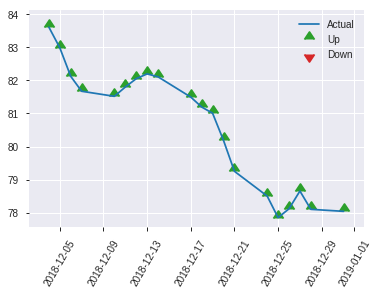


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2742599021495626
RMSE: 0.5236982930558038
LogLoss: 0.7437379164720306
Mean Per-Class Error: 0.4018585536404342
AUC: 0.6165736367539717
pr_auc: 0.5826933166148351
Gini: 0.2331472735079434
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5939179782915658: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      26   111  0.8102   (111.0/137.0)
1      9    110  0.0756   (9.0/119.0)
Total  35   221  0.4688   (120.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.593918     0.647059  220
max f2                       0.481292     0.812842  255
max f0point5                 0.644988     0.570523  127
max accuracy                 0.678863     0.601562  70
max precision                0.856992     1         0
max recall                   0.481292     1         255
max specificity              0.856992     1         0
max absolute_mcc             0.644988     0.195797  127
max min_per_class_accuracy   0.646341     0.596639  125
max mean_per_class_accuracy  0.644988     0.598141  127

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 64.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.809374           1.43417   1.43417            0.666667         0.830315  0.666667                    0.830315            0.0168067       0.0168067                  43.4174   43.4174
    2        0.0234375                   0.747435           2.15126   1.79272            1                0.783861  0.833333                    0.807088            0.0252101       0.0420168                  115.126   79.2717
    3        0.03125                     0.739007           2.15126   1.88235            1                0.740553  0.875                       0.790455            0.0168067       0.0588235                  115.126   88.2353
    4        0.0429688                   0.736475           2.15126   1.95569            1                0.737353  0.909091                    0.775972            0.0252101       0.0840336                  115.126   95.5691
    5        0.0507812                   0.731997           1.07563   1.8203             0.5              0.734545  0.846154                    0.769599            0.00840336      0.092437                   7.56303   82.0297
    6        0.101562                    0.715797           1.15837   1.48933            0.538462         0.725502  0.692308                    0.747551            0.0588235       0.151261                   15.8371   48.9334
    7        0.152344                    0.700459           1.15837   1.37901            0.538462         0.708685  0.641026                    0.734595            0.0588235       0.210084                   15.8371   37.9013
    8        0.203125                    0.694613           1.32385   1.36522            0.615385         0.696713  0.634615                    0.725125            0.0672269       0.277311                   32.3853   36.5223
    9        0.300781                    0.676021           1.11866   1.28517            0.52             0.683239  0.597403                    0.711526            0.109244        0.386555                   11.8655   28.5169
    10       0.402344                    0.660134           0.744667  1.14873            0.346154         0.668239  0.533981                    0.700599            0.0756303       0.462185                   -25.5333  14.8731
    11       0.5                         0.644852           1.46286   1.21008            0.68             0.65173   0.5625                      0.691054            0.142857        0.605042                   46.2857   21.0084
    12       0.601562                    0.630716           0.661926  1.11754            0.307692         0.63798   0.519481                    0.682094            0.0672269       0.672269                   -33.8074  11.7538
    13       0.699219                    0.615988           1.03261   1.10568            0.48             0.623892  0.513966                    0.673965            0.10084         0.773109                   3.2605    10.5676
    14       0.800781                    0.604178           0.744667  1.05989            0.346154         0.609975  0.492683                    0.665849            0.0756303       0.848739                   -25.5333  5.98893
    15       0.898438                    0.5827             0.946555  1.04757            0.44             0.594735  0.486957                    0.658119            0.092437        0.941176                   -5.34454  4.75703
    16       1                           0.481292           0.579186  1                  0.269231         0.552902  0.464844                    0.647433         

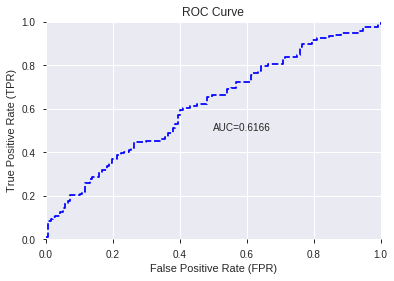

This function is available for GLM models only


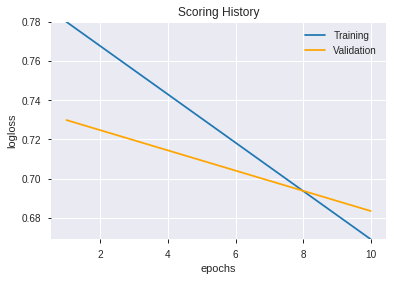

--2019-08-22 11:09:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190822_110518',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190822_110518',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_af23'

['CDLBELTHOLD', 'DIV', 'SUB', 'TRANGE', 'BOP']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_110950_model_1  0.579403  0.704105              0.476661  0.505359  0.255388

variable  relative_importance  scaled_importance  percentage
0          SUB             2.202378           1.000000    0.478483
1          DIV             1.695156           0.769693    0.368285
2          BOP             0.333300           0.151336    0.072412
3       TRANGE             0.221866           0.100739    0.048202
4  CDLBELTHOLD             0.150138           0.068171    0.032619

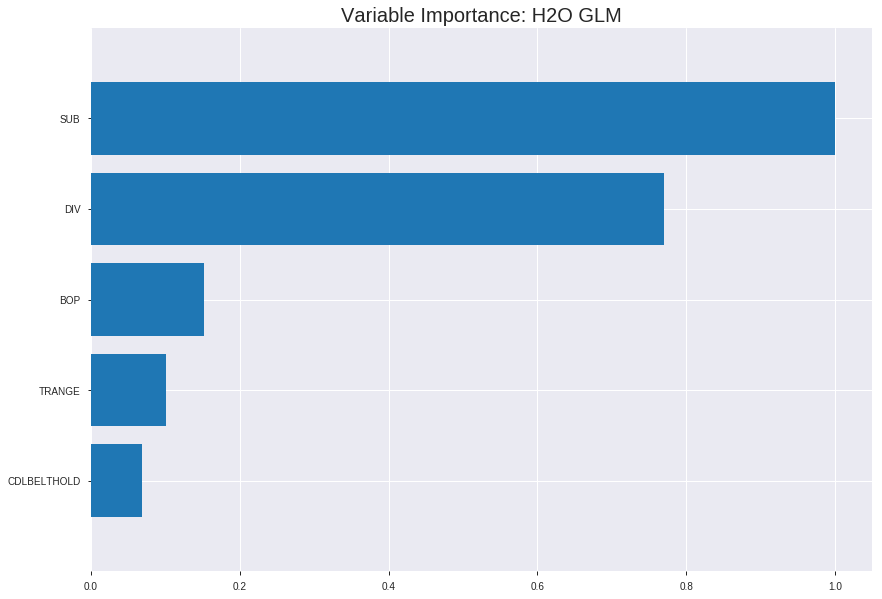

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_110950_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23117321400895918
RMSE: 0.48080475664136185
LogLoss: 0.654474013029322
Null degrees of freedom: 1788
Residual degrees of freedom: 1783
Null deviance: 2478.6265302036704
Residual deviance: 2341.708018618914
AIC: 2353.708018618914
AUC: 0.654738705158353
pr_auc: 0.6392080968349572
Gini: 0.30947741031670595
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3888430751117089: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      211  658   0.7572   (658.0/869.0)
1      68   852   0.0739   (68.0/920.0)
Total  279  1510  0.4058   (726.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388843     0.701235  292
max f2                       0.159584     0.84406   379
max f0point5                 0.495361     0.628253  211
max accuracy                 0.495361     0.618222  211
max precision                0.945248     1         0
max recall                   0.0550521    1         395
max specificity              0.945248     1         0
max absolute_mcc             0.495361     0.236819  211
max min_per_class_accuracy   0.53028      0.605293  181
max mean_per_class_accuracy  0.495361     0.614802  211

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.839235           1.51244   1.51244            0.777778         0.870686  0.777778                    0.870686            0.0152174       0.0152174                  51.244    51.244
    2        0.020123                    0.791028           1.18835   1.35039            0.611111         0.815486  0.694444                    0.843086            0.0119565       0.0271739                  18.8345   35.0393
    3        0.0301845                   0.764554           1.29638   1.33239            0.666667         0.780254  0.685185                    0.822142            0.0130435       0.0402174                  29.6377   33.2387
    4        0.0402459                   0.74149            1.29638   1.32338            0.666667         0.752963  0.680556                    0.804847            0.0130435       0.0532609                  29.6377   32.3385
    5        0.0503074                   0.722186           1.40441   1.33959            0.722222         0.732602  0.688889                    0.790398            0.0141304       0.0673913                  40.4408   33.9589
    6        0.100056                    0.657716           1.39834   1.3688             0.719101         0.684351  0.703911                    0.737671            0.0695652       0.136957                   39.8339   36.88
    7        0.150363                    0.62316            1.44762   1.39517            0.744444         0.639694  0.717472                    0.704891            0.0728261       0.209783                   44.7621   39.5171
    8        0.200112                    0.606906           1.31094   1.37423            0.674157         0.615012  0.706704                    0.682547            0.0652174       0.275                      31.0943   37.4232
    9        0.300168                    0.578455           1.09721   1.28189            0.564246         0.591488  0.659218                    0.652194            0.109783        0.384783                   9.72128   28.1892
    10       0.400224                    0.554084           1.05376   1.22486            0.541899         0.565622  0.629888                    0.630551            0.105435        0.490217                   5.37588   22.4859
    11       0.500279                    0.530651           1.1298    1.20585            0.581006         0.543095  0.620112                    0.61306             0.113043        0.603261                   12.9803   20.5848
    12       0.599776                    0.501626           1.04875   1.17979            0.539326         0.515922  0.60671                     0.596946            0.104348        0.707609                   4.87543   17.9787
    13       0.699832                    0.467644           0.90167   1.14002            0.463687         0.485746  0.586262                    0.581047            0.0902174       0.797826                   -9.83301  14.0025
    14       0.799888                    0.416288           0.879943  1.10749            0.452514         0.44538   0.569532                    0.564077            0.0880435       0.88587                    -12.0057  10.7492
    15       0.899944                    0.342513           0.760444  1.06891            0.391061         0.383684  0.549689                    0.544021            0.076087        0.961957                   -23.9556  6.8907
    16       1                           0.01173            0.380222  1                  0.195531         0.246517  0.514254                    0.514254            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2358527132630987
RMSE: 0.48564669592523607
LogLoss: 0.6642506316389782
Null degrees of freedom: 510
Residual degrees of freedom: 505
Null deviance: 706.5876756969492
Residual deviance: 678.8641455350357
AIC: 690.8641455350357
AUC: 0.6430662557781202
pr_auc: 0.6704723700564216
Gini: 0.2861325115562403
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.395098022065976: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   217  0.9195   (217.0/236.0)
1      5    270  0.0182   (5.0/275.0)
Total  24   487  0.4344   (222.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395098     0.708661  375
max f2                       0.324739     0.854648  391
max f0point5                 0.575105     0.638481  167
max accuracy                 0.575105     0.608611  167
max precision                0.799899     1         0
max recall                   0.12883      1         398
max specificity              0.799899     1         0
max absolute_mcc             0.584592     0.242879  144
max min_per_class_accuracy   0.561637     0.6       194
max mean_per_class_accuracy  0.584592     0.616502  144

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 55.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.743803           1.85818   1.85818            1                0.768824  1                           0.768824            0.0218182       0.0218182                  85.8182   85.8182
    2        0.0215264                   0.696332           1.11491   1.52033            0.6              0.715813  0.818182                    0.744728            0.0109091       0.0327273                  11.4909   52.0331
    3        0.0313112                   0.690361           1.48655   1.50977            0.8              0.693032  0.8125                      0.728573            0.0145455       0.0472727                  48.6545   50.9773
    4        0.0410959                   0.681052           1.48655   1.50424            0.8              0.686931  0.809524                    0.718658            0.0145455       0.0618182                  48.6545   50.4242
    5        0.0508806                   0.661955           1.11491   1.42937            0.6              0.672199  0.769231                    0.709724            0.0109091       0.0727273                  11.4909   42.9371
    6        0.101761                    0.637475           1.1435    1.28643            0.615385         0.647971  0.692308                    0.678847            0.0581818       0.130909                   14.3497   28.6434
    7        0.150685                    0.623637           1.6352    1.39967            0.88             0.630348  0.753247                    0.663101            0.08            0.210909                   63.52     39.9669
    8        0.201566                    0.611978           1.3579    1.38913            0.730769         0.616763  0.747573                    0.651404            0.0690909       0.28                       35.7902   38.9126
    9        0.30137                     0.597312           1.16592   1.31521            0.627451         0.603823  0.707792                    0.635647            0.116364        0.396364                   16.5918   31.5207
    10       0.401174                    0.578017           1.05661   1.25087            0.568627         0.586337  0.673171                    0.623379            0.105455        0.501818                   5.66132   25.0874
    11       0.500978                    0.562723           0.910873  1.18314            0.490196         0.570834  0.636719                    0.612911            0.0909091       0.592727                   -8.91266  18.3139
    12       0.600783                    0.545325           0.947308  1.14396            0.509804         0.554382  0.615635                    0.603188            0.0945455       0.687273                   -5.26916  14.3962
    13       0.700587                    0.52875            0.765134  1.08999            0.411765         0.536934  0.586592                    0.59375             0.0763636       0.763636                   -23.4866  8.99949
    14       0.800391                    0.507845           0.838004  1.05857            0.45098          0.519053  0.569682                    0.584435            0.0836364       0.847273                   -16.1996  5.8573
    15       0.900196                    0.456254           0.947308  1.04624            0.509804         0.483651  0.563043                    0.573261            0.0945455       0.941818                   -5.26916  4.62372
    16       1                           0.124147           0.582959  1                  0.313725         0.377876  0.53816                     0.553761          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 11:09:51  0.000 sec   2            .89E1     6             1.3805438054327117  1.3791312368412698
     2019-08-22 11:09:51  0.002 sec   4            .55E1     6             1.3779267785652547  1.3772322761528686
     2019-08-22 11:09:51  0.005 sec   6            .34E1     6             1.3742154384887038  1.3745642952690034
     2019-08-22 11:09:51  0.007 sec   8            .21E1     6             1.3692693386213624  1.3710645488261604
     2019-08-22 11:09:51  0.010 sec   10           .13E1     6             1.3631588464304814  1.366815770451303
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 11:09:51  0.071 sec   45           .15E-3    6             1.309022749774941   1.3287493928598273
     2019-08-22 11:09:51  0.073 sec   46           .96E-4    6             1.3089787037841478  1.3286386926446991
     2019-08-22 11:09:51  0.075 sec   47           .6E-4     6             1.3089595713206432  1.3285695116649308
     2019-08-22 11:09:51  0.077 sec   48           .37E-4    6             1.308951543744086   1.3285271628349082
     2019-08-22 11:09:51  0.079 sec   49           .23E-4    6             1.308948026058644   1.3285012632779565


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.578125)

('F1', 0.638888888888889)

('auc', 0.5794025639452861)

('logloss', 0.704104969072067)

('mean_per_class_error', 0.4232043182236398)

('rmse', 0.5053591553387659)

('mse', 0.2553878758847109)

glm prediction progress: |████████████████████████████████████████████████| 100%


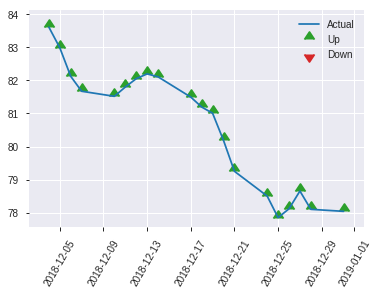


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2553878758847109
RMSE: 0.5053591553387659
LogLoss: 0.704104969072067
Null degrees of freedom: 255
Residual degrees of freedom: 250
Null deviance: 356.1260369634925
Residual deviance: 360.5017441648983
AIC: 372.5017441648983
AUC: 0.5794025639452861
pr_auc: 0.5361808210389983
Gini: 0.15880512789057222
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4775983199956508: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   126  0.9197   (126.0/137.0)
1      4    115  0.0336   (4.0/119.0)
Total  15   241  0.5078   (130.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477598     0.638889  240
max f2                       0.410747     0.812842  255
max f0point5                 0.543059     0.556831  187
max accuracy                 0.585532     0.578125  110
max precision                0.793127     1         0
max recall                   0.410747     1         255
max specificity              0.793127     1         0
max absolute_mcc             0.647441     0.179974  15
max min_per_class_accuracy   0.57889      0.562044  126
max mean_per_class_accuracy  0.575944     0.576796  135

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 57.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.70074            1.43417   1.43417            0.666667         0.745501  0.666667                    0.745501            0.0168067       0.0168067                  43.4174    43.4174
    2        0.0234375                   0.675349           2.15126   1.79272            1                0.687839  0.833333                    0.71667             0.0252101       0.0420168                  115.126    79.2717
    3        0.03125                     0.664891           1.07563   1.61345            0.5              0.665641  0.75                        0.703913            0.00840336      0.0504202                  7.56303    61.3445
    4        0.0429688                   0.662718           2.15126   1.76012            1                0.663986  0.818182                    0.693024            0.0252101       0.0756303                  115.126    76.0122
    5        0.0507812                   0.653823           1.07563   1.65482            0.5              0.658889  0.769231                    0.687772            0.00840336      0.0840336                  7.56303    65.4816
    6        0.101562                    0.634739           0.827408  1.24111            0.384615         0.642939  0.576923                    0.665356            0.0420168       0.12605                    -17.2592   24.1112
    7        0.152344                    0.628391           0.992889  1.15837            0.461538         0.631773  0.538462                    0.654161            0.0504202       0.176471                   -0.711054  15.8371
    8        0.203125                    0.620073           1.15837   1.15837            0.538462         0.622676  0.538462                    0.64629             0.0588235       0.235294                   15.8371    15.8371
    9        0.300781                    0.606169           1.03261   1.11754            0.48             0.611765  0.519481                    0.635081            0.10084         0.336134                   3.2605     11.7538
    10       0.402344                    0.590556           1.15837   1.12785            0.538462         0.597681  0.524272                    0.62564             0.117647        0.453782                   15.8371    12.7845
    11       0.5                         0.57862            1.20471   1.14286            0.56             0.583903  0.53125                     0.617488            0.117647        0.571429                   20.4706    14.2857
    12       0.601562                    0.564788           0.992889  1.11754            0.461538         0.571347  0.519481                    0.609698            0.10084         0.672269                   -0.711054  11.7538
    13       0.699219                    0.549553           0.946555  1.09366            0.44             0.556505  0.50838                     0.602269            0.092437        0.764706                   -5.34454   9.36576
    14       0.800781                    0.533977           0.910149  1.07038            0.423077         0.541629  0.497561                    0.594578            0.092437        0.857143                   -8.98513   7.03833
    15       0.898438                    0.499687           0.774454  1.03822            0.36             0.51945   0.482609                    0.586412            0.0756303       0.932773                   -22.5546   3.8217
    16       1                           0.410747           0.661926  1                  0.307692         0.463177  0.464844                    0

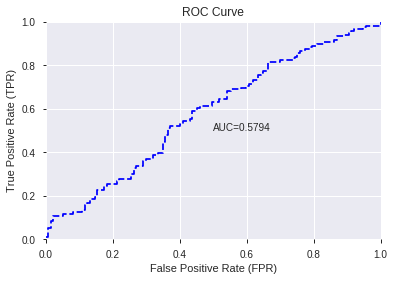

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


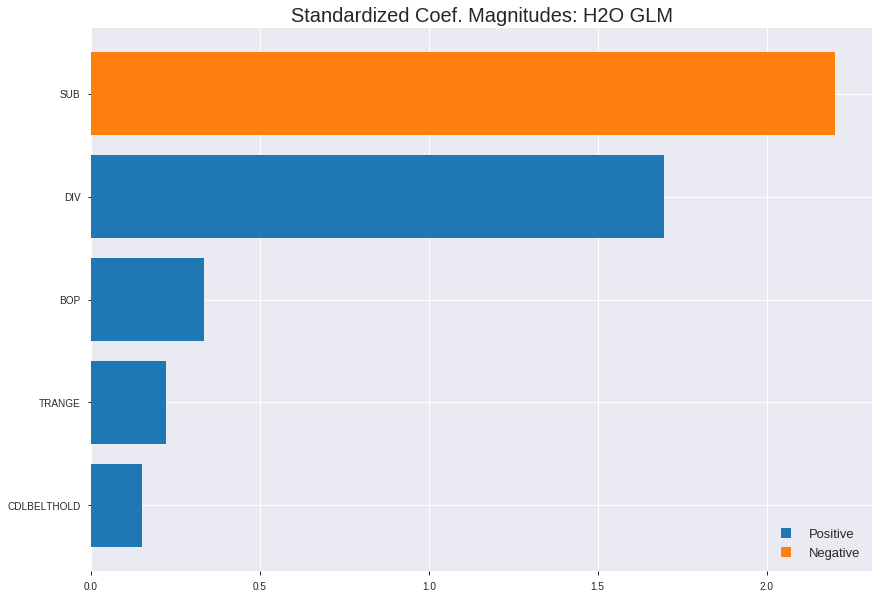

'log_likelihood'
--2019-08-22 11:09:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_110950_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_110950_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['SUB', 'DIV', 'BOP', 'TRANGE', 'CDLBELTHOLD']

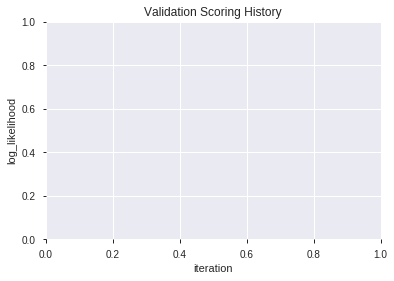

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190822_111002  0.551494  0.705131              0.455867  0.505376  0.255404
1               XGBoost_2_AutoML_20190822_111002  0.551003  0.705664              0.452769  0.505609  0.255640
2  XGBoost_grid_1_AutoML_20190822_111002_model_6  0.550635  0.707759              0.447464  0.506580  0.256623
3  XGBoost_grid_1_AutoML_20190822_111002_model_4  0.544286  0.703670              0.468809  0.504921  0.254945
4  XGBoost_grid_1_AutoML_20190822_111002_model_7  0.542784  0.712223              0.457308  0.508402  0.258473
5               XGBoost_1_AutoML_20190822_111002  0.533583  0.715438              0.435625  0.509832  0.259929
6  XGBoost_grid_1_AutoML_20190822_111002_model_1  0.532969  0.713424              0.492701  0.509274  0.259360
7  XGBoost_grid_1_AutoML_20190822_111002_model_2  0.532325  0.708927              0.453659  0.507325  0.257378
8  XGBoost_grid_1_AutoML_20190822_111002_model_3  0.522695  0.706559              0.472459  0.506365  0.256405
9  XGBoost_grid_1_AutoML_20190822_111002_model_5  0.518862  0.733190              0.479758  0.517801  0.268118

variable  relative_importance  scaled_importance  percentage
0          BOP          1105.398804           1.000000    0.356658
1          SUB           846.887268           0.766137    0.273249
2          DIV           676.453003           0.611954    0.218258
3       TRANGE           342.773743           0.310091    0.110596
4  CDLBELTHOLD           127.813713           0.115627    0.041239

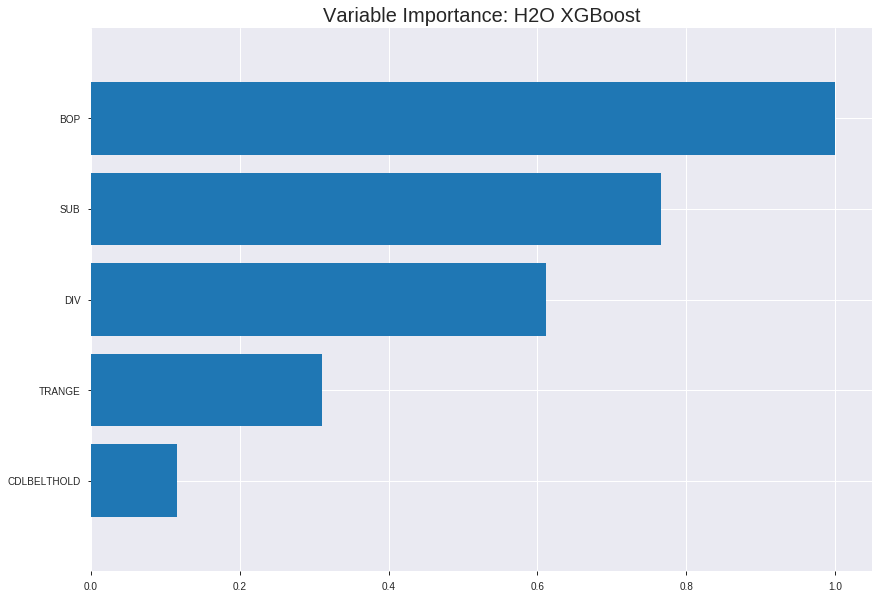

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190822_111002


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20890985654434288
RMSE: 0.457066577802778
LogLoss: 0.6066870860835947
Mean Per-Class Error: 0.2939710812027818
AUC: 0.7645857307249712
pr_auc: 0.7711676891416559
Gini: 0.5291714614499423
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45770588517189026: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      405  464   0.5339   (464.0/869.0)
1      118  802   0.1283   (118.0/920.0)
Total  523  1266  0.3253   (582.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457706     0.73376   253
max f2                       0.32084      0.852422  344
max f0point5                 0.518761     0.717401  192
max accuracy                 0.513034     0.705981  198
max precision                0.849233     1         0
max recall                   0.171069     1         391
max specificity              0.849233     1         0
max absolute_mcc             0.513034     0.411905  198
max min_per_class_accuracy   0.513034     0.704348  198
max mean_per_class_accuracy  0.513034     0.706029  198

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 51.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.780575           1.94457   1.94457            1                0.811316  1                           0.811316            0.0195652       0.0195652                  94.4565   94.4565
    2        0.020123                    0.753853           1.94457   1.94457            1                0.764197  1                           0.787757            0.0195652       0.0391304                  94.4565   94.4565
    3        0.0301845                   0.724573           1.7285    1.87254            0.888889         0.739876  0.962963                    0.771797            0.0173913       0.0565217                  72.8502   87.2544
    4        0.0402459                   0.712896           1.7285    1.83653            0.888889         0.719039  0.944444                    0.758607            0.0173913       0.073913                   72.8502   83.6534
    5        0.0503074                   0.706275           1.7285    1.81493            0.888889         0.709775  0.933333                    0.748841            0.0173913       0.0913043                  72.8502   81.4928
    6        0.100056                    0.668802           1.66053   1.73816            0.853933         0.68489   0.893855                    0.717044            0.0826087       0.173913                   66.0528   73.8159
    7        0.150363                    0.641604           1.59886   1.69155            0.822222         0.655528  0.869888                    0.696463            0.0804348       0.254348                   59.8865   69.1555
    8        0.200112                    0.622359           1.52943   1.65125            0.786517         0.632139  0.849162                    0.680472            0.076087        0.330435                   52.9433   65.1251
    9        0.300168                    0.582451           1.15153   1.48468            0.592179         0.602236  0.763501                    0.654393            0.115217        0.445652                   15.153    48.4677
    10       0.400224                    0.545672           1.30362   1.43941            0.670391         0.562434  0.740223                    0.631403            0.130435        0.576087                   30.3619   43.9413
    11       0.500279                    0.513554           1.23844   1.39922            0.636872         0.528969  0.719553                    0.610916            0.123913        0.7                        23.8438   39.9218
    12       0.599776                    0.483966           0.863037  1.31027            0.44382          0.499609  0.673812                    0.592452            0.0858696       0.78587                    -13.6963  31.0271
    13       0.699832                    0.459399           0.793035  1.23632            0.407821         0.470849  0.635783                    0.575066            0.0793478       0.865217                   -20.6965  23.6321
    14       0.799888                    0.424532           0.608356  1.15777            0.312849         0.443197  0.595388                    0.558571            0.0608696       0.926087                   -39.1644  15.777
    15       0.899944                    0.341248           0.46713   1.08099            0.240223         0.389464  0.555901                    0.539769            0.0467391       0.972826                   -53.287   8.0985
    16       1                           0.141682           0.271587  1                  0.139665         0.267578  0.514254                    0.512535           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23926297551136372
RMSE: 0.4891451476927515
LogLoss: 0.6710975186875701
Mean Per-Class Error: 0.405346687211094
AUC: 0.6095762711864408
pr_auc: 0.65117568039055
Gini: 0.2191525423728815
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30832482874393463: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   225  0.9534   (225.0/236.0)
1      3    272  0.0109   (3.0/275.0)
Total  14   497  0.4462   (228.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.308325     0.704663  387
max f2                       0.277369     0.854037  398
max f0point5                 0.480289     0.623912  285
max accuracy                 0.480289     0.594912  285
max precision                0.731282     1         0
max recall                   0.277369     1         398
max specificity              0.731282     1         0
max absolute_mcc             0.595158     0.210231  115
max min_per_class_accuracy   0.533936     0.556364  201
max mean_per_class_accuracy  0.595158     0.594653  115

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 53.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.689952           1.85818   1.85818            1                0.704002  1                           0.704002            0.0218182       0.0218182                  85.8182   85.8182
    2        0.0215264                   0.681961           1.48655   1.68926            0.8              0.684628  0.909091                    0.695196            0.0145455       0.0363636                  48.6545   68.9256
    3        0.0313112                   0.676432           1.48655   1.62591            0.8              0.678932  0.875                       0.690113            0.0145455       0.0509091                  48.6545   62.5909
    4        0.0410959                   0.670969           1.11491   1.50424            0.6              0.673941  0.809524                    0.686263            0.0109091       0.0618182                  11.4909   50.4242
    5        0.0508806                   0.669398           1.48655   1.50084            0.8              0.670251  0.807692                    0.683184            0.0145455       0.0763636                  48.6545   50.0839
    6        0.101761                    0.644882           1.1435    1.32217            0.615385         0.657461  0.711538                    0.670322            0.0581818       0.134545                   14.3497   32.2168
    7        0.150685                    0.632018           1.33789   1.32727            0.72             0.637692  0.714286                    0.659728            0.0654545       0.2                        33.7891   32.7273
    8        0.201566                    0.615002           1.28643   1.31696            0.692308         0.622724  0.708738                    0.650387            0.0654545       0.265455                   28.6434   31.6964
    9        0.30137                     0.586674           1.16592   1.26694            0.627451         0.600084  0.681818                    0.633728            0.116364        0.381818                   16.5918   26.6942
    10       0.401174                    0.556448           0.983743  1.19649            0.529412         0.572293  0.643902                    0.618444            0.0981818       0.48                       -1.62567  19.6488
    11       0.500978                    0.53369            0.765134  1.11055            0.411765         0.544579  0.597656                    0.603729            0.0763636       0.556364                   -23.4866  11.0554
    12       0.600783                    0.512484           0.983743  1.08949            0.529412         0.523871  0.586319                    0.590463            0.0981818       0.654545                   -1.62567  8.94877
    13       0.700587                    0.482559           1.12948   1.09519            0.607843         0.500089  0.589385                    0.577588            0.112727        0.767273                   12.9483   9.51854
    14       0.800391                    0.457192           0.692264  1.04494            0.372549         0.468585  0.562347                    0.563996            0.0690909       0.836364                   -30.7736  4.49433
    15       0.900196                    0.425348           0.838004  1.022              0.45098          0.44246   0.55                        0.550521            0.0836364       0.92                       -16.1996  2.2
    16       1                           0.229124           0.801569  1                  0.431373         0.354428  0.53816                     0.53095             0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:10:05  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.485746                         0.5                0.693147              0.5               0                    1                  0.46184
    2019-08-22 11:10:05  0.075 sec   5                  0.49037          0.674004            0.700944        0.708831           1.84222          0.36948                          0.496339           0.685835              0.597481          0.61883              1.01355            0.448141
    2019-08-22 11:10:05  0.131 sec   10                 0.483037         0.65943             0.71469         0.719167           1.83653          0.35886                          0.494245           0.681648              0.594961          0.6196               0.619394           0.446184
    2019-08-22 11:10:05  0.190 sec   15                 0.477164         0.647665            0.725308        0.734859           1.94457          0.339296                         0.491928           0.676988              0.602851          0.625247             0.929091           0.448141
    2019-08-22 11:10:05  0.248 sec   20                 0.472659         0.638542            0.732529        0.741703           1.94457          0.340973                         0.490442           0.673958              0.607034          0.629285             0.619394           0.452055
    2019-08-22 11:10:05  0.308 sec   25                 0.469124         0.631292            0.737107        0.747601           1.94457          0.34768                          0.489721           0.672437              0.606926          0.637294             1.23879            0.44227
    2019-08-22 11:10:05  0.366 sec   30                 0.466206         0.625289            0.74241         0.752209           1.94457          0.344885                         0.489423           0.671787              0.607966          0.642688             1.54848            0.444227
    2019-08-22 11:10:05  0.427 sec   35                 0.463779         0.620279            0.747753        0.758057           1.94457          0.337619                         0.489078           0.671025              0.609222          0.650529             1.85818            0.444227
    2019-08-22 11:10:05  0.493 sec   40                 0.461135         0.614932            0.754582        0.762924           1.94457          0.336501                         0.488803           0.67044               0.61161           0.654398             1.85818            0.44227
    2019-08-22 11:10:06  0.562 sec   45                 0.45916          0.610881            0.758764        0.765818           1.94457          0.334824                         0.488908           0.670604              0.610601          0.654511             1.85818            0.44227
    2019-08-22 11:10:06  0.622 sec   50                 0.457067         0.606687            0.764586        0.771168           1.94457          0.325321                         0.489145           0.671098              0.609576          0.651176             1.85818            0.446184

Variable Importances: 


variable     relative_importance    scaled_importance    percentage
-----------  ---------------------  -------------------  ------------
BOP          1105.4                 1                    0.356658
SUB          846.887                0.766137             0.273249
DIV          676.453                0.611954             0.218258
TRANGE       342.774                0.310091             0.110596
CDLBELTHOLD  127.814                0.115627             0.0412392

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.58203125)

('F1', 0.6457142857142857)

('auc', 0.5514935901367847)

('logloss', 0.7051313278087095)

('mean_per_class_error', 0.4103845917929215)

('rmse', 0.5053755738645684)

('mse', 0.2554044706589419)

xgboost prediction progress: |████████████████████████████████████████████| 100%


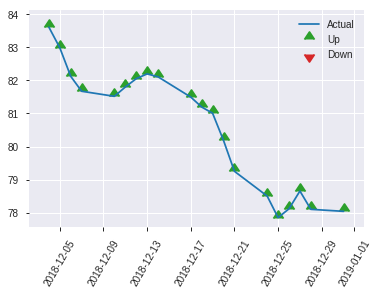


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2554044706589419
RMSE: 0.5053755738645684
LogLoss: 0.7051313278087095
Mean Per-Class Error: 0.4103845917929215
AUC: 0.5514935901367847
pr_auc: 0.46351204603664714
Gini: 0.10298718027356935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45215439796447754: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   118  0.8613   (118.0/137.0)
1      6    113  0.0504   (6.0/119.0)
Total  25   231  0.4844   (124.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452154     0.645714  222
max f2                       0.4026       0.817308  239
max f0point5                 0.520631     0.564626  151
max accuracy                 0.522583     0.582031  147
max precision                0.522583     0.54      147
max recall                   0.4026       1         239
max specificity              0.705226     0.992701  0
max absolute_mcc             0.520631     0.182594  151
max min_per_class_accuracy   0.538275     0.569343  125
max mean_per_class_accuracy  0.520631     0.589615  151

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 54.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.695143           0.717087  0.717087           0.333333         0.69946   0.333333                    0.69946             0.00840336      0.00840336                 -28.2913  -28.2913
    2        0.0234375                   0.69111            0         0.358543           0                0.692819  0.166667                    0.69614             0               0.00840336                 -100      -64.1457
    3        0.03125                     0.685795           2.15126   0.806723           1                0.688229  0.375                       0.694162            0.0168067       0.0252101                  115.126   -19.3277
    4        0.0429688                   0.674363           0         0.586707           0                0.678224  0.272727                    0.689815            0               0.0252101                  -100      -41.3293
    5        0.0507812                   0.672073           1.07563   0.661926           0.5              0.67375   0.307692                    0.687344            0.00840336      0.0336134                  7.56303   -33.8074
    6        0.101562                    0.652669           0.661926  0.661926           0.307692         0.661816  0.307692                    0.67458             0.0336134       0.0672269                  -33.8074  -33.8074
    7        0.152344                    0.63936            0.827408  0.717087           0.384615         0.644994  0.333333                    0.664718            0.0420168       0.109244                   -17.2592  -28.2913
    8        0.203125                    0.623189           1.15837   0.827408           0.538462         0.62856   0.384615                    0.655678            0.0588235       0.168067                   15.8371   -17.2592
    9        0.300781                    0.590928           1.20471   0.949907           0.56             0.605968  0.441558                    0.639539            0.117647        0.285714                   20.4706   -5.00928
    10       0.402344                    0.565303           1.40659   1.06519            0.653846         0.579182  0.495146                    0.624303            0.142857        0.428571                   40.6593   6.51872
    11       0.5                         0.53719            1.46286   1.14286            0.68             0.548768  0.53125                     0.60955             0.142857        0.571429                   46.2857   14.2857
    12       0.601562                    0.520631           1.24111   1.15945            0.576923         0.528201  0.538961                    0.595816            0.12605         0.697479                   24.1112   15.9446
    13       0.699219                    0.499854           0.602353  1.08164            0.28             0.510829  0.502793                    0.583946            0.0588235       0.756303                   -39.7647  8.16394
    14       0.800781                    0.477512           1.07563   1.08088            0.5              0.488996  0.502439                    0.571904            0.109244        0.865546                   7.56303   8.08772
    15       0.898438                    0.453929           0.774454  1.04757            0.36             0.465998  0.486957                    0.560392            0.0756303       0.941176                   -22.5546  4.75703
    16       1                           0.345802           0.579186  1                  0.269231         0.422287  0.464844                    0.546366

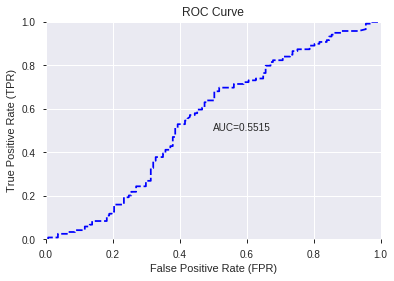

This function is available for GLM models only


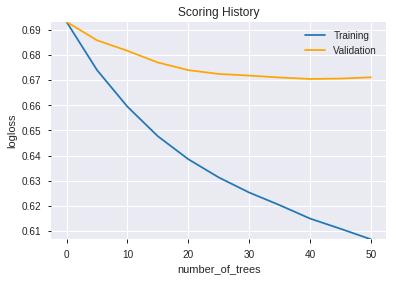

--2019-08-22 11:10:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190822_111002',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190822_111002',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_af23',
   'type

['BOP', 'SUB', 'DIV', 'TRANGE', 'CDLBELTHOLD']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

168

['WMA_14',
 'MA_14_0',
 'BBANDS_upperband_14_0_2',
 'BBANDS_middleband_14_0_2',
 'BBANDS_upperband_14_0_3',
 'BBANDS_middleband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_upperband_14_0_5',
 'BBANDS_lowerband_14_0_5',
 'BBANDS_middleband_14_1_2',
 'BBANDS_upperband_14_1_3',
 'BBANDS_lowerband_14_1_3',
 'MA_14_2',
 'BBANDS_middleband_14_2_5',
 'BBANDS_lowerband_14_2_5',
 'BBANDS_middleband_14_3_2',
 'BBANDS_upperband_14_3_4',
 'BBANDS_middleband_14_3_4',
 'BBANDS_lowerband_14_3_4',
 'BBANDS_upperband_14_3_5',
 'BBANDS_lowerband_14_3_5',
 'MA_14_4',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_upperband_14_6_4',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_lowerband_14_7_5',
 'EMA_20',
 'TRIMA_20',
 'MA_20_0',
 'BBANDS_middleband_20_0_3',
 'BBANDS_upperband_20_1_2',
 'BBANDS_upperband_20_1_3',
 'BBANDS_middleband_20_1_3',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_middleband_20_1_4',
 'MA_20_2',
 'BBANDS_upperband_20_3_2',


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_111157_model_6  0.596332  0.690091              0.431638  0.498495  0.248497
1  DeepLearning_grid_1_AutoML_20190822_111157_model_8  0.584371  0.722754              0.464608  0.514383  0.264590
2  DeepLearning_grid_1_AutoML_20190822_111157_model_5  0.579035  0.709764              0.460621  0.508182  0.258249
3  DeepLearning_grid_1_AutoML_20190822_111157_model_7  0.546587  0.773908              0.429768  0.533880  0.285028
4  DeepLearning_grid_1_AutoML_20190822_111157_model_2  0.545053  1.139596              0.493253  0.608003  0.369668
5  DeepLearning_grid_1_AutoML_20190822_111157_model_9  0.544869  0.709393              0.478102  0.507896  0.257958
6  DeepLearning_grid_1_AutoML_20190822_111157_model_4  0.540085  0.907771              0.478654  0.562170  0.316035
7  DeepLearning_grid_1_AutoML_20190822_111157_model_3  0.538981  0.887053              0.496350  0.567511  0.322069
8               DeepLearning_1_AutoML_20190822_111157  0.511194  0.888584              0.496350  0.574059  0.329544
9  DeepLearning_grid_1_AutoML_20190822_111157_model_1  0.488622  1.792511              0.500000  0.644705  0.415644

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.011510
1              CDLRICKSHAWMAN             0.797317           0.797317    0.009177
2                   CORREL_12             0.623909           0.623909    0.007181
3                STOCHF_fastk             0.619272           0.619272    0.007128
4                 CDLBELTHOLD             0.609859           0.609859    0.007020
..                        ...                  ...                ...         ...
163   BBANDS_lowerband_14_3_4             0.466516           0.466516    0.005370
164  BBANDS_middleband_14_3_2             0.464616           0.464616    0.005348
165                ROCR100_20             0.463716           0.463716    0.005337
166  BBANDS_middleband_30_7_2             0.460048           0.460048    0.005295
167   BBANDS_lowerband_14_2_5             0.455670           0.455670    0.005245

[168 rows x 4 columns]

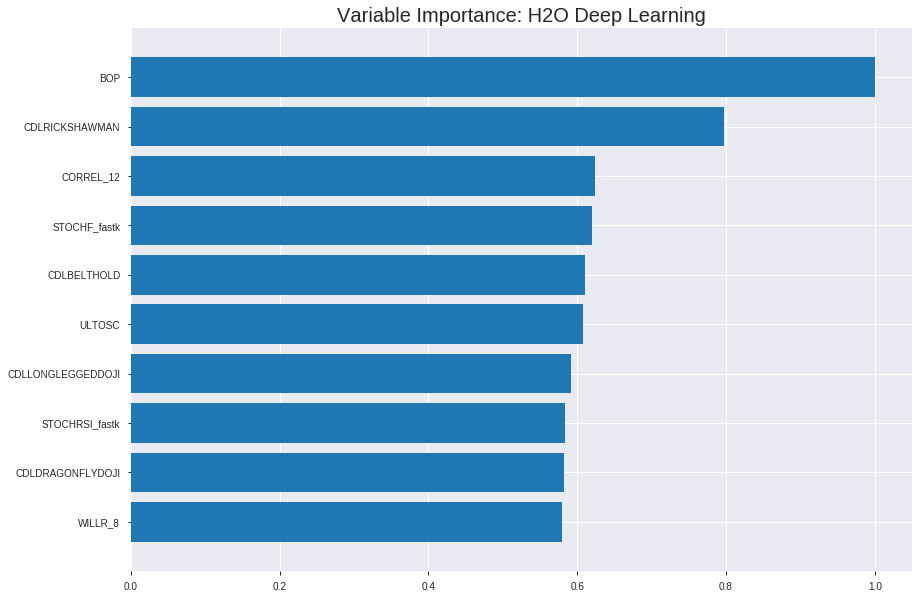

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_111157_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2333484814586272
RMSE: 0.4830615710845018
LogLoss: 0.6582476018603506
Mean Per-Class Error: 0.38941812177915636
AUC: 0.6548068744684045
pr_auc: 0.6531510291108752
Gini: 0.30961374893680893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38647835609717046: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      113  756   0.87     (756.0/869.0)
1      20   900   0.0217   (20.0/920.0)
Total  133  1656  0.4338   (776.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386478     0.698758  318
max f2                       0.357606     0.846669  334
max f0point5                 0.505465     0.62453   196
max accuracy                 0.505465     0.613751  196
max precision                0.829704     1         0
max recall                   0.130101     1         391
max specificity              0.829704     1         0
max absolute_mcc             0.48906      0.228463  223
max min_per_class_accuracy   0.517926     0.601841  174
max mean_per_class_accuracy  0.505465     0.610582  196

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 50.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.712735           1.51244   1.51244            0.777778         0.753732  0.777778                    0.753732            0.0152174       0.0152174                  51.244    51.244
    2        0.020123                    0.672124           1.83653   1.67449            0.944444         0.692455  0.861111                    0.723094            0.0184783       0.0336957                  83.6534   67.4487
    3        0.0301845                   0.649973           1.40441   1.58446            0.722222         0.660574  0.814815                    0.702254            0.0141304       0.0478261                  40.4408   58.4461
    4        0.0402459                   0.631519           1.51244   1.56646            0.777778         0.639734  0.805556                    0.686624            0.0152174       0.0630435                  51.244    56.6455
    5        0.0503074                   0.615502           1.62047   1.57726            0.833333         0.622835  0.811111                    0.673866            0.0163043       0.0793478                  62.0471   57.7258
    6        0.100056                    0.575822           1.42019   1.49916            0.730337         0.592101  0.77095                     0.633212            0.0706522       0.15                       42.0188   49.9162
    7        0.150363                    0.559757           1.14513   1.38071            0.588889         0.566472  0.710037                    0.610883            0.0576087       0.207609                   14.5133   38.0714
    8        0.200112                    0.550184           1.31094   1.36337            0.674157         0.55473   0.701117                    0.596923            0.0652174       0.272826                   31.0943   36.3368
    9        0.300168                    0.538597           1.10808   1.27827            0.569832         0.54344   0.657356                    0.579095            0.11087         0.383696                   10.8076   27.8271
    10       0.400224                    0.527998           1.08635   1.23029            0.558659         0.532914  0.632682                    0.56755             0.108696        0.492391                   8.63493   23.0291
    11       0.500279                    0.518214           1.10808   1.20585            0.569832         0.523013  0.620112                    0.558643            0.11087         0.603261                   10.8076   20.5848
    12       0.599776                    0.507184           0.983207  1.16891            0.505618         0.512747  0.601118                    0.551029            0.0978261       0.701087                   -1.67929  16.8914
    13       0.699832                    0.49184            0.988578  1.14313            0.50838          0.499984  0.587859                    0.543731            0.098913        0.8                        -1.14222  14.3131
    14       0.799888                    0.465934           0.825625  1.10342            0.424581         0.480372  0.567435                    0.535806            0.0826087       0.882609                   -17.4375  10.3415
    15       0.899944                    0.409289           0.727854  1.06166            0.374302         0.442815  0.545963                    0.525467            0.0728261       0.955435                   -27.2146  6.16601
    16       1                           0.059204           0.445403  1                  0.22905          0.323482  0.514254                    0.505257          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24254442538012616
RMSE: 0.492487995163462
LogLoss: 0.6779631626383913
Mean Per-Class Error: 0.3906471494607088
AUC: 0.613497688751926
pr_auc: 0.6107823461359204
Gini: 0.226995377503852
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2315574224770097: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    233  0.9873   (233.0/236.0)
1      0    275  0        (0.0/275.0)
Total  3    508  0.456    (233.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.231557     0.702427  396
max f2                       0.231557     0.8551    396
max f0point5                 0.536415     0.639743  213
max accuracy                 0.536415     0.612524  213
max precision                0.545772     0.669951  163
max recall                   0.231557     1         396
max specificity              0.75529      0.995763  0
max absolute_mcc             0.536415     0.219162  213
max min_per_class_accuracy   0.539504     0.588983  197
max mean_per_class_accuracy  0.536415     0.609353  213

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 53.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.672019           0.929091  0.929091           0.5              0.701223  0.5                         0.701223            0.0109091       0.0109091                  -7.09091   -7.09091
    2        0.0215264                   0.659426           1.11491   1.01355            0.6              0.665649  0.545455                    0.685053            0.0109091       0.0218182                  11.4909    1.35537
    3        0.0313112                   0.647425           0.743273  0.929091           0.4              0.652286  0.5                         0.674813            0.00727273      0.0290909                  -25.6727   -7.09091
    4        0.0410959                   0.634406           1.85818   1.1503             1                0.640946  0.619048                    0.666749            0.0181818       0.0472727                  85.8182    15.0303
    5        0.0508806                   0.628551           1.11491   1.1435             0.6              0.630193  0.615385                    0.659719            0.0109091       0.0581818                  11.4909    14.3497
    6        0.101761                    0.603951           1.1435    1.1435             0.615385         0.613623  0.615385                    0.636671            0.0581818       0.116364                   14.3497    14.3497
    7        0.150685                    0.590624           1.41222   1.23074            0.76             0.596037  0.662338                    0.623478            0.0690909       0.185455                   41.2218    23.0744
    8        0.201566                    0.578172           1.00056   1.17264            0.538462         0.585524  0.631068                    0.613898            0.0509091       0.236364                   0.0559441  17.2639
    9        0.30137                     0.555909           1.23879   1.19455            0.666667         0.565625  0.642857                    0.597911            0.123636        0.36                       23.8788    19.4545
    10       0.401174                    0.545643           1.34809   1.23275            0.72549          0.550125  0.663415                    0.586023            0.134545        0.494545                   34.8093    23.2745
    11       0.500978                    0.540057           0.838004  1.15411            0.45098          0.54303   0.621094                    0.577458            0.0836364       0.578182                   -16.1996   15.4105
    12       0.600783                    0.531901           1.05661   1.13791            0.568627         0.536008  0.612378                    0.570572            0.105455        0.683636                   5.66132    13.7909
    13       0.700587                    0.519026           0.874439  1.10038            0.470588         0.526458  0.592179                    0.564288            0.0872727       0.770909                   -12.5561   10.0376
    14       0.800391                    0.500955           0.801569  1.06312            0.431373         0.509465  0.572127                    0.557452            0.08            0.850909                   -19.8431   6.31162
    15       0.900196                    0.460507           0.765134  1.03008            0.411765         0.483451  0.554348                    0.549247            0.0763636       0.927273                   -23.4866   3.00791
    16       1                           0.0536383          0.728699  1                  0.392157         0.367522  0.53816                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:17:15  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 11:17:17  2 min 18.034 sec  781 obs/sec       0.785914  1             1406       0.635463         1.78215             -0.616566      0.518883        0.498976           0.972283         0.477921                         0.616152           1.28522               -0.527469        0.518659          0.566677             1.54848            0.459883
    2019-08-22 11:17:25  2 min 26.331 sec  1330 obs/sec      6.94634   9             12427      0.493098         0.679054            0.0266248      0.613993        0.616042           1.40441          0.446618                         0.499311           0.692004              -0.00308726      0.560293          0.578961             0.929091           0.457926
    2019-08-22 11:17:32  2 min 34.003 sec  1625 obs/sec      14.7367   19            26364      0.483062         0.658248            0.0658469      0.654807        0.653151           1.51244          0.433762                         0.492488           0.677963              0.024138         0.613498          0.610782             0.929091           0.455969
    2019-08-22 11:17:41  2 min 42.014 sec  1775 obs/sec      23.3069   30            41696      0.472417         0.634698            0.106564       0.686178        0.683808           1.83653          0.405254                         0.497078           0.690239              0.00586409       0.594361          0.599767             1.23879            0.452055
    2019-08-22 11:17:48  2 min 49.868 sec  1863 obs/sec      31.8368   41            56956      0.476566         0.642305            0.0908005      0.691523        0.695595           1.94457          0.386249                         0.499441           0.693797              -0.00361257      0.595501          0.602758             1.23879            0.446184
    2019-08-22 11:17:57  2 min 58.214 sec  1929 obs/sec      41.1342   53            73589      0.464921         0.618534            0.134691       0.716315        0.720524           1.94457          0.370039                         0.494573           0.684721              0.015856         0.589831          0.602439             0.929091           0.450098
    2019-08-22 11:18:04  3 min  5.889 sec  1972 obs/sec      49.6808   64            88879      0.460313         0.608545            0.151758       0.733201        0.734224           1.94457          0.348798                         0.493281           0.682709              0.0209917        0.605431          0.610822             0.929091           0.436399
    2019-08-22 11:18:05  3 min  6.680 sec  1971 obs/sec      49.6808   64            88879      0.483062         0.658248            0.0658469      0.654807        0.653151           1.51244          0.433762                         0.492488           0.677963              0.024138         0.613498          0.610782             0.929091           0.455969

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.011510196639716993
CDLRICKSHAWMAN            0.7973173260688782     0.7973173260688782   0.00917727920730614
CORREL_12                 0.6239088177680969     0.6239088177680969   0.007181313177764151
STOCHF_fastk              0.6192716360092163     0.6192716360092163   0.0071279383038653265
CDLBELTHOLD               0.6098589301109314     0.6098589301109314   0.007019596208064243
---                       ---                    ---                  ---
BBANDS_lowerband_14_3_4   0.46651604771614075    0.46651604771614075  0.005369691444796375
BBANDS_middleband_14_3_2  0.46461552381515503    0.46461552381515503  0.005347816040977548
ROCR100_20                0.46371617913246155    0.46371617913246155  0.005337464406832862
BBANDS_middleband_30_7_2  0.4600484371185303     0.4600484371185303   0.005295247975028761
BBANDS_lowerband_14_2_5   0.4556702673435211     0.4556702673435211   0.005244854379996341


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.58984375)

('F1', 0.6419753086419754)

('auc', 0.5963319634423112)

('logloss', 0.6900912545439783)

('mean_per_class_error', 0.41909464515733297)

('rmse', 0.4984948487388216)

('mse', 0.2484971142191406)

deeplearning prediction progress: |███████████████████████████████████████| 100%


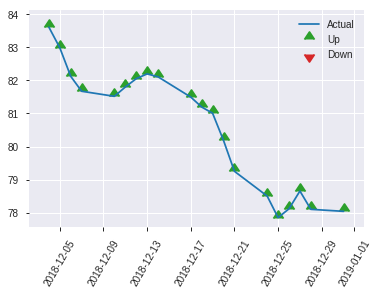


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2484971142191406
RMSE: 0.4984948487388216
LogLoss: 0.6900912545439783
Mean Per-Class Error: 0.41909464515733297
AUC: 0.5963319634423112
pr_auc: 0.5463688862020384
Gini: 0.19266392688462242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5092623779293017: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      36   101  0.7372   (101.0/137.0)
1      15   104  0.1261   (15.0/119.0)
Total  51   205  0.4531   (116.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509262     0.641975  204
max f2                       0.406738     0.813953  254
max f0point5                 0.510546     0.557377  198
max accuracy                 0.544612     0.589844  81
max precision                0.651953     1         0
max recall                   0.406738     1         254
max specificity              0.651953     1         0
max absolute_mcc             0.510546     0.178767  198
max min_per_class_accuracy   0.535648     0.562044  126
max mean_per_class_accuracy  0.542177     0.580905  93

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 53.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.632476           1.43417   1.43417            0.666667         0.641419  0.666667                    0.641419            0.0168067       0.0168067                  43.4174    43.4174
    2        0.0234375                   0.624955           1.43417   1.43417            0.666667         0.628892  0.666667                    0.635155            0.0168067       0.0336134                  43.4174    43.4174
    3        0.03125                     0.608916           2.15126   1.61345            1                0.615647  0.75                        0.630278            0.0168067       0.0504202                  115.126    61.3445
    4        0.0429688                   0.602943           0.717087  1.36898            0.333333         0.604722  0.636364                    0.623308            0.00840336      0.0588235                  -28.2913   36.8984
    5        0.0507812                   0.599097           2.15126   1.48933            1                0.602407  0.692308                    0.620093            0.0168067       0.0756303                  115.126    48.9334
    6        0.101562                    0.575736           0.992889  1.24111            0.461538         0.586563  0.576923                    0.603328            0.0504202       0.12605                    -0.711054  24.1112
    7        0.152344                    0.562623           1.15837   1.21353            0.538462         0.56904   0.564103                    0.591898            0.0588235       0.184874                   15.8371    21.3532
    8        0.203125                    0.554056           1.32385   1.24111            0.615385         0.558985  0.576923                    0.58367             0.0672269       0.252101                   32.3853    24.1112
    9        0.300781                    0.545203           1.29076   1.25723            0.6              0.549794  0.584416                    0.572671            0.12605         0.378151                   29.0756    25.723
    10       0.402344                    0.539277           0.992889  1.1905             0.461538         0.542567  0.553398                    0.565072            0.10084         0.478992                   -0.711054  19.0503
    11       0.5                         0.535491           0.860504  1.12605            0.4              0.537323  0.523438                    0.559652            0.0840336       0.563025                   -13.9496   12.605
    12       0.601562                    0.527062           1.07563   1.11754            0.5              0.531488  0.519481                    0.554897            0.109244        0.672269                   7.56303    11.7538
    13       0.699219                    0.517031           0.946555  1.09366            0.44             0.522505  0.50838                     0.550373            0.092437        0.764706                   -5.34454   9.36576
    14       0.800781                    0.509262           1.07563   1.09137            0.5              0.5133    0.507317                    0.545671            0.109244        0.87395                    7.56303    9.13712
    15       0.898438                    0.4865             0.602353  1.03822            0.28             0.498397  0.482609                    0.540533            0.0588235       0.932773                   -39.7647   3.8217
    16       1                           0.387996           0.661926  1                  0.307692         0.459219  0.464844                    0.5

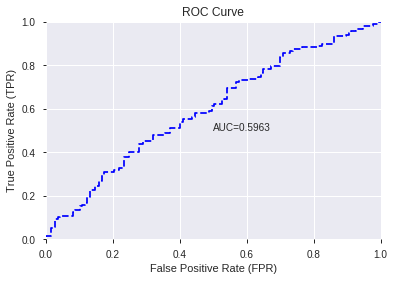

This function is available for GLM models only


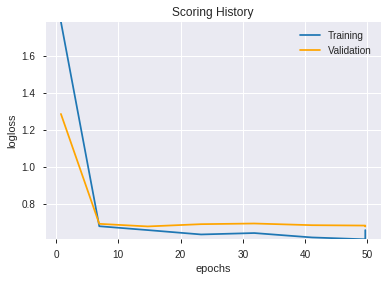

--2019-08-22 11:22:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_111157_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_111157_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLRICKSHAWMAN',
 'CORREL_12',
 'STOCHF_fastk',
 'CDLBELTHOLD',
 'ULTOSC',
 'CDLLONGLEGGEDDOJI',
 'STOCHRSI_fastk',
 'CDLDRAGONFLYDOJI',
 'WILLR_8',
 'NATR_24',
 'MINUS_DI_8',
 'aroondown_30',
 'DX_8',
 'CORREL_14',
 'WILLR_14',
 'MINUS_DM_20',
 'aroonup_20',
 'MINUS_DM_24',
 'PLUS_DI_8',
 'TRIX_8',
 'CCI_12',
 'CORREL_8',
 'CDLSPINNINGTOP',
 'ATR_12',
 'aroonup_8',
 'aroonup_30',
 'HT_PHASOR_quadrature',
 'aroonup_14',
 'STOCH_slowd',
 'PLUS_DM_30',
 'STOCHF_fastd',
 'ATR_14',
 'MINUS_DM_30',
 'DX_12',
 'CCI_20',
 'VAR_8',
 'PLUS_DI_14',
 'STOCHRSI_fastd',
 'MINUS_DI_24',
 'MACDEXT',
 'LINEARREG_ANGLE_12',
 'VAR_12',
 'aroonup_24',
 'CDLHIGHWAVE',
 'WILLR_12',
 'MINUS_DI_14',
 'BETA_8',
 'WILLR_30',
 'STDDEV_12',
 'PLUS_DI_30',
 'AROONOSC_8',
 'BBANDS_upperband_14_3_4',
 'BBANDS_upperband_20_6_5',
 'CCI_30',
 'CCI_24',
 'DX_30',
 'BBANDS_upperband_24_1_5',
 'NATR_20',
 'aroondown_20',
 'LINEARREG_ANGLE_14',
 'BETA_14',
 'AROONOSC_24',
 'ADX_24',
 'PPO',
 'MACD_hist',
 'MAVP_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_112220_model_1  0.598417  0.703794              0.418696  0.505086  0.255112

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.217161           1.000000    0.081362
1              CDLRICKSHAWMAN             0.094023           0.432963    0.035227
2                 CDLBELTHOLD             0.085374           0.393137    0.031986
3                STOCHF_fastk             0.060526           0.278713    0.022677
4                        DX_8             0.052983           0.243980    0.019851
..                        ...                  ...                ...         ...
163                    CMO_20             0.000123           0.000568    0.000046
164   BBANDS_upperband_14_3_5             0.000073           0.000336    0.000027
165                   MA_20_0             0.000055           0.000252    0.000020
166   BBANDS_lowerband_14_7_2             0.000046           0.000212    0.000017
167  BBANDS_middleband_20_0_3             0.000010           0.000046    0.000004

[168 rows x 4 columns]

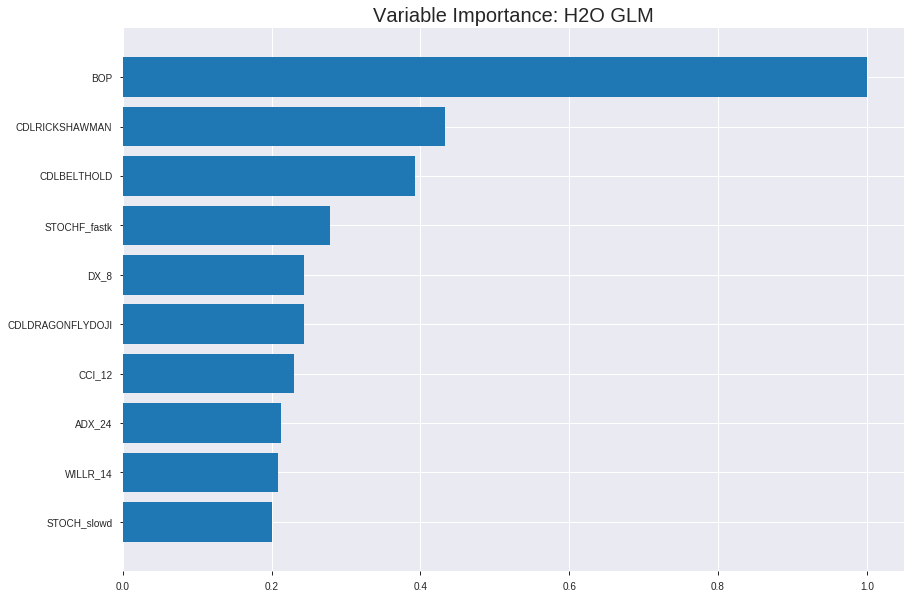

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_112220_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2324740098232851
RMSE: 0.482155586738643
LogLoss: 0.6570587604732472
Null degrees of freedom: 1788
Residual degrees of freedom: 1620
Null deviance: 2478.6265302036704
Residual deviance: 2350.9562449732784
AIC: 2688.9562449732784
AUC: 0.6555830039525692
pr_auc: 0.6481608564937247
Gini: 0.3111660079051384
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44958492722936555: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      293  576   0.6628   (576.0/869.0)
1      115  805   0.125    (115.0/920.0)
Total  408  1381  0.3862   (691.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449585     0.699696  279
max f2                       0.299419     0.844359  383
max f0point5                 0.45714      0.626192  272
max accuracy                 0.45714      0.615987  272
max precision                0.803621     1         0
max recall                   0.261161     1         392
max specificity              0.803621     1         0
max absolute_mcc             0.449585     0.252731  279
max min_per_class_accuracy   0.519153     0.609896  200
max mean_per_class_accuracy  0.514513     0.612047  206

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.741396           1.51244   1.51244            0.777778         0.765672  0.777778                    0.765672            0.0152174       0.0152174                  51.244    51.244
    2        0.020123                    0.703077           1.51244   1.51244            0.777778         0.719154  0.777778                    0.742413            0.0152174       0.0304348                  51.244    51.244
    3        0.0301845                   0.68837            1.29638   1.44042            0.666667         0.695658  0.740741                    0.726828            0.0130435       0.0434783                  29.6377   44.0419
    4        0.0402459                   0.673139           1.51244   1.45842            0.777778         0.679751  0.75                        0.715059            0.0152174       0.0586957                  51.244    45.8424
    5        0.0503074                   0.663442           1.51244   1.46923            0.777778         0.668788  0.755556                    0.705804            0.0152174       0.073913                   51.244    46.9227
    6        0.100056                    0.625911           1.44204   1.45571            0.741573         0.638569  0.748603                    0.672374            0.0717391       0.145652                   44.2037   45.5708
    7        0.150363                    0.605827           1.25316   1.38794            0.644444         0.615332  0.713755                    0.65329             0.0630435       0.208696                   25.3164   38.7942
    8        0.200112                    0.590035           1.1143    1.31991            0.573034         0.59711   0.678771                    0.639323            0.0554348       0.26413                    11.4301   31.9914
    9        0.300168                    0.563125           1.27103   1.30362            0.653631         0.576755  0.670391                    0.618467            0.127174        0.391304                   27.1029   30.3619
    10       0.400224                    0.543588           1.06462   1.24387            0.547486         0.553423  0.639665                    0.602206            0.106522        0.497826                   6.46223   24.387
    11       0.500279                    0.519449           1.09721   1.21454            0.564246         0.53097   0.624581                    0.587959            0.109783        0.607609                   9.72128   21.4538
    12       0.599776                    0.495537           0.91766   1.16529            0.47191          0.507886  0.599254                    0.574675            0.0913043       0.698913                   -8.234    16.5289
    13       0.699832                    0.472149           0.966851  1.13692            0.497207         0.484553  0.584665                    0.561791            0.0967391       0.795652                   -3.31491  13.6918
    14       0.799888                    0.437518           0.945124  1.11293            0.486034         0.455767  0.572327                    0.548528            0.0945652       0.890217                   -5.48761  11.2927
    15       0.899944                    0.38875            0.619219  1.05804            0.318436         0.415606  0.544099                    0.53375             0.0619565       0.952174                   -38.0781  5.80367
    16       1                           0.167923           0.477994  1                  0.24581          0.338896  0.514254                    0.514254            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24156945575985
RMSE: 0.49149715742804656
LogLoss: 0.6761071190279152
Null degrees of freedom: 510
Residual degrees of freedom: 342
Null deviance: 706.5876756969492
Residual deviance: 690.9814756465294
AIC: 1028.9814756465294
AUC: 0.5997611710323574
pr_auc: 0.6195985056963003
Gini: 0.19952234206471475
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4241754715133951: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      24   212  0.8983   (212.0/236.0)
1      10   265  0.0364   (10.0/275.0)
Total  34   477  0.4344   (222.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424175     0.704787  365
max f2                       0.27145      0.854568  397
max f0point5                 0.567787     0.623608  200
max accuracy                 0.5683       0.594912  198
max precision                0.703685     0.75      3
max recall                   0.27145      1         397
max specificity              0.750774     0.995763  0
max absolute_mcc             0.5683       0.187937  198
max min_per_class_accuracy   0.569036     0.588983  195
max mean_per_class_accuracy  0.5683       0.594191  198

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 55.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.689849           1.23879   1.23879            0.666667         0.709069  0.666667                    0.709069            0.0145455       0.0145455                  23.8788   23.8788
    2        0.0215264                   0.670164           1.11491   1.18248            0.6              0.677553  0.636364                    0.694743            0.0109091       0.0254545                  11.4909   18.2479
    3        0.0313112                   0.661772           1.48655   1.2775             0.8              0.665575  0.6875                      0.685628            0.0145455       0.04                       48.6545   27.75
    4        0.0410959                   0.657836           1.11491   1.23879            0.6              0.659857  0.666667                    0.679492            0.0109091       0.0509091                  11.4909   23.8788
    5        0.0508806                   0.652896           1.48655   1.28643            0.8              0.655913  0.692308                    0.674958            0.0145455       0.0654545                  48.6545   28.6434
    6        0.101761                    0.637261           1.3579    1.32217            0.730769         0.646507  0.711538                    0.660732            0.0690909       0.134545                   35.7902   32.2168
    7        0.150685                    0.627025           1.26356   1.30314            0.68             0.631935  0.701299                    0.651383            0.0618182       0.196364                   26.3564   30.314
    8        0.201566                    0.616319           1.07203   1.2448             0.576923         0.622278  0.669903                    0.644036            0.0545455       0.250909                   7.2028    24.4801
    9        0.30137                     0.601043           0.947308  1.14628            0.509804         0.608557  0.616883                    0.632286            0.0945455       0.345455                   -5.26916  14.6281
    10       0.401174                    0.587165           1.12948   1.1421             0.607843         0.594479  0.614634                    0.622881            0.112727        0.458182                   12.9483   14.2102
    11       0.500978                    0.569559           1.20235   1.15411            0.647059         0.578112  0.621094                    0.613962            0.12            0.578182                   20.2353   15.4105
    12       0.600783                    0.549067           0.692264  1.07738            0.372549         0.55965   0.579805                    0.604939            0.0690909       0.647273                   -30.7736  7.73823
    13       0.700587                    0.520179           1.12948   1.0848             0.607843         0.536713  0.583799                    0.59522             0.112727        0.76                       12.9483   8.48045
    14       0.800391                    0.493437           0.910873  1.06312            0.490196         0.506227  0.572127                    0.584123            0.0909091       0.850909                   -8.91266  6.31162
    15       0.900196                    0.444662           0.801569  1.03412            0.431373         0.474585  0.556522                    0.571979            0.08            0.930909                   -19.8431  3.41186
    16       1                           0.252439           0.692264  1                  0.372549         0.385767  0.53816                     0.553394            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 11:22:20  0.000 sec   2            8.9       169           1.37699           1.37809
    2019-08-22 11:22:20  0.084 sec   4            6.4       169           1.37492           1.37674
    2019-08-22 11:22:20  0.167 sec   6            4.7       169           1.37239           1.37507
    2019-08-22 11:22:20  0.249 sec   8            3.4       169           1.36927           1.37304
    2019-08-22 11:22:20  0.335 sec   10           2.5       169           1.3655            1.37066
    2019-08-22 11:22:20  0.418 sec   12           1.8       169           1.36104           1.36795
    2019-08-22 11:22:21  0.506 sec   14           1.3       169           1.35592           1.36502
    2019-08-22 11:22:21  0.595 sec   16           0.96      169           1.35022           1.362
    2019-08-22 11:22:21  0.688 sec   18           0.7       169           1.34411           1.35911
    2019-08-22 11:22:21  0.770 sec   20           0.51      169           1.33778           1.35651
    2019-08-22 11:22:21  0.852 sec   22           0.37      169           1.33145           1.35442
    2019-08-22 11:22:21  0.943 sec   24           0.27      169           1.32531           1.35297
    2019-08-22 11:22:21  1.034 sec   26           0.2       169           1.31951           1.35222
    2019-08-22 11:22:21  1.121 sec   28           0.14      169           1.31412           1.35221
    2019-08-22 11:22:21  1.215 sec   30           0.1       169           1.30918           1.35292
    2019-08-22 11:22:21  1.306 sec   32           0.076     169           1.30468           1.35415
    2019-08-22 11:22:21  1.401 sec   34           0.055     169           1.30056           1.35578
    2019-08-22 11:22:22  1.495 sec   36           0.04      169           1.29678           1.35771
    2019-08-22 11:22:22  1.594 sec   38           0.029     169           1.29329           1.35977

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6433121019108281)

('auc', 0.598417469177452)

('logloss', 0.7037944245696435)

('mean_per_class_error', 0.40796172483591975)

('rmse', 0.5050862488519232)

('mse', 0.25511211877930695)

glm prediction progress: |████████████████████████████████████████████████| 100%


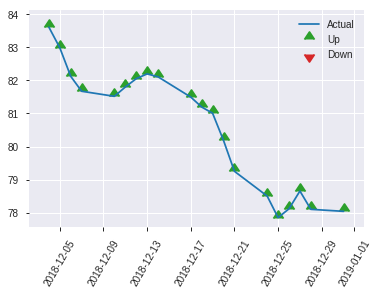


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25511211877930695
RMSE: 0.5050862488519232
LogLoss: 0.7037944245696435
Null degrees of freedom: 255
Residual degrees of freedom: 87
Null deviance: 356.1260369634925
Residual deviance: 360.34274537965746
AIC: 698.3427453796575
AUC: 0.598417469177452
pr_auc: 0.5364275817613781
Gini: 0.19683493835490395
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5352369559971354: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      43   94   0.6861   (94.0/137.0)
1      18   101  0.1513   (18.0/119.0)
Total  61   195  0.4375   (112.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.535237     0.643312  194
max f2                       0.377529     0.813953  254
max f0point5                 0.549591     0.568319  176
max accuracy                 0.616362     0.585938  68
max precision                0.716967     1         0
max recall                   0.377529     1         254
max specificity              0.716967     1         0
max absolute_mcc             0.549591     0.198761  176
max min_per_class_accuracy   0.58803      0.563025  123
max mean_per_class_accuracy  0.549591     0.592038  176

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 57.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.702753           1.43417   1.43417            0.666667         0.714425  0.666667                    0.714425            0.0168067       0.0168067                  43.4174    43.4174
    2        0.0234375                   0.690836           0         0.717087           0                0.693435  0.333333                    0.70393             0               0.0168067                  -100       -28.2913
    3        0.03125                     0.680193           2.15126   1.07563            1                0.683269  0.5                         0.698764            0.0168067       0.0336134                  115.126    7.56303
    4        0.0429688                   0.671366           1.43417   1.17341            0.666667         0.675833  0.545455                    0.69251             0.0168067       0.0504202                  43.4174    17.3415
    5        0.0507812                   0.668346           1.07563   1.15837            0.5              0.669497  0.538462                    0.68897             0.00840336      0.0588235                  7.56303    15.8371
    6        0.101562                    0.651167           1.65482   1.40659            0.769231         0.659942  0.653846                    0.674456            0.0840336       0.142857                   65.4816    40.6593
    7        0.152344                    0.63726            1.15837   1.32385            0.538462         0.644176  0.615385                    0.664363            0.0588235       0.201681                   15.8371    32.3853
    8        0.203125                    0.627374           0.827408  1.19974            0.384615         0.631812  0.557692                    0.656225            0.0420168       0.243697                   -17.2592   19.9741
    9        0.300781                    0.613738           1.03261   1.14548            0.48             0.619256  0.532468                    0.644222            0.10084         0.344538                   3.2605     14.5476
    10       0.402344                    0.603884           1.07563   1.12785            0.5              0.609065  0.524272                    0.635347            0.109244        0.453782                   7.56303    12.7845
    11       0.5                         0.584981           1.11866   1.12605            0.52             0.595603  0.523438                    0.627585            0.109244        0.563025                   11.8655    12.605
    12       0.601562                    0.566423           0.992889  1.10357            0.461538         0.575749  0.512987                    0.618833            0.10084         0.663866                   -0.711054  10.3569
    13       0.699219                    0.549057           1.29076   1.12971            0.6              0.556629  0.52514                     0.610146            0.12605         0.789916                   29.0756    12.9712
    14       0.800781                    0.52737            0.744667  1.08088            0.346154         0.537853  0.502439                    0.600977            0.0756303       0.865546                   -25.5333   8.08772
    15       0.898438                    0.488041           0.688403  1.03822            0.32             0.512708  0.482609                    0.591382            0.0672269       0.932773                   -31.1597   3.8217
    16       1                           0.377086           0.661926  1                  0.307692         0.454421  0.464844                    0

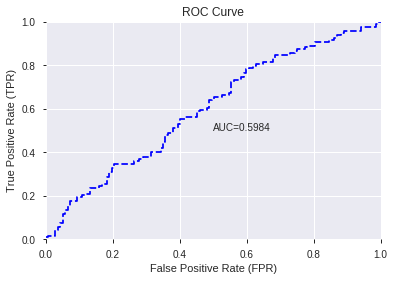

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


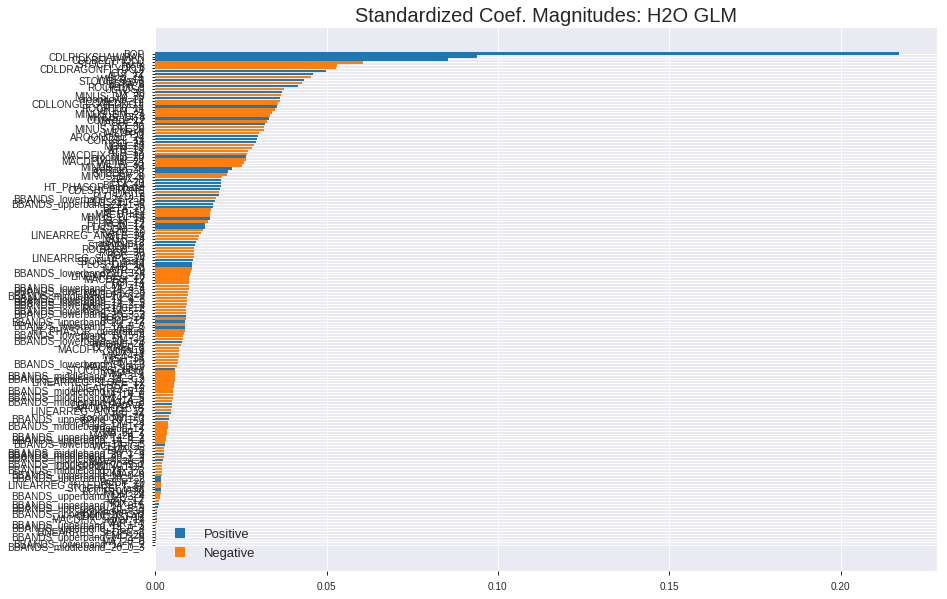

'log_likelihood'
--2019-08-22 11:22:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_112220_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_112220_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLRICKSHAWMAN',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'DX_8',
 'CDLDRAGONFLYDOJI',
 'CCI_12',
 'ADX_24',
 'WILLR_14',
 'STOCH_slowd',
 'BETA_8',
 'ROCR100_8',
 'ULTOSC',
 'DX_30',
 'MINUS_DM_30',
 'aroondown_12',
 'WILLR_12',
 'CDLLONGLEGGEDDOJI',
 'ROCR100_14',
 'WILLR_24',
 'MINUS_DM_24',
 'MINUS_DI_8',
 'CORREL_12',
 'MACDEXT',
 'CCI_30',
 'MINUS_DM_20',
 'WILLR_8',
 'PPO',
 'AROONOSC_24',
 'CORREL_14',
 'CCI_24',
 'MOM_30',
 'ATR_14',
 'ATR_12',
 'MACDFIX_hist_20',
 'aroonup_20',
 'MACDFIX_hist_24',
 'WILLR_30',
 'MINUS_DI_24',
 'aroonup_30',
 'STDDEV_8',
 'MINUS_DI_20',
 'TRIX_8',
 'CCI_20',
 'BETA_14',
 'HT_PHASOR_inphase',
 'CDLSHORTLINE',
 'DX_12',
 'PLUS_DI_8',
 'BBANDS_lowerband_24_2_5',
 'PLUS_DI_30',
 'BBANDS_upperband_24_1_5',
 'BETA_20',
 'BETA_12',
 'MACD_hist',
 'MINUS_DI_14',
 'PLUS_DI_24',
 'MOM_12',
 'PLUS_DI_14',
 'PLUS_DM_12',
 'NATR_30',
 'LINEARREG_ANGLE_14',
 'NATR_24',
 'CMO_12',
 'aroonup_8',
 'STDDEV_12',
 'ROCR100_30',
 'ROCR_30',
 'ROC_30',
 'LINEARR

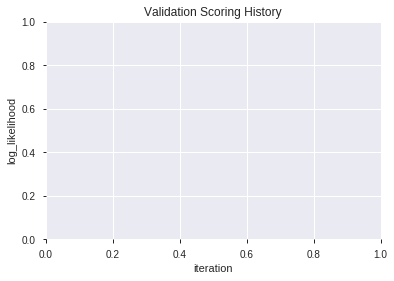

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_112235_model_3  0.592529  0.692211              0.483408  0.499608  0.249608
1  XGBoost_grid_1_AutoML_20190822_112235_model_5  0.592468  0.707172              0.436515  0.505470  0.255500
2  XGBoost_grid_1_AutoML_20190822_112235_model_6  0.577808  0.696959              0.441268  0.501443  0.251445
3               XGBoost_1_AutoML_20190822_112235  0.570263  0.704851              0.479206  0.505330  0.255358
4               XGBoost_2_AutoML_20190822_112235  0.568852  0.699591              0.435625  0.502648  0.252655
5  XGBoost_grid_1_AutoML_20190822_112235_model_1  0.560694  0.695224              0.452217  0.500853  0.250853
6  XGBoost_grid_1_AutoML_20190822_112235_model_2  0.558732  0.696197              0.433080  0.501375  0.251377
7  XGBoost_grid_1_AutoML_20190822_112235_model_4  0.558057  0.699933              0.444581  0.503197  0.253207
8               XGBoost_3_AutoML_20190822_112235  0.557198  0.695596              0.454211  0.501225  0.251227
9  XGBoost_grid_1_AutoML_20190822_112235_model_7  0.554990  0.707701              0.472459  0.506791  0.256837

variable  relative_importance  scaled_importance  percentage
0                        BOP           536.630127           1.000000    0.094648
1                     ULTOSC           198.629715           0.370143    0.035033
2               STOCHF_fastk           172.169739           0.320835    0.030366
3               STOCHF_fastd           138.666885           0.258403    0.024457
4                  CORREL_12           108.080780           0.201406    0.019063
..                       ...                  ...                ...         ...
147               PLUS_DM_12             3.921063           0.007307    0.000692
148  BBANDS_lowerband_14_7_5             3.664267           0.006828    0.000646
149                   WMA_14             3.402838           0.006341    0.000600
150  BBANDS_lowerband_14_4_3             2.811708           0.005240    0.000496
151        CDLLONGLEGGEDDOJI             0.334538           0.000623    0.000059

[152 rows x 4 columns]

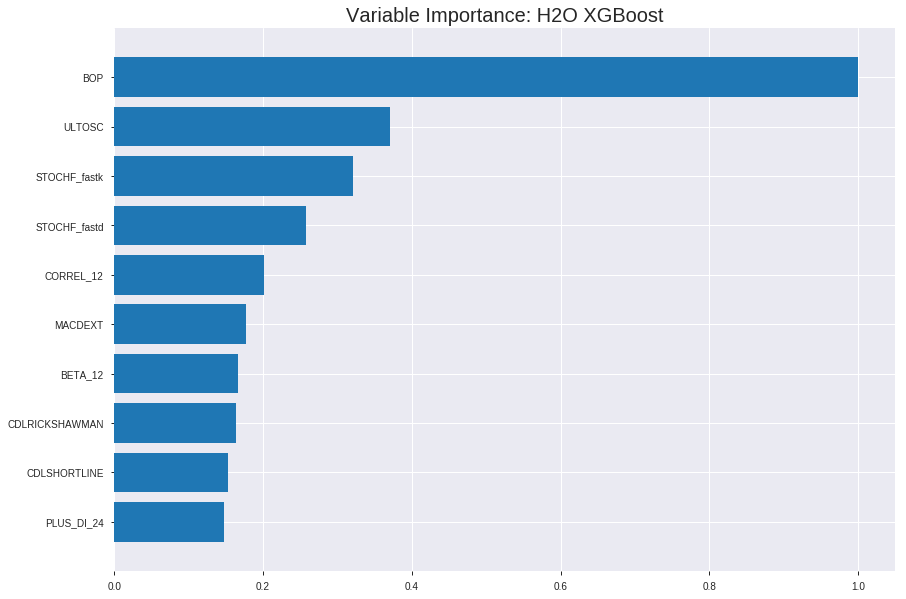

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_112235_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1760081776748603
RMSE: 0.419533285538657
LogLoss: 0.5383198780017214
Mean Per-Class Error: 0.17000425276429687
AUC: 0.9136845199379597
pr_auc: 0.9216300987328647
Gini: 0.8273690398759195
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5039328138033549: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      682  187  0.2152   (187.0/869.0)
1      124  796  0.1348   (124.0/920.0)
Total  806  983  0.1738   (311.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503933     0.836574  199
max f2                       0.444118     0.894407  250
max f0point5                 0.562783     0.859542  150
max accuracy                 0.536643     0.828955  172
max precision                0.848384     1         0
max recall                   0.280822     1         355
max specificity              0.848384     1         0
max absolute_mcc             0.536643     0.660695  172
max min_per_class_accuracy   0.522401     0.823936  185
max mean_per_class_accuracy  0.536643     0.829996  172

Gains/Lift Table: Avg response rate: 51.43 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.783113           1.94457    1.94457            1                0.807128  1                           0.807128            0.0195652       0.0195652                  94.4565   94.4565
    2        0.020123                    0.757417           1.94457    1.94457            1                0.769866  1                           0.788497            0.0195652       0.0391304                  94.4565   94.4565
    3        0.0301845                   0.744415           1.94457    1.94457            1                0.75104   1                           0.776011            0.0195652       0.0586957                  94.4565   94.4565
    4        0.0402459                   0.727706           1.94457    1.94457            1                0.734528  1                           0.76564             0.0195652       0.0782609                  94.4565   94.4565
    5        0.0503074                   0.713149           1.94457    1.94457            1                0.719016  1                           0.756316            0.0195652       0.0978261                  94.4565   94.4565
    6        0.100056                    0.680005           1.92272    1.9337             0.988764         0.696189  0.994413                    0.72642             0.0956522       0.193478                   92.2716   93.3702
    7        0.150363                    0.652002           1.92296    1.93011            0.988889         0.664336  0.992565                    0.705649            0.0967391       0.290217                   92.2959   93.0107
    8        0.200112                    0.63107            1.83532    1.90654            0.94382          0.641258  0.980447                    0.689641            0.0913043       0.381522                   83.532    90.6543
    9        0.300168                    0.594537           1.79248    1.86852            0.921788         0.611579  0.960894                    0.66362             0.179348        0.56087                    79.2476   86.8521
    10       0.400224                    0.560662           1.43398    1.75989            0.73743          0.577437  0.905028                    0.642074            0.143478        0.704348                   43.3981   75.9886
    11       0.500279                    0.525222           1.15153    1.63821            0.592179         0.543116  0.842458                    0.622283            0.115217        0.819565                   15.153    63.8215
    12       0.599776                    0.486358           0.852113   1.50781            0.438202         0.504459  0.775396                    0.602737            0.0847826       0.904348                   -14.7887  50.7808
    13       0.699832                    0.448518           0.488857   1.36213            0.251397         0.46712   0.700479                    0.583348            0.048913        0.953261                   -51.1143  36.2128
    14       0.799888                    0.404317           0.315041   1.23115            0.162011         0.42742   0.633124                    0.563843            0.0315217       0.984783                   -68.4959  23.115
    15       0.899944                    0.330797           0.119498   1.10756            0.0614525        0.370904  0.569565                    0.542392            0.0119565       0.996739                   -88.0502  10.7557
    16       1                           0.127871           0.0325905  1                  0.0167598        0.262994  0.514254                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24134326689282232
RMSE: 0.4912670016323326
LogLoss: 0.6756837982466731
Mean Per-Class Error: 0.42179506933744215
AUC: 0.5951771956856703
pr_auc: 0.6119406094226053
Gini: 0.19035439137134058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39711660146713257: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   217  0.9195   (217.0/236.0)
1      7    268  0.0255   (7.0/275.0)
Total  26   485  0.4384   (224.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397117     0.705263  374
max f2                       0.257864     0.854037  398
max f0point5                 0.484618     0.622662  303
max accuracy                 0.510943     0.592955  276
max precision                0.741806     1         0
max recall                   0.257864     1         398
max specificity              0.741806     1         0
max absolute_mcc             0.484618     0.173395  303
max min_per_class_accuracy   0.554625     0.567273  203
max mean_per_class_accuracy  0.533652     0.578205  247

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 54.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.715813           1.23879   1.23879            0.666667         0.726892  0.666667                    0.726892            0.0145455       0.0145455                  23.8788   23.8788
    2        0.0215264                   0.701592           1.11491   1.18248            0.6              0.707499  0.636364                    0.718077            0.0109091       0.0254545                  11.4909   18.2479
    3        0.0313112                   0.690623           1.48655   1.2775             0.8              0.694116  0.6875                      0.710589            0.0145455       0.04                       48.6545   27.75
    4        0.0410959                   0.680263           1.48655   1.32727            0.8              0.685137  0.714286                    0.704529            0.0145455       0.0545455                  48.6545   32.7273
    5        0.0508806                   0.675038           1.48655   1.3579             0.8              0.677887  0.730769                    0.699406            0.0145455       0.0690909                  48.6545   35.7902
    6        0.101761                    0.652964           0.929091  1.1435             0.5              0.664266  0.615385                    0.681836            0.0472727       0.116364                   -7.09091  14.3497
    7        0.150685                    0.633169           1.33789   1.20661            0.72             0.641268  0.649351                    0.668665            0.0654545       0.181818                   33.7891   20.6612
    8        0.201566                    0.620298           1.3579    1.2448             0.730769         0.62646   0.669903                    0.658011            0.0690909       0.250909                   35.7902   24.4801
    9        0.30137                     0.598383           0.947308  1.14628            0.509804         0.60732   0.616883                    0.641224            0.0945455       0.345455                   -5.26916  14.6281
    10       0.401174                    0.574874           0.947308  1.09678            0.509804         0.585284  0.590244                    0.627307            0.0945455       0.44                       -5.26916  9.67805
    11       0.500978                    0.555097           1.23879   1.12507            0.666667         0.563107  0.605469                    0.614517            0.123636        0.563636                   23.8788   12.5071
    12       0.600783                    0.537456           1.05661   1.1137             0.568627         0.545065  0.599349                    0.60298             0.105455        0.669091                   5.66132   11.3699
    13       0.700587                    0.51488            0.947308  1.08999            0.509804         0.527641  0.586592                    0.592247            0.0945455       0.763636                   -5.26916  8.99949
    14       0.800391                    0.474435           0.947308  1.0722             0.509804         0.495893  0.577017                    0.580232            0.0945455       0.858182                   -5.26916  7.22027
    15       0.900196                    0.432049           0.692264  1.03008            0.372549         0.454277  0.554348                    0.566268            0.0690909       0.927273                   -30.7736  3.00791
    16       1                           0.238163           0.728699  1                  0.392157         0.372271  0.53816                     0.546906           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:22:44  2.488 sec   0                  0.5              0.693147            0.5             0                  1                0.485746                         0.5                0.693147              0.5               0                    1                  0.46184
    2019-08-22 11:22:44  2.762 sec   5                  0.487438         0.668266            0.765025        0.770594           1.84222          0.334824                         0.495877           0.684913              0.587365          0.602567             1.54848            0.407045
    2019-08-22 11:22:44  2.860 sec   10                 0.47794          0.649686            0.800696        0.811329           1.94457          0.294019                         0.494639           0.682436              0.594692          0.61422              1.54848            0.424658
    2019-08-22 11:22:44  2.964 sec   15                 0.468472         0.631288            0.825316        0.835137           1.94457          0.267188                         0.493449           0.680042              0.5953            0.624887             1.54848            0.436399
    2019-08-22 11:22:45  3.081 sec   20                 0.459878         0.614696            0.838079        0.846359           1.94457          0.250419                         0.492183           0.677444              0.595978          0.628517             1.54848            0.440313
    2019-08-22 11:22:45  3.199 sec   25                 0.452434         0.600333            0.85328         0.863629           1.94457          0.230855                         0.491974           0.676949              0.588028          0.625687             1.85818            0.452055
    2019-08-22 11:22:45  3.315 sec   30                 0.444785         0.585647            0.867984        0.879137           1.94457          0.222471                         0.491688           0.676414              0.589045          0.616421             1.54848            0.446184
    2019-08-22 11:22:45  3.451 sec   35                 0.43676          0.570449            0.881797        0.891146           1.94457          0.200112                         0.491718           0.676457              0.587951          0.611791             1.54848            0.428571
    2019-08-22 11:22:45  3.569 sec   40                 0.431288         0.56019             0.893488        0.90222            1.94457          0.191727                         0.491934           0.676935              0.586803          0.609361             1.85818            0.440313
    2019-08-22 11:22:45  3.693 sec   45                 0.424639         0.547726            0.903801        0.912095           1.94457          0.182784                         0.491353           0.675863              0.594091          0.609088             1.54848            0.440313
    2019-08-22 11:22:45  3.824 sec   50                 0.419533         0.53832             0.913685        0.92163            1.94457          0.17384                          0.491267           0.675684              0.595177          0.611941             1.23879            0.438356

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      536.630126953125       1.0                    0.09464821445779839
ULTOSC                   198.6297149658203      0.37014268299396236    0.03503334403999744
STOCHF_fastk             172.16973876953125     0.32083502234038824    0.030366462000045606
STOCHF_fastd             138.66688537597656     0.2584030944429052     0.024457391499390822
CORREL_12                108.08078002929688     0.20140647086468516    0.019062762847589045
---                      ---                    ---                    ---
PLUS_DM_12               3.9210634231567383     0.00730682685562163    0.0006915781152368767
BBANDS_lowerband_14_7_5  3.664266586303711      0.0068282908511094215  0.0006462855368560272
WMA_14                   3.4028377532958984     0.006341123210164342   0.0006001759894989577
BBANDS_lowerband_14_4_3  2.811708450317383      0.005239565035756905   0.0004959154751699017
CDLLONGLEGGEDDOJI        0.3345375061035156     0.0006234042579810985  5.9004099903299696e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.62109375)

('F1', 0.6373626373626373)

('auc', 0.592528982395878)

('logloss', 0.6922113523775228)

('mean_per_class_error', 0.40038643194504075)

('rmse', 0.49960778155121083)

('mse', 0.2496079353865224)

xgboost prediction progress: |████████████████████████████████████████████| 100%


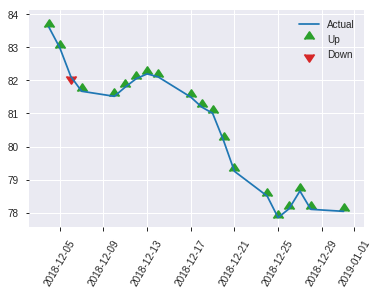


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2496079353865224
RMSE: 0.49960778155121083
LogLoss: 0.6922113523775228
Mean Per-Class Error: 0.40038643194504075
AUC: 0.592528982395878
pr_auc: 0.573842988419805
Gini: 0.18505796479175607
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38725945353507996: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    129  0.9416   (129.0/137.0)
1      3    116  0.0252   (3.0/119.0)
Total  11   245  0.5156   (132.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387259     0.637363  244
max f2                       0.256689     0.813953  254
max f0point5                 0.633538     0.562701  47
max accuracy                 0.633538     0.621094  47
max precision                0.737779     1         0
max recall                   0.256689     1         254
max specificity              0.737779     1         0
max absolute_mcc             0.633538     0.254583  47
max min_per_class_accuracy   0.551811     0.554745  127
max mean_per_class_accuracy  0.633538     0.599614  47

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 54.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.71269            2.15126   2.15126            1                0.724361  1                           0.724361            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.698964           0.717087  1.43417            0.333333         0.705     0.666667                    0.71468             0.00840336      0.0336134                  -28.2913  43.4174
    3        0.03125                     0.695982           1.07563   1.34454            0.5              0.697231  0.625                       0.710318            0.00840336      0.0420168                  7.56303   34.4538
    4        0.0429688                   0.682565           1.43417   1.36898            0.666667         0.689504  0.636364                    0.704641            0.0168067       0.0588235                  43.4174   36.8984
    5        0.0507812                   0.678332           2.15126   1.48933            1                0.680585  0.692308                    0.700941            0.0168067       0.0756303                  115.126   48.9334
    6        0.101562                    0.660937           1.65482   1.57207            0.769231         0.670639  0.730769                    0.68579             0.0840336       0.159664                   65.4816   57.2075
    7        0.152344                    0.645787           1.48933   1.54449            0.692308         0.651637  0.717949                    0.674405            0.0756303       0.235294                   48.9334   54.4495
    8        0.203125                    0.630655           1.32385   1.48933            0.615385         0.637858  0.692308                    0.665269            0.0672269       0.302521                   32.3853   48.9334
    9        0.300781                    0.608828           0.774454  1.25723            0.36             0.619028  0.584416                    0.650256            0.0756303       0.378151                   -22.5546  25.723
    10       0.402344                    0.583972           0.827408  1.14873            0.384615         0.596202  0.533981                    0.636611            0.0840336       0.462185                   -17.2592  14.8731
    11       0.5                         0.551796           1.03261   1.12605            0.48             0.569551  0.523438                    0.623513            0.10084         0.563025                   3.2605    12.605
    12       0.601562                    0.529792           0.910149  1.0896             0.423077         0.541058  0.506494                    0.609592            0.092437        0.655462                   -8.98513  8.95995
    13       0.699219                    0.49446            0.860504  1.0576             0.4              0.511129  0.49162                     0.59584             0.0840336       0.739496                   -13.9496  5.76029
    14       0.800781                    0.460791           0.827408  1.02841            0.384615         0.477443  0.478049                    0.580824            0.0840336       0.823529                   -17.2592  2.84075
    15       0.898438                    0.423545           0.946555  1.01951            0.44             0.443138  0.473913                    0.565858            0.092437        0.915966                   -5.34454  1.95104
    16       1                           0.230513           0.827408  1                  0.384615         0.371852  0.464844                    0.546154           

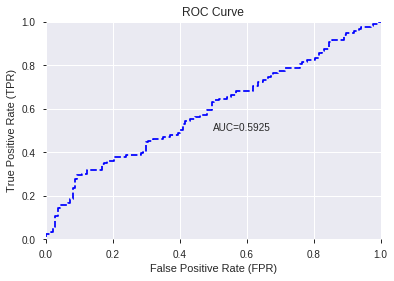

This function is available for GLM models only


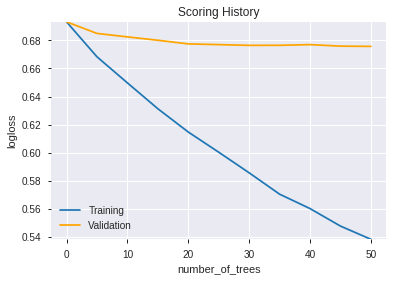

--2019-08-22 11:22:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_112235_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_112235_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_af23',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'ULTOSC',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'CORREL_12',
 'MACDEXT',
 'BETA_12',
 'CDLRICKSHAWMAN',
 'CDLSHORTLINE',
 'PLUS_DI_24',
 'ADX_24',
 'CCI_20',
 'BETA_8',
 'WILLR_24',
 'DX_12',
 'BETA_14',
 'WILLR_8',
 'PLUS_DI_8',
 'ROCR100_14',
 'MINUS_DI_24',
 'MINUS_DI_8',
 'STDDEV_8',
 'STDDEV_12',
 'PLUS_DI_14',
 'CCI_12',
 'HT_PHASOR_inphase',
 'MACD_hist',
 'MINUS_DI_14',
 'BBANDS_upperband_20_6_5',
 'CORREL_8',
 'CORREL_14',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'NATR_20',
 'WILLR_12',
 'MOM_20',
 'RSI_24',
 'DX_8',
 'BETA_20',
 'MACDFIX_signal_8',
 'MINUS_DM_24',
 'LINEARREG_SLOPE_8',
 'ROCR100_8',
 'WILLR_30',
 'BBANDS_upperband_20_3_2',
 'STOCHRSI_fastd',
 'DX_14',
 'BBANDS_middleband_14_3_2',
 'LINEARREG_INTERCEPT_14',
 'PLUS_DM_24',
 'ROC_30',
 'CMO_14',
 'CDLDRAGONFLYDOJI',
 'ROCR100_12',
 'PLUS_DM_30',
 'VAR_14',
 'ROCP_12',
 'PLUS_DI_30',
 'BBANDS_lowerband_14_5_5',
 'MOM_24',
 'MACDFIX_hist_24',
 'WILLR_14',
 'NATR_24',
 'MOM_30',
 'BBANDS_middleband_20_6_2

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.660
GLM             0.664
XGBoost         0.629
dtype: float64

DeepLearning    GLM  XGBoost
All          0.629  0.664    0.605
DLF          0.660  0.629    0.629
Fwe          0.602  0.578    0.582
RFE          0.590  0.586    0.621
XGBF         0.656  0.629    0.629





F1


DeepLearning    0.653
GLM             0.659
XGBoost         0.647
dtype: float64

DeepLearning    GLM  XGBoost
All          0.650  0.650    0.646
DLF          0.645  0.659    0.647
Fwe          0.647  0.639    0.646
RFE          0.642  0.643    0.637
XGBF         0.653  0.659    0.647





auc


DeepLearning    0.670
GLM             0.679
XGBoost         0.644
dtype: float64

DeepLearning    GLM  XGBoost
All          0.631  0.679    0.629
DLF          0.670  0.646    0.644
Fwe          0.617  0.579    0.551
RFE          0.596  0.598    0.593
XGBF         0.668  0.646    0.644





logloss


DeepLearning    0.744
GLM             0.704
XGBoost         0.705
dtype: float64

DeepLearning    GLM  XGBoost
All          0.677  0.685    0.682
DLF          0.689  0.672    0.684
Fwe          0.744  0.704    0.705
RFE          0.690  0.704    0.692
XGBF         0.688  0.672    0.684





mean_per_class_error


DeepLearning    0.419
GLM             0.423
XGBoost         0.410
dtype: float64

DeepLearning    GLM  XGBoost
All          0.388  0.350    0.391
DLF          0.340  0.386    0.375
Fwe          0.402  0.423    0.410
RFE          0.419  0.408    0.400
XGBF         0.355  0.386    0.375





rmse


DeepLearning    0.524
GLM             0.505
XGBoost         0.505
dtype: float64

DeepLearning    GLM  XGBoost
All          0.492  0.496    0.495
DLF          0.498  0.491    0.496
Fwe          0.524  0.505    0.505
RFE          0.498  0.505    0.500
XGBF         0.498  0.491    0.496





mse


DeepLearning    0.274
GLM             0.255
XGBoost         0.255
dtype: float64

DeepLearning    GLM  XGBoost
All          0.242  0.246    0.245
DLF          0.248  0.241    0.246
Fwe          0.274  0.255    0.255
RFE          0.248  0.255    0.250
XGBF         0.248  0.241    0.246

{'F1':       DeepLearning    GLM  XGBoost
 All          0.650    NaN      NaN
 DLF          0.645    NaN      NaN
 DLF            NaN  0.659      NaN
 DLF            NaN    NaN    0.647
 All            NaN  0.650      NaN
 All            NaN    NaN    0.646
 XGBF         0.653    NaN      NaN
 XGBF           NaN  0.659      NaN
 XGBF           NaN    NaN    0.647
 Fwe          0.647    NaN      NaN
 Fwe            NaN  0.639      NaN
 Fwe            NaN    NaN    0.646
 RFE          0.642    NaN      NaN
 RFE            NaN  0.643      NaN
 RFE            NaN    NaN    0.637,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.629    NaN      NaN
 DLF          0.660    NaN      NaN
 DLF            NaN  0.629      NaN
 DLF            NaN    NaN    0.629
 All            NaN  0.664      NaN
 All            NaN    NaN    0.605
 XGBF         0.656    NaN      NaN
 XGBF           NaN  0.629      NaN
 XGBF           NaN    NaN    0.629
 Fwe          0.602    NaN      NaN
 Fwe     